In [1]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates

import seaborn as sns
import missingno as msno 


import matplotlib as mpl
from scipy.interpolate import make_interp_spline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from  sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import multiprocessing
from sklearn.model_selection import KFold
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate


import warnings
from sklearn.model_selection import ParameterGrid
import random


%matplotlib inline
sns.set_style("darkgrid")
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_error

In [2]:
new_df_mesos = pd.read_csv('new_df_mesos.csv').set_index('month_year')
new_df_dies = pd.read_csv('new_df_dies.csv').set_index('Dates')
community_mesos = pd.read_csv('community_mesos.csv').set_index('month_year')
community_dies = pd.read_csv('community_dies.csv').set_index('Dates')

df_prova = pd.read_csv('df_prova.csv')
df = pd.read_csv('df.csv')

ed = pd.read_csv('ed.csv')
cit = pd.read_csv('cit.csv')
pov = pd.read_csv('pov.csv')

In [3]:
df['month_year'] = pd.to_datetime(df.Dates).dt.to_period('M')
df['Dates'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Date']).dt.time

selected_types = ['CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE']
descriptions = ['PUBLIC INDECENCY', 'SEXUAL EXPLOITATION OF A CHILD', 
       'INDECENT SOLICITATION/CHILD', 'CRIMINAL TRANSMISSION OF HIV',
       'INDECENT SOLICITATION OF A CHILD', 'FORNICATION', 'BIGAMY',
        'MARRYING A BIGAMIST']
df.Dates = pd.to_datetime(df.Dates)
df_prova = df[(df['Primary Type'] == 'CRIMINAL SEXUAL ASSAULT') | (df['Primary Type'] == 'SEX OFFENSE')]
for description in descriptions:
    df_prova = df_prova[df_prova['Description'] != description]

In [4]:
community_dies.index = pd.to_datetime(community_dies.index)
community_mesos.index = pd.to_datetime(community_mesos.index)
new_df_dies.index = pd.to_datetime(new_df_dies.index)
new_df_mesos.index = pd.to_datetime(new_df_mesos.index)

In [5]:
date ={}
date['date_end_train'] = '2023-01-23'
date['date_end_train_mesos'] = '2021-12'

## Forecasting

### Forecasting exógenes

In [6]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [7]:
fore_cit = cit[cit['Unnamed: 0'].str.contains('Percent', na=False)]
fore_cit['2022'] = np.nan
fore_cit = fore_cit.set_index('Area').T.iloc[1:]
for j in range(0, len(fore_cit.columns)):
    for i in range(0, len(fore_cit.index)-1):
        fore_cit.iloc[i,j] = float(fore_cit.iloc[i,j].strip('%'))/100
        
        
pov_cit = pov[pov['Unnamed: 0'].str.contains('Percent', na=False)]
pov_cit['2022'] = np.nan
pov_cit = pov_cit.set_index('Area').T.iloc[1:]
for j in range(0, len(pov_cit.columns)):
    for i in range(0, len(pov_cit.index)-1):
        pov_cit.iloc[i,j] = float(pov_cit.iloc[i,j].strip('%'))/100
        
        
fore_ed = ed[ed['Unnamed: 0'].str.contains('Percent', na=False)]
fore_ed['2022'] = np.nan
fore_ed = fore_ed.set_index('Area').T
for j in range(0, len(fore_ed.columns)):
    for i in range(1, len(fore_ed.index)-1):
        fore_ed.iloc[i,j] = float(fore_ed.iloc[i,j].strip('%'))/100
        
fore_cit

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Area          1      10     11     12     13     14     15     16     17  \
2000       0.338  0.187  0.274  0.198  0.384  0.522  0.373  0.358  0.345   
2008-2012   0.29  0.222  0.285  0.183  0.388  0.461  0.322  0.319  0.356   
2009-2013  0.293  0.206   0.28  0.186  0.376  0.455  0.317  0.315  0.349   
2010-2014  0.288  0.187  0.263    0.2  0.365  0.439   0.32  0.334   0.33   
2011-2015   0.29    0.2   0.28    0.2   0.38   0.45   0.33   0.33   0.32   
2012-2016  0.264  0.205   0.29  0.173  0.404  0.437  0.324  0.311  0.314   
2013-2017  0.275  0.199   0.28  0.189  0.399  0.423  0.318  0.305  0.302   
2014-2018  0.276  0.172  0.284    0.2    0.4  0.401   0.32  0.289  0.312   
2015-2019   0.27  0.192   0.28  0.182  0.398  0.396  0.322  0.287  0.325   
2016-2020  0.261  0.169  0.259  0.187  0.395  0.376  0.326  0.264  0.312   
2022         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Area          18  ...     71     72     73     74     75     76     77     78  \
2000       0.336  ...  0.012  0.026  0.013  0.038  0.024  0.397  0.361  0.217   
2008-2012  0.353  ...  0.009  0.035  0.007  0.028  0.027  0.466  0.305  0.212   
2009-2013  0.374  ...  0.012  0.029  0.013  0.028  0.024  0.471  0.298  0.211   
2010-2014   0.35  ...  0.011  0.033  0.014  0.033   0.02  0.492  0.288  0.209   
2011-2015   0.32  ...   0.01   0.03   0.01   0.03   0.02   0.47   0.28   0.21   
2012-2016    0.3  ...  0.016  0.031  0.015   0.04   0.03  0.511  0.288  0.209   
2013-2017  0.293  ...  0.018  0.032  0.016   0.04  0.028  0.519  0.276  0.207   
2014-2018  0.284  ...  0.019   0.04  0.008  0.042  0.027  0.531  0.277  0.206   
2015-2019  0.317  ...  0.023  0.037  0.008  0.038   0.04  0.546  0.268  0.206   
2016-2020  0.345  ...  0.029  0.037  0.008  0.038  0.035  0.567  0.279  0.202   
2022         NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Area          8      9   
2000       0.133  0.115  
2008-2012  0.176   0.13  
2009-2013  0.165  0.141  
2010-2014  0.163  0.143  
2011-2015   0.17   0.13  
2012-2016  0.167  0.115  
2013-2017  0.162  0.097  
2014-2018  0.164  0.088  
2015-2019  0.169  0.095  
2016-2020  0.169   0.09  
2022         NaN    NaN  

[11 rows x 78 columns]

In [8]:
fore_ed = df_column_uniquify(fore_ed)

In [9]:
ff = fore_cit.reset_index().rename(columns={"index":"anys"})
pp = pov_cit.reset_index().rename(columns={"index":"anys"})
ee = fore_ed.reset_index().rename(columns={"index":"anys"})

anyy = 2012
ee = ee.anys

for i in range(1, len(fore_cit)):
    ff.anys[i]= anyy
    pp.anys[i]= anyy
    ee[i+1]= anyy
    anyy +=1
    
ff = ff.set_index('anys')
ff.index = pd.to_datetime(ff.index, format='%Y')
pp = pp.set_index('anys')
pp.index = pd.to_datetime(pp.index, format='%Y')
fr =fore_ed.reset_index()
fr['anys'] = ee
fr = fr[1:]
ee = fr.set_index('anys')
ee.index = pd.to_datetime(ee.index, format='%Y')

ff =ff[1:]
pp =pp[1:]
ee = ee[1:]

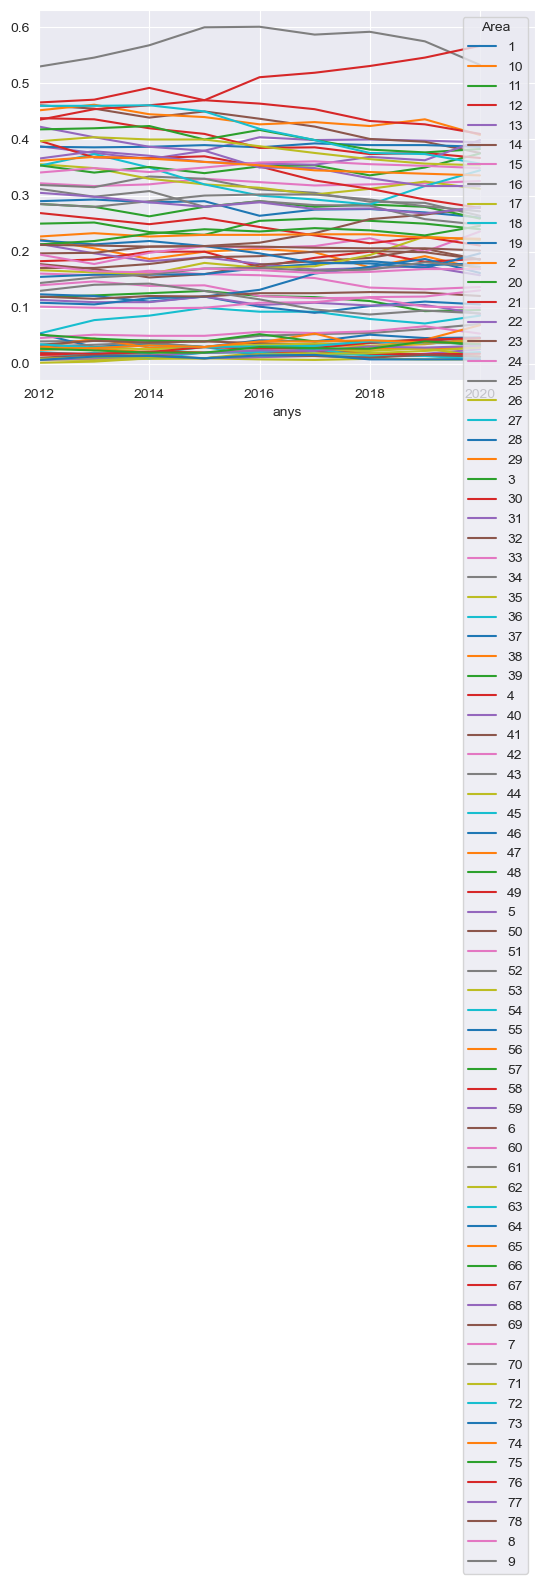

In [10]:
ff.plot()
plt.show()

In [11]:
fore_cit = fore_cit.astype('float')
ff = ff.astype('float')
pp = pp.astype('float')
ee = ee.drop(columns='index')
ee = ee.astype('float')

In [12]:
result = adfuller(ee[1].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#stationary so d = 0

ADF Statistic: -0.644879
p-value: 0.860515


In [13]:
model = ARIMA(ee[1], order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                   10
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  31.790
Date:                Tue, 06 Jun 2023   AIC                            -51.581
Time:                        10:12:46   BIC                            -50.397
Sample:                    01-01-2012   HQIC                           -54.134
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2459     17.860      0.014      0.989     -34.759      35.251
ar.L2          0.4847     13.191      0.037      0.971     -25.368      26.338
ma.L1          0.0360     24.742      0.001      0.9

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


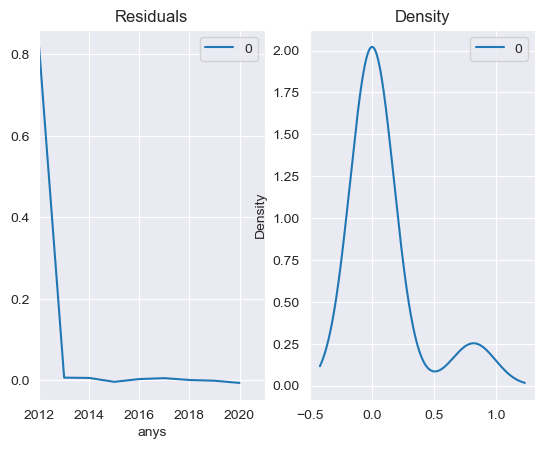

In [14]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='anys'>

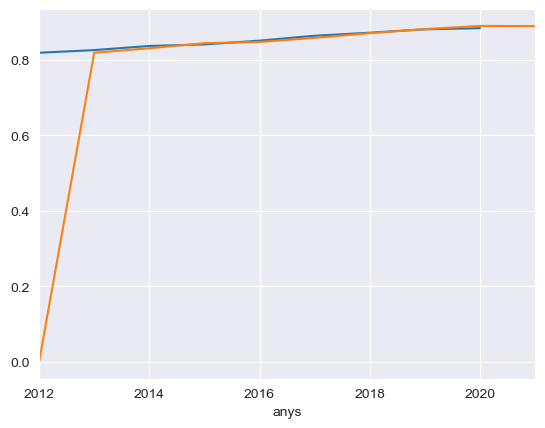

In [15]:
# Actual vs Fitted
ee[1].plot()
model_fit.predict(dynamic = False).plot()

In [16]:
# Create Training and Test
train = ee.iloc[:len(ee)]
test = ee.iloc[len(ee):]

In [17]:
model = ARIMA(train[1], order=(2, 1, 3))  
fitted = model.fit()  

# Forecast
forecast = fitted.forecast(15, alpha=0.05)  # 95% conf
forecast

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Lik

2022-01-01    0.891382
2023-01-01    0.891408
2024-01-01    0.892784
2025-01-01    0.893136
2026-01-01    0.893889
2027-01-01    0.894245
2028-01-01    0.894697
2029-01-01    0.894981
2030-01-01    0.895270
2031-01-01    0.895479
2032-01-01    0.895670
2033-01-01    0.895818
2034-01-01    0.895948
2035-01-01    0.896051
2036-01-01    0.896139
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [18]:
for i in ee.columns:

    # Build Model
    model = ARIMA(train[i], order=(2, 1, 3))  
    fitted = model.fit()  

    # Forecast
    forecast = fitted.forecast(15, alpha=0.05)  # 95% conf
    
    fore_ed.loc[:,i].iloc[-1:] = forecast[0]

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self

In [19]:
fore_ed

1                          1_1  \
Unnamed: 0  Percent HS Grad or Higher  Percent with a BA or Higher   
2000                            0.746                         0.32   
2008-2012                       0.818                        0.404   
2009-2013                       0.825                        0.408   
2010-2014                       0.836                        0.418   
2011-2015                        0.84                         0.42   
2012-2016                        0.85                        0.429   
2013-2017                       0.863                        0.424   
2014-2018                       0.871                         0.45   
2015-2019                        0.88                         0.45   
2016-2020                       0.883                        0.472   
2022                         0.891382                     0.481125   

                                   10                         10_1  \
Unnamed: 0  Percent HS Grad or Higher  Percent with a BA or Higher   
2000                            0.827                        0.247   
2008-2012                       0.885                        0.312   
2009-2013                       0.903                        0.316   
2010-2014                       0.919                        0.336   
2011-2015                        0.92                         0.35   
2012-2016                       0.922                         0.36   
2013-2017                       0.924                        0.375   
2014-2018                       0.926                         0.39   
2015-2019                        0.92                         0.39   
2016-2020                       0.927                        0.419   
2022                         0.942343                      0.43869   

                                   11                         11_1  \
Unnamed: 0  Percent HS Grad or Higher  Percent with a BA or Higher   
2000                              0.8                        0.221   
2008-2012                       0.866                        0.293   
2009-2013                       0.872                        0.303   
2010-2014                       0.866                        0.319   
2011-2015                        0.87                         0.31   
2012-2016                       0.874                        0.343   
2013-2017                        0.89                        0.356   
2014-2018                       0.895                        0.364   
2015-2019                        0.91                         0.36   
2016-2020                       0.926                        0.405   
2022                          0.95051                     0.419185   

                                   12                         12_1  \
Unnamed: 0  Percent HS Grad or Higher  Percent with a BA or Higher   
2000                            0.896                        0.432   
2008-2012                       0.951                        0.564   
2009-2013                        0.95                         0.59   
2010-2014                        0.95                         0.58   
2011-2015                        0.95                         0.59   
2012-2016                       0.952                        0.606   
2013-2017                       0.945                        0.594   
2014-2018                       0.937                        0.571   
2015-2019                        0.94                         0.57   
2016-2020                       0.946                         0.59   
2022                         0.944618                     0.582444   

                                   13                         13_1  ...  \
Unnamed: 0  Percent HS Grad or Higher  Percent with a BA or Higher  ...   
2000                             0.82                        0.375  ...   
2008-2012                       0.856                        0.422  ...   
2009-2013                       0.882                        0.451  ...   
2010-2014        

In [20]:
# Create Training and Test

train = pp.iloc[:len(pp)]
test = pp.iloc[len(pp):]

In [21]:
for i in range(1, len(pp.columns)+1):

    # Build Model
    model = ARIMA(train[i], order=(2, 1, 3))  
    fitted = model.fit()  

    # Forecast
    forecast = fitted.forecast(15, alpha=0.05)  # 95% conf
    
    pov_cit.loc[:,i].iloc[-1:] = forecast[0]

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Lik

In [22]:
pov_cit[pov_cit <0] = 0
pov_cit

Area            1         10        11        12        13        14  \
2000         0.213     0.043     0.049     0.026     0.105     0.177   
2008-2012    0.269     0.053      0.07     0.068     0.125     0.214   
2009-2013    0.277     0.059     0.077      0.06     0.117     0.209   
2010-2014    0.272      0.06     0.089      0.05     0.124     0.195   
2011-2015     0.26      0.06      0.09      0.04      0.14      0.19   
2012-2016    0.265     0.066     0.086      0.04     0.133     0.188   
2013-2017    0.262      0.06     0.078     0.044     0.144     0.185   
2014-2018    0.259     0.061     0.097     0.047     0.155     0.177   
2015-2019    0.255     0.069     0.096     0.048     0.146     0.162   
2016-2020    0.216      0.07     0.081     0.041     0.146     0.134   
2022       0.20642  0.068006  0.093924  0.021515  0.144474  0.080793   

Area             15        16        17        18  ...       71        72  \
2000           0.08     0.113     0.052     0.056  ...    0.206      0.04   
2008-2012     0.136     0.144     0.098     0.133  ...    0.301     0.045   
2009-2013     0.136     0.145     0.104      0.14  ...    0.313     0.035   
2010-2014     0.146     0.139      0.11     0.147  ...    0.307     0.036   
2011-2015      0.13      0.13      0.11      0.15  ...     0.29      0.05   
2012-2016     0.131     0.108     0.105     0.136  ...    0.292     0.038   
2013-2017     0.123     0.109     0.093     0.139  ...    0.289     0.046   
2014-2018     0.113     0.103     0.081     0.132  ...    0.261     0.045   
2015-2019     0.093     0.091     0.069     0.119  ...    0.254      0.05   
2016-2020     0.077     0.087      0.07     0.117  ...    0.251     0.063   
2022       0.042822  0.068514  0.080993  0.109143  ...  0.23543  0.058198   

Area             73        74        75        76        77        78     8   \
2000          0.124     0.039     0.115      0.08     0.171     0.196  0.152   
2008-2012     0.199      0.03     0.152     0.177     0.186     0.221  0.135   
2009-2013     0.196      0.03     0.155     0.203     0.178     0.226  0.131   
2010-2014     0.182     0.039     0.194     0.226     0.184     0.227  0.128   
2011-2015      0.16      0.05      0.18      0.22      0.18      0.22   0.12   
2012-2016     0.186      0.04     0.193     0.145     0.175     0.217  0.116   
2013-2017     0.198     0.036     0.179     0.151     0.163     0.206  0.102   
2014-2018     0.204     0.041     0.188     0.131     0.161     0.195    0.1   
2015-2019     0.215     0.051     0.115     0.115     0.148     0.184  0.095   
2016-2020       0.2     0.046     0.115     0.108     0.148     0.173  0.096   
2022       0.193235  0.033209  0.140136  0.120976  0.141199  0.153898  0.096   

Area             9   
2000          0.024  
2008-2012      0.03  
2009-2013     0.032  
2010-2014     0.024  
2011-2015      0.02  
2012-2016     0.016  
2013-2017     0.027  
2014-2018     0.028  
2015-2019     0.035  
2016-2020     0.033  
2022       0.032161  

[11 rows x 78 columns]

In [23]:
# Create Training and Test
train = ff.iloc[:len(ff)]
test = ff.iloc[len(ff):]

In [24]:
for i in range(1, len(ff.columns)+1):

    # Build Model
    model = ARIMA(train[i], order=(3, 2, 1))  
    fitted = model.fit()  

    # Forecast
    forecast = fitted.forecast(15, alpha=0.05)  # 95% conf
    
    fore_cit.loc[:,i].iloc[-1:] = forecast[0]

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self

In [25]:
fore_cit[fore_cit <0] = 0
fore_cit

Area             1       10        11        12        13        14       15  \
2000       0.338000  0.1870  0.274000  0.198000  0.384000  0.522000  0.37300   
2008-2012  0.290000  0.2220  0.285000  0.183000  0.388000  0.461000  0.32200   
2009-2013  0.293000  0.2060  0.280000  0.186000  0.376000  0.455000  0.31700   
2010-2014  0.288000  0.1870  0.263000  0.200000  0.365000  0.439000  0.32000   
2011-2015  0.290000  0.2000  0.280000  0.200000  0.380000  0.450000  0.33000   
2012-2016  0.264000  0.2050  0.290000  0.173000  0.404000  0.437000  0.32400   
2013-2017  0.275000  0.1990  0.280000  0.189000  0.399000  0.423000  0.31800   
2014-2018  0.276000  0.1720  0.284000  0.200000  0.400000  0.401000  0.32000   
2015-2019  0.270000  0.1920  0.280000  0.182000  0.398000  0.396000  0.32200   
2016-2020  0.261000  0.1690  0.259000  0.187000  0.395000  0.376000  0.32600   
2022       0.258782  0.1593  0.242242  0.190699  0.402243  0.349079  0.33247   

Area             16       17        18  ...        71        72     73  \
2000       0.358000  0.34500  0.336000  ...  0.012000  0.026000  0.013   
2008-2012  0.319000  0.35600  0.353000  ...  0.009000  0.035000  0.007   
2009-2013  0.315000  0.34900  0.374000  ...  0.012000  0.029000  0.013   
2010-2014  0.334000  0.33000  0.350000  ...  0.011000  0.033000  0.014   
2011-2015  0.330000  0.32000  0.320000  ...  0.010000  0.030000  0.010   
2012-2016  0.311000  0.31400  0.300000  ...  0.016000  0.031000  0.015   
2013-2017  0.305000  0.30200  0.293000  ...  0.018000  0.032000  0.016   
2014-2018  0.289000  0.31200  0.284000  ...  0.019000  0.040000  0.008   
2015-2019  0.287000  0.32500  0.317000  ...  0.023000  0.037000  0.008   
2016-2020  0.264000  0.31200  0.345000  ...  0.029000  0.037000  0.008   
2022       0.240701  0.32233  0.396393  ...  0.034879  0.035803  0.000   

Area             74        75        76        77        78        8   \
2000       0.038000  0.024000  0.397000  0.361000  0.217000  0.133000   
2008-2012  0.028000  0.027000  0.466000  0.305000  0.212000  0.176000   
2009-2013  0.028000  0.024000  0.471000  0.298000  0.211000  0.165000   
2010-2014  0.033000  0.020000  0.492000  0.288000  0.209000  0.163000   
2011-2015  0.030000  0.020000  0.470000  0.280000  0.210000  0.170000   
2012-2016  0.040000  0.030000  0.511000  0.288000  0.209000  0.167000   
2013-2017  0.040000  0.028000  0.519000  0.276000  0.207000  0.162000   
2014-2018  0.042000  0.027000  0.531000  0.277000  0.206000  0.164000   
2015-2019  0.038000  0.040000  0.546000  0.268000  0.206000  0.169000   
2016-2020  0.038000  0.035000  0.567000  0.279000  0.202000  0.169000   
2022       0.038486  0.044165  0.591656  0.270011  0.199263  0.168408   

Area             9   
2000       0.115000  
2008-2012  0.130000  
2009-2013  0.141000  
2010-2014  0.143000  
2011-2015  0.130000  
2012-2016  0.115000  
2013-2017  0.097000  
2014-2018  0.088000  
2015-2019  0.095000  
2016-2020  0.090000  
2022       0.053295  

[11 rows x 78 columns]

In [26]:
for i in fore_cit.columns:
    x = fore_cit.loc[:, i].iloc[-1]
    if i==78:
        new_df_dies.loc[(new_df_dies.index.year >= 2022), 'Foreign born'] = x
        new_df_mesos.loc[(new_df_mesos.index.year >= 2022), 'Foreign born'] = x
    else:
        community_dies.loc[(community_dies.index.year >= 2022) & (community_dies['Community Area'] == i), 'Foreign born'] = x
        community_mesos.loc[(community_mesos.index.year >= 2022) & (community_mesos['Community Area'] == i), 'Foreign born'] = x

for i in pov_cit.columns:
    x = pov_cit.loc[:, i].iloc[-1]
    if i==78:
        new_df_dies.loc[(new_df_dies.index.year >= 2022), 'Poverty'] = x
        new_df_mesos.loc[(new_df_mesos.index.year >= 2022), 'Poverty'] = x
    else:
        community_dies.loc[(community_dies.index.year >= 2022) & (community_dies['Community Area'] == i), 'Poverty'] = x
        community_mesos.loc[(community_mesos.index.year >= 2022) & (community_mesos['Community Area'] == i), 'Poverty'] = x

for i in fore_cit.columns:
    x = fore_ed.loc[:, i].iloc[-1]
    if i==78:
        new_df_dies.loc[(new_df_dies.index.year >= 2022), 'HS Grads'] = x
        new_df_mesos.loc[(new_df_mesos.index.year >= 2022), 'HS Grads'] = x
    else:
        community_dies.loc[(community_dies.index.year >= 2022) & (community_dies['Community Area'] == i), 'HS Grads'] = x
        community_mesos.loc[(community_mesos.index.year >= 2022) & (community_mesos['Community Area'] == i), 'HS Grads'] = x
        
for i in fore_ed.filter(regex='_').columns:
    x = fore_ed.filter(regex='_').loc[:, i].iloc[-1]
    if len(i) == 3:
        i = float(i[0])
    else:
        i = float(i[:2])
    if i==78:
        new_df_dies.loc[(new_df_dies.index.year >= 2022), 'BA Grads'] = x
        new_df_mesos.loc[(new_df_mesos.index.year >= 2022), 'BA Grads'] = x
    else:
        community_dies.loc[(community_dies.index.year >= 2022) & (community_dies['Community Area'] == i), 'BA Grads'] = x
        community_mesos.loc[(community_mesos.index.year >= 2022) & (community_mesos['Community Area'] == i), 'BA Grads'] = x

In [27]:
def split_func (data, X, y, end_date, test_size):
    
    # Splitting train and test
    idx_train, idx_test = train_test_split(data.index, test_size=test_size, shuffle=False)
    X_train, y_train = X.loc[idx_train, :], X.loc[idx_test, :]
    X_test, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

## 14 dies total 

In [70]:
nnf = new_df_dies.loc[new_df_dies.index.year >=2017]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

In [71]:
X= new_df_dies.drop(columns = ['Agressions'])
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

# weights = create_sample_weights(X_train, '2023-01-01')
model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model       MAPE  MAPE mean      SMAPE  \
Dates                                                                           
2023-01-24           9  4.008311    5.857143  22.084692  33.718821  25.157637   
2023-01-25           4  4.051965    5.857143  22.084692  33.718821  25.157637   
2023-01-26           4  4.352157    5.857143  22.084692  33.718821  25.157637   
2023-01-27          12  4.464498    5.857143  22.084692  33.718821  25.157637   
2023-01-28           5  5.283451    5.857143  22.084692  33.718821  25.157637   
2023-01-29           4  4.964410    5.857143  22.084692  33.718821  25.157637   
2023-01-30           4  5.275969    5.857143  22.084692  33.718821  25.157637   
2023-01-31           5  4.962300    5.857143  22.084692  33.718821  25.157637   
2023-02-01           8  7.896187    5.857143  22.084692  33.718821  25.157637   
2023-02-02           4  5.264387    5.857143  22.084692  33.718821  25.157637   
2023-02-03           4  5.010416    5.857143  22.084692  33.718821  25.157637   
2023-02-04           5  5.570142    5.857143  22.084692  33.718821  25.157637   
2023-02-05           6  5.134643    5.857143  22.084692  33.718821  25.157637   
2023-02-06           8  5.248169    5.857143  22.084692  33.718821  25.157637   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-25   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-26   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-27   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-28   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-29   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-30   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-01-31   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-01   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-02   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-03   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-04   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-05   34.878743  1.575628  1.959184     57.142857          64.285714   
2023-02-06   34.878743  1.575628  1.959184     57.142857          64.285714   

                RMSE  RMSE mean  
Dates                            
2023-01-24  2.615125   2.386185  
2023-01-25  2.615125   2.386185  
2023-01-26  2.615125   2.386185  
2023-01-27  2.615125   2.386185  
2023-01-28  2.615125   2.386185  
2023-01-29  2.615125   2.386185  
2023-01-30  2.615125   2.386185  
2023-01-31  2.615125   2.386185  
2023-02-01  2.615125   2.386185  
2023-02-02  2.615125   2.386185  
2023-02-03  2.615125   2.386185  
2023-02-04  2.615125   2.386185  
2023-02-05  2.615125   2.386185  
2023-02-06  2.615125   2.386185

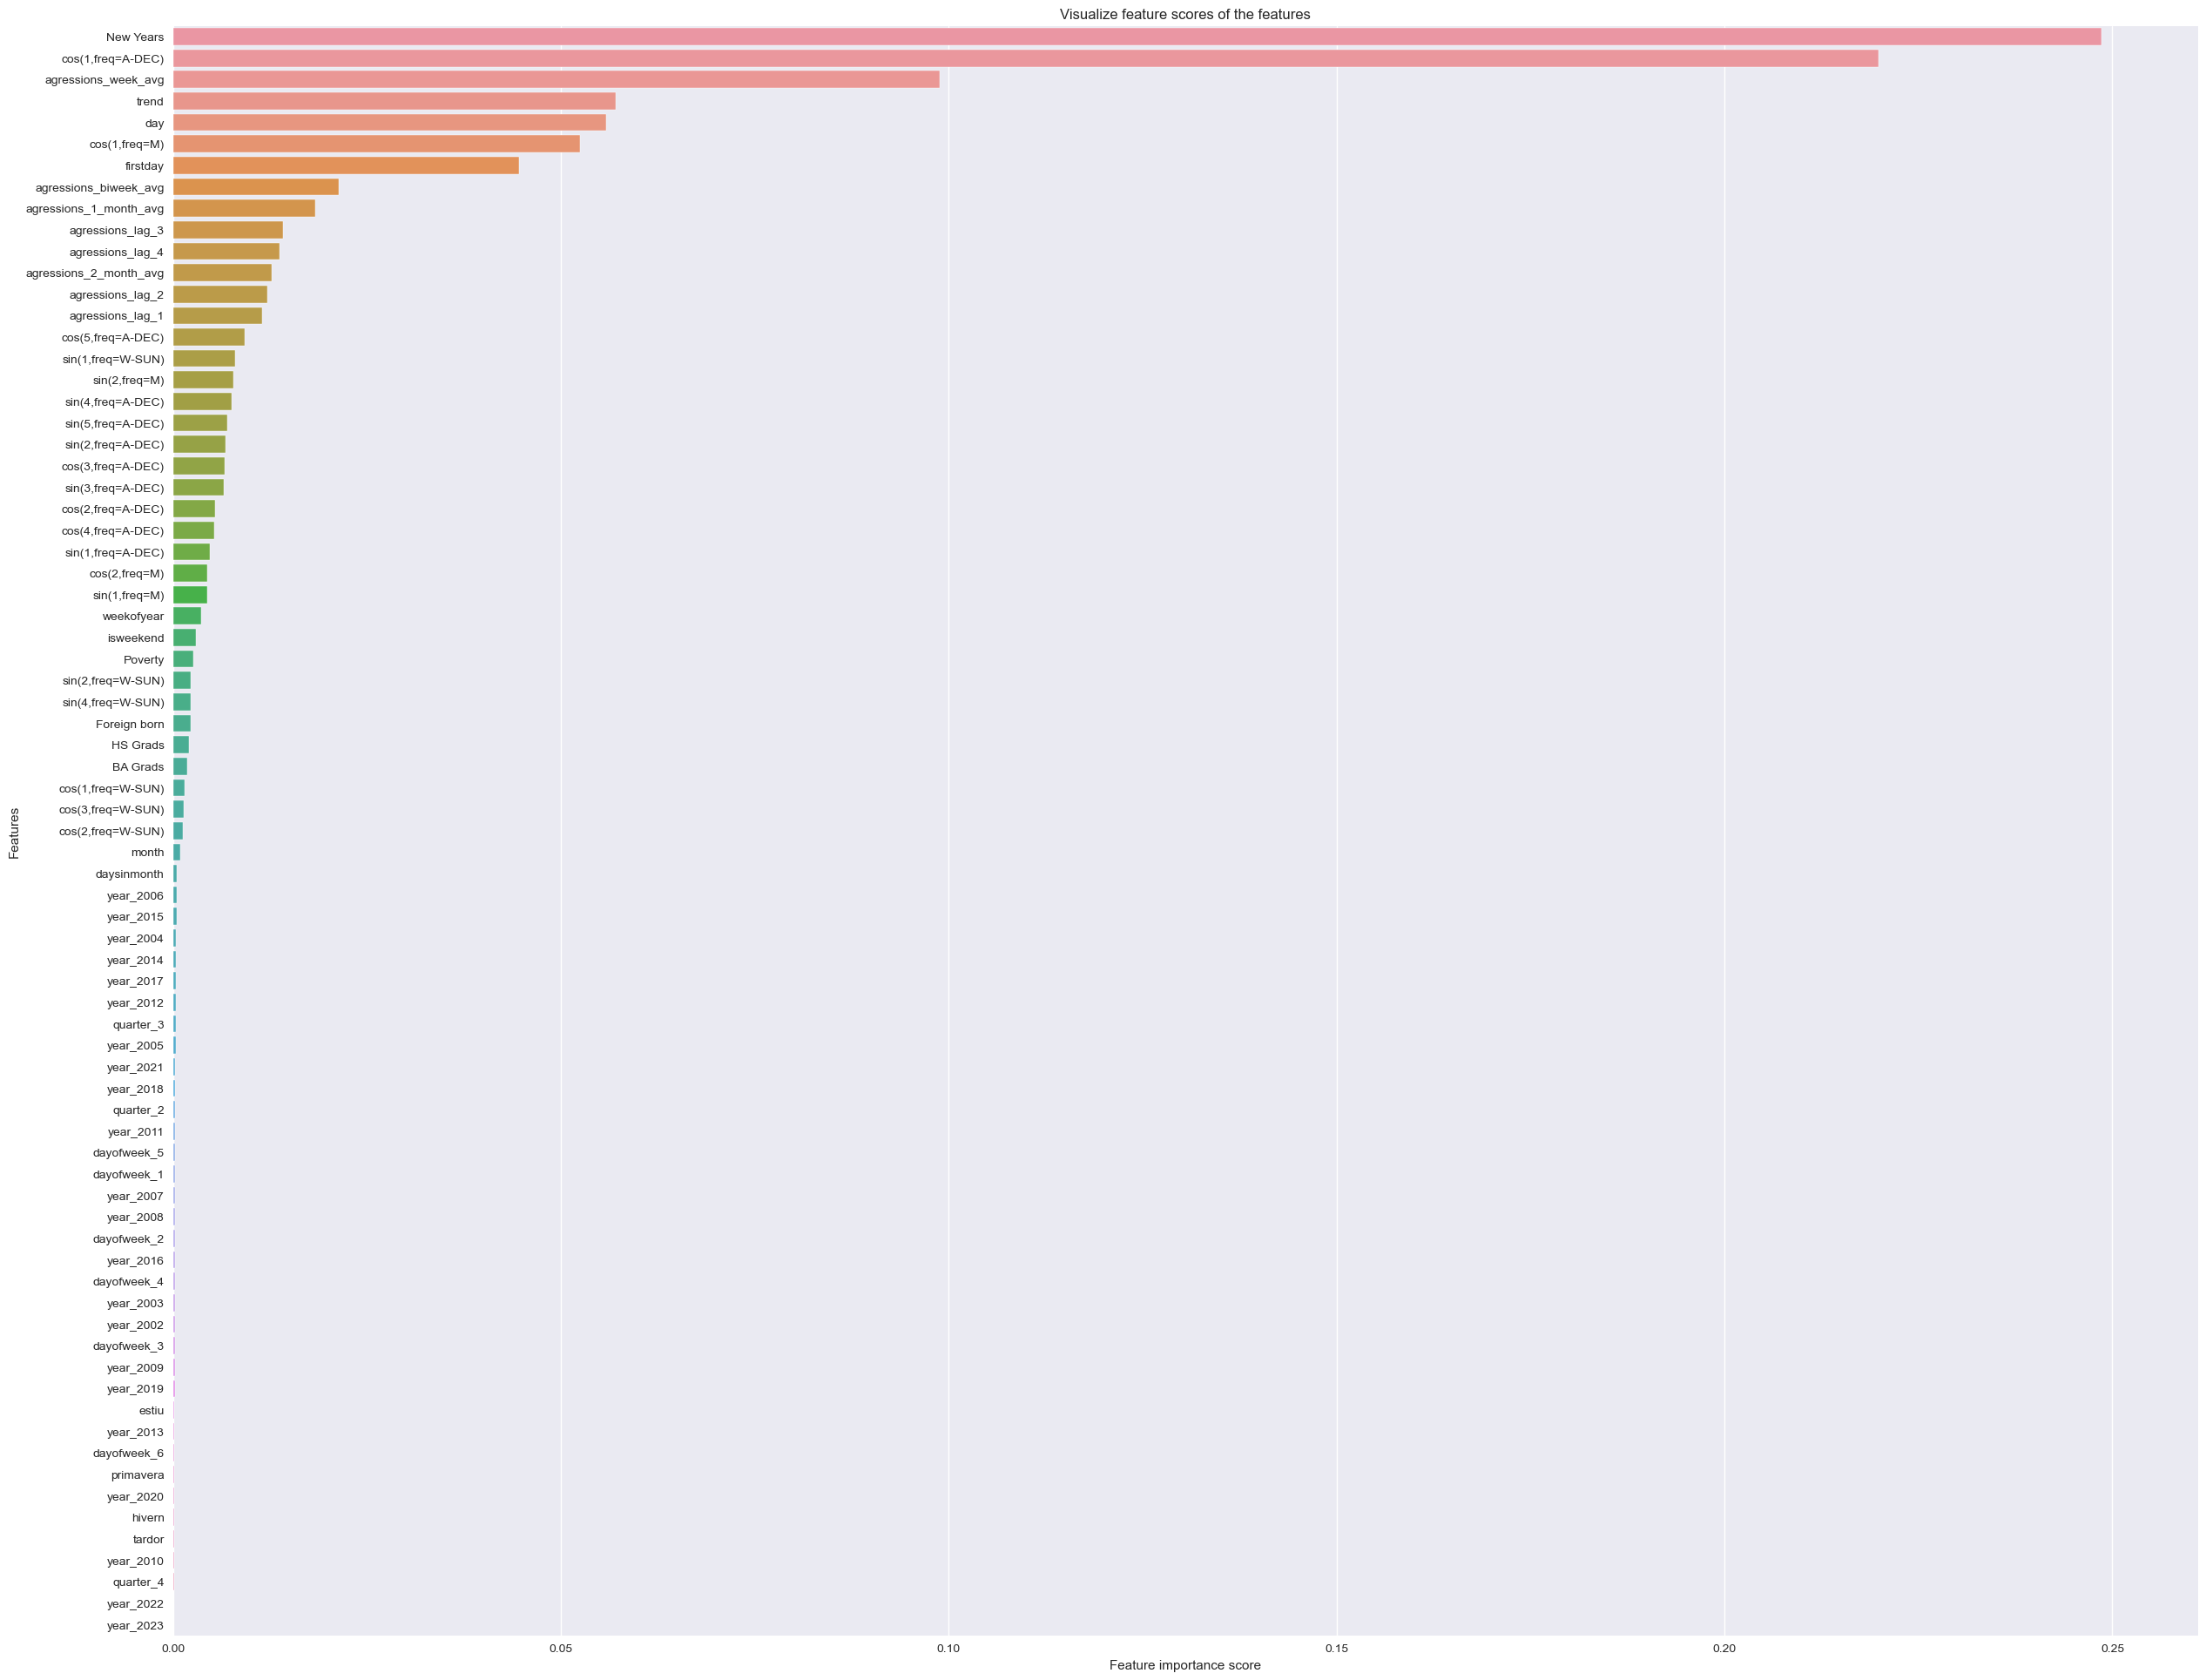

In [72]:
# Creating a seaborn bar plot
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

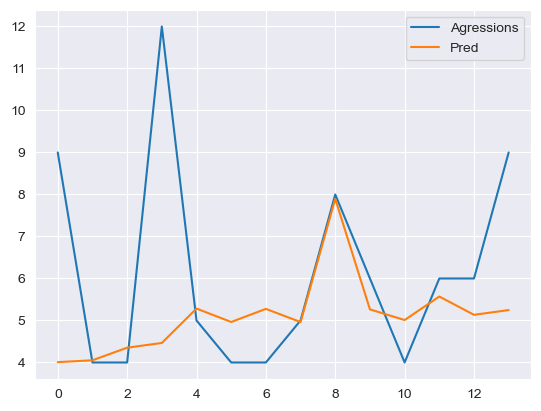

In [128]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [202]:
#14 ultimos dias de diciemnbre
nnf = new_df_dies.loc[(new_df_dies.index.year !=2023) & (new_df_dies.index.year>= 2017)]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

In [61]:

X= nnf.drop(columns = ['Agressions', 'New Years'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)

# weights = create_sample_weights(X_train, '2022-12-01')
model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
# f = df_prova.loc[df_prova.Dates.year!=2023]
# f =df_prova.groupby(df_prova.Dates).size()
# test['Agressions'] = f.iloc[-37:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2022-12-18         3.0  6.066090    3.428571   inf        inf  52.345994   
2022-12-19         5.0  5.870055    3.428571   inf        inf  52.345994   
2022-12-20         3.0  5.539621    3.428571   inf        inf  52.345994   
2022-12-21         0.0  5.045725    3.428571   inf        inf  52.345994   
2022-12-22         1.0  5.456579    3.428571   inf        inf  52.345994   
2022-12-23         4.0  4.828000    3.428571   inf        inf  52.345994   
2022-12-24         1.0  4.635450    3.428571   inf        inf  52.345994   
2022-12-25         4.0  4.819332    3.428571   inf        inf  52.345994   
2022-12-26         5.0  4.273963    3.428571   inf        inf  52.345994   
2022-12-27         5.0  4.224127    3.428571   inf        inf  52.345994   
2022-12-28         4.0  4.586732    3.428571   inf        inf  52.345994   
2022-12-29         4.0  4.741174    3.428571   inf        inf  52.345994   
2022-12-30         4.0  4.345524    3.428571   inf        inf  52.345994   
2022-12-31         5.0  4.349018    3.428571   inf        inf  52.345994   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2022-12-18   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-19   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-20   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-21   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-22   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-23   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-24   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-25   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-26   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-27   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-28   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-29   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-30   36.663021  1.791941  1.306122     78.571429          35.714286   
2022-12-31   36.663021  1.791941  1.306122     78.571429          35.714286   

                RMSE  RMSE mean  
Dates                            
2022-12-18  2.376481    1.59079  
2022-12-19  2.376481    1.59079  
2022-12-20  2.376481    1.59079  
2022-12-21  2.376481    1.59079  
2022-12-22  2.376481    1.59079  
2022-12-23  2.376481    1.59079  
2022-12-24  2.376481    1.59079  
2022-12-25  2.376481    1.59079  
2022-12-26  2.376481    1.59079  
2022-12-27  2.376481    1.59079  
2022-12-28  2.376481    1.59079  
2022-12-29  2.376481    1.59079  
2022-12-30  2.376481    1.59079  
2022-12-31  2.376481    1.59079

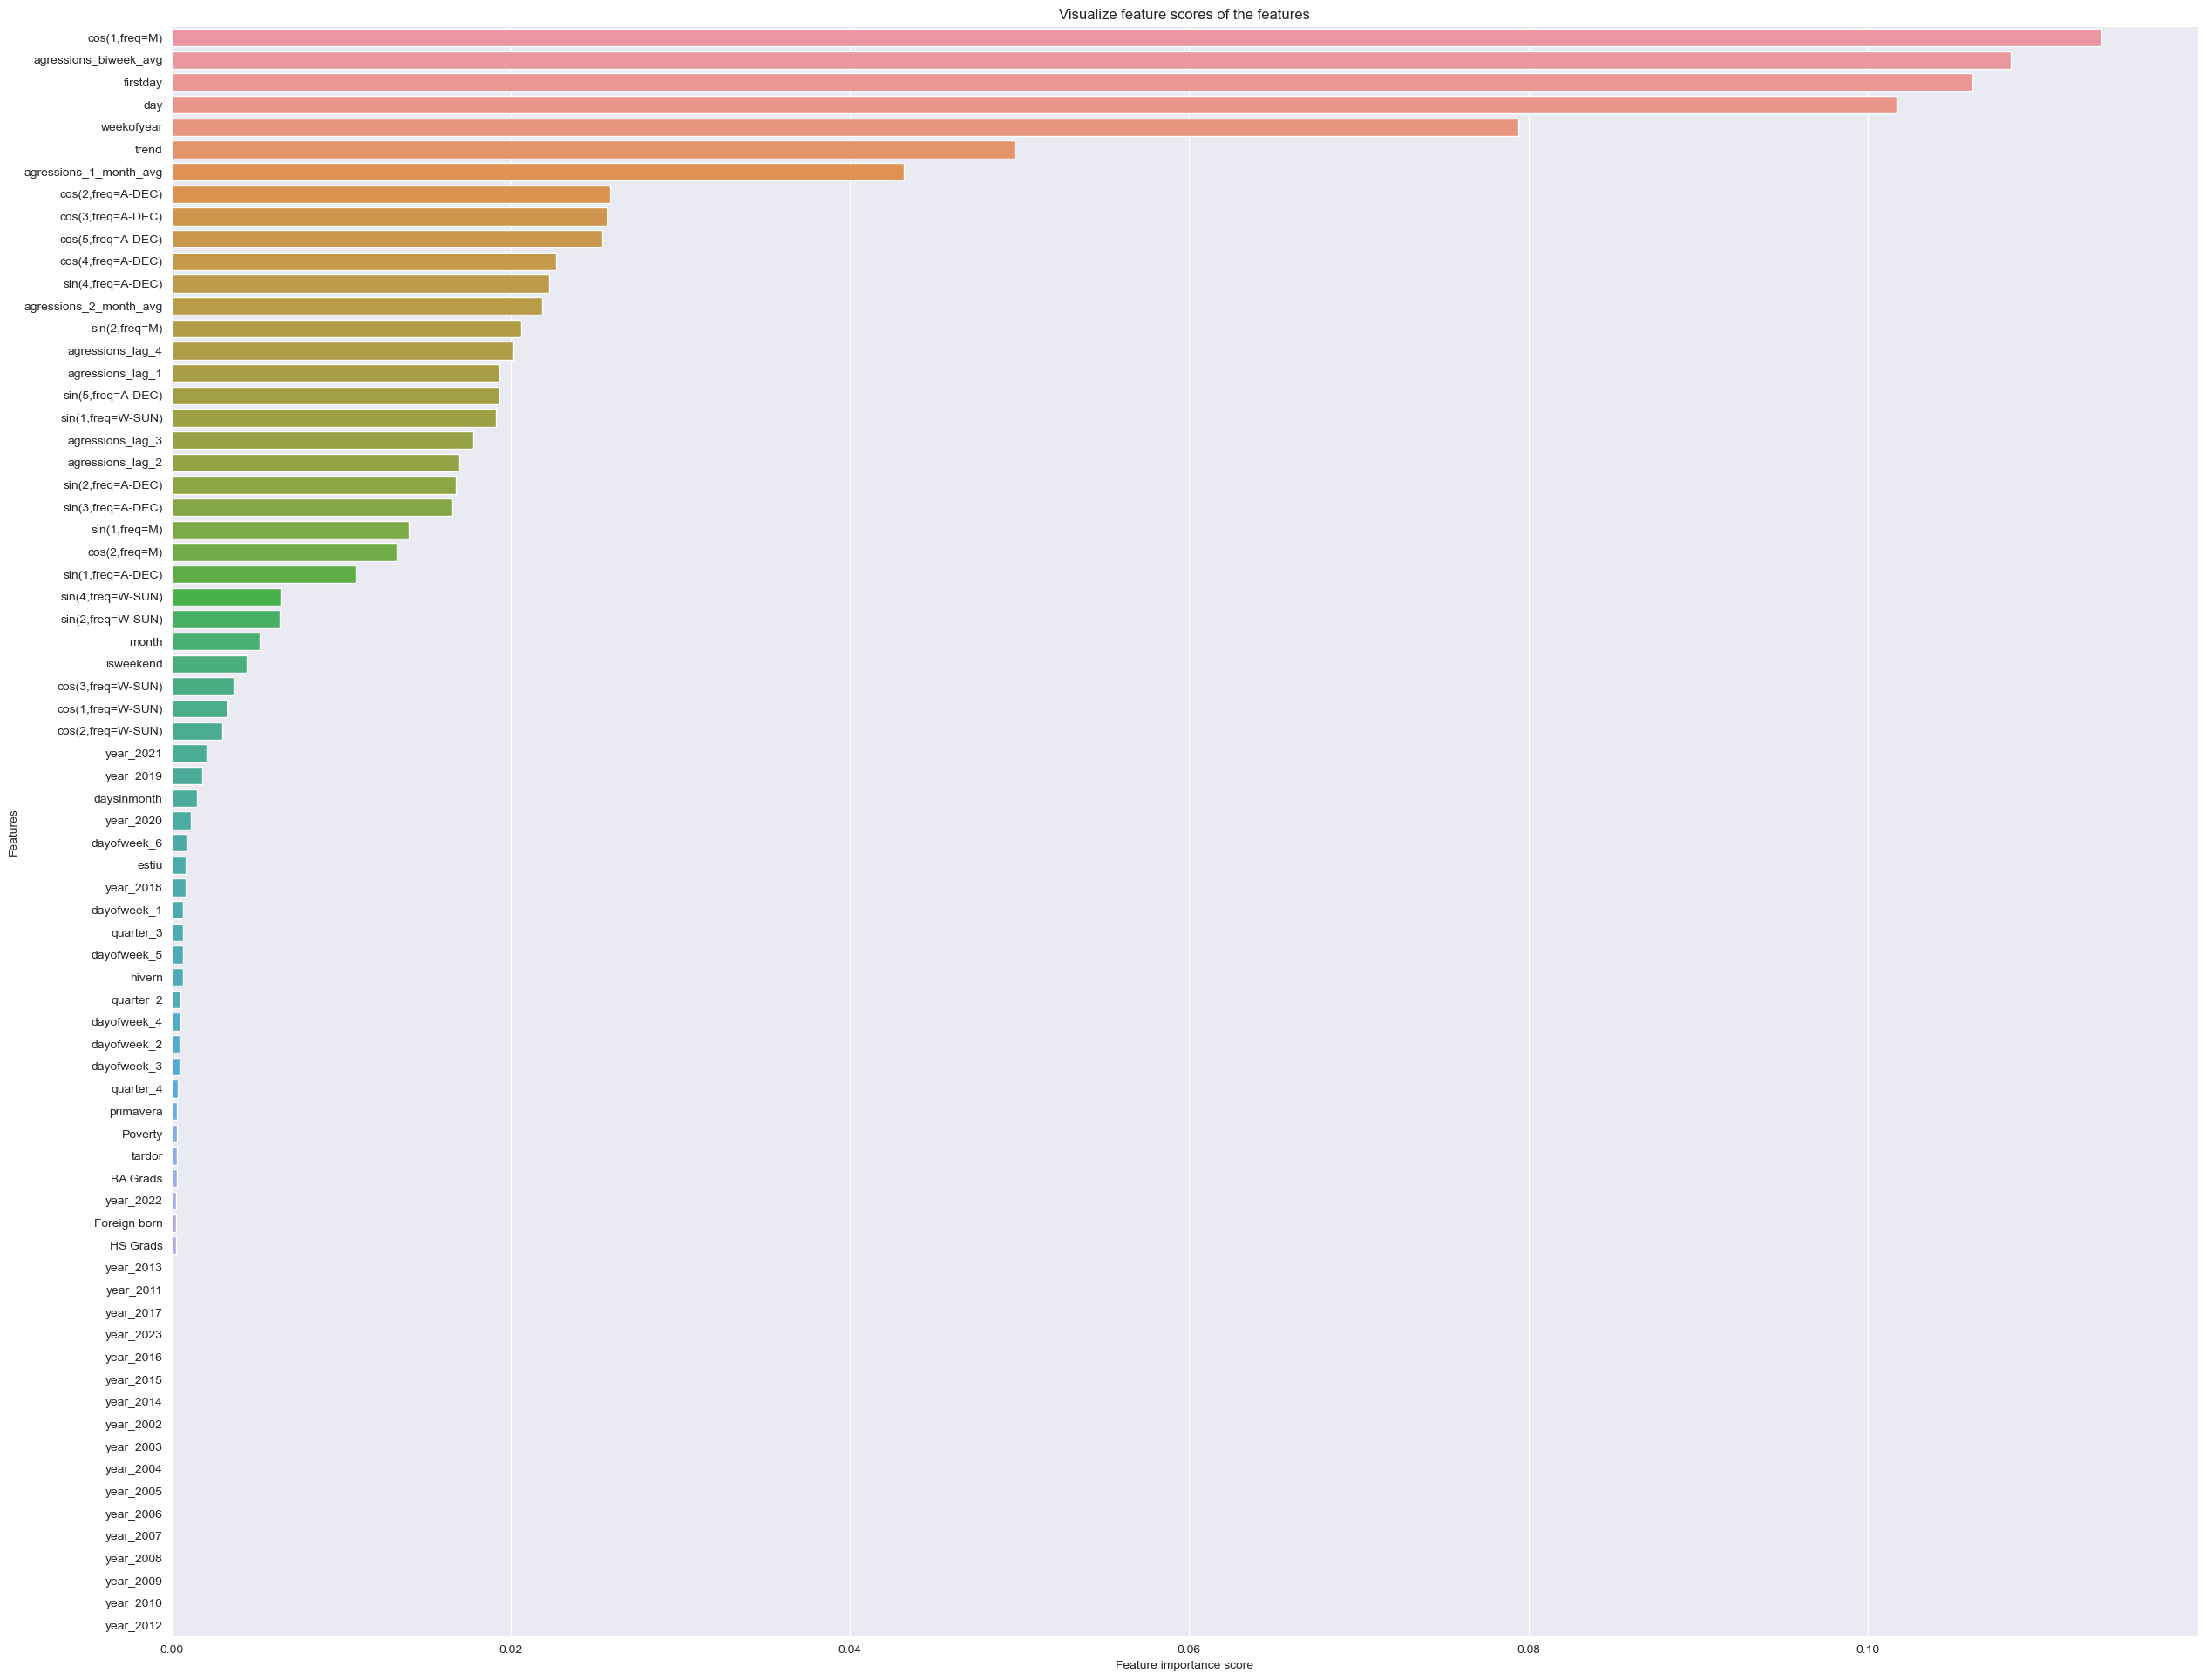

In [62]:
# Creating a seaborn bar plot
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

<AxesSubplot:xlabel='Dates'>

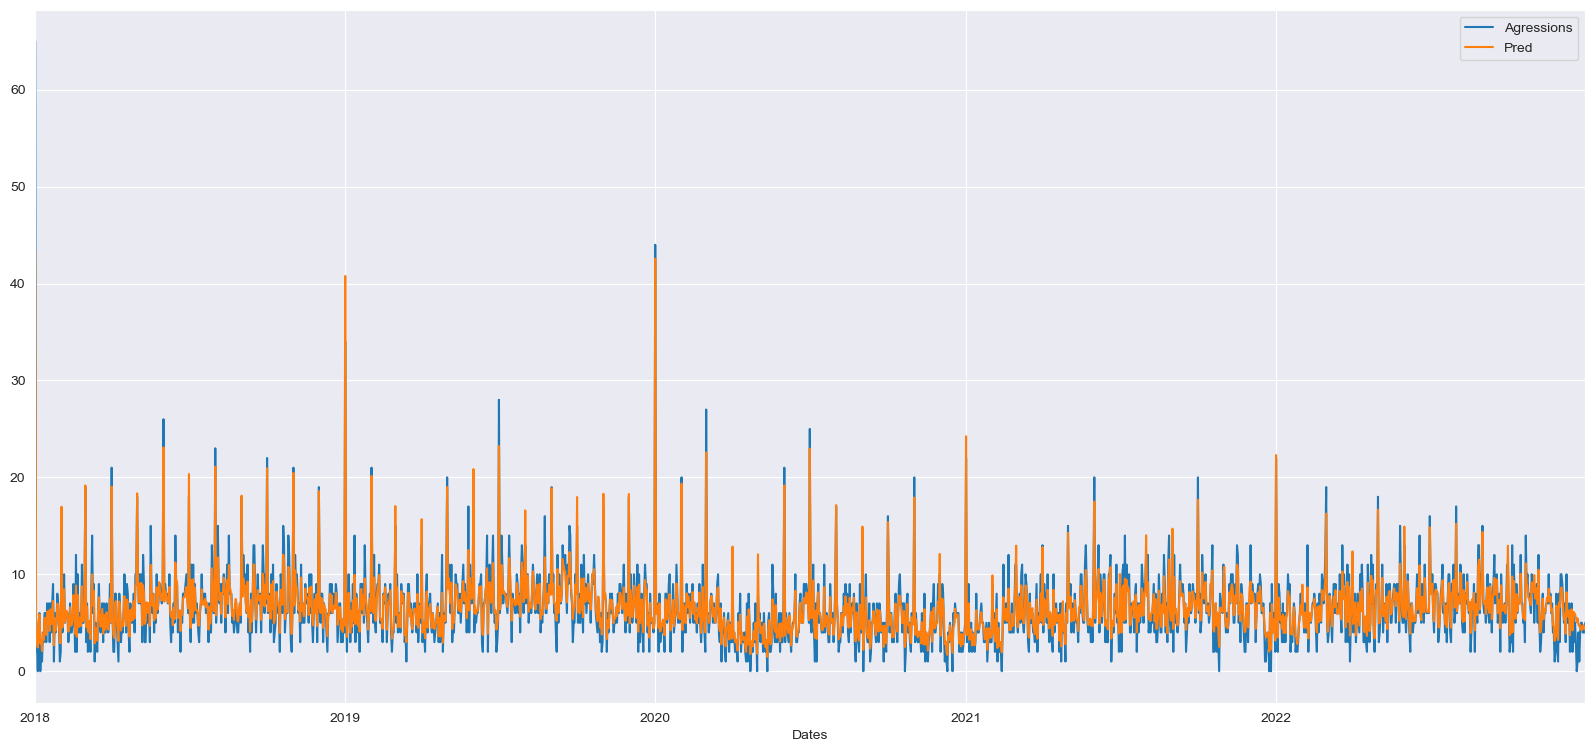

In [63]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-11]
d = d.set_index('Dates')
d

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
d.plot(ax=ax)

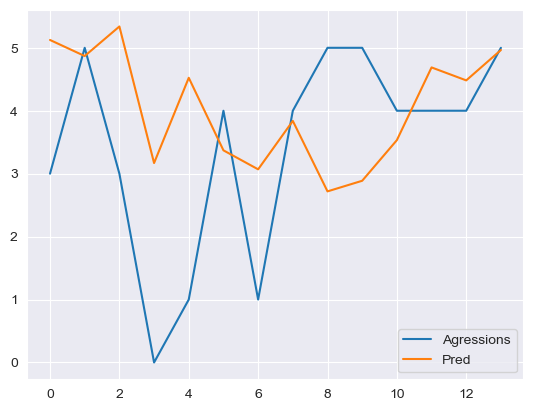

In [78]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [177]:
nnf = new_df_dies.loc[new_df_dies.index.year >=2017]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

In [181]:
#MEJOR ENERO
X= nnf.drop(columns = ['Agressions', 'New Years'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
# weights = create_sample_weights(X_train, '2023-01-01')
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

test = y_test.to_frame()
test['Pred']  = xg_pred_test_y
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions       Pred  Mean model       MAPE  MAPE mean  \
Dates                                                                 
2023-01-24           9   3.318645    5.857143  28.303385  33.718821   
2023-01-25           4   3.140037    5.857143  28.303385  33.718821   
2023-01-26           4   3.173428    5.857143  28.303385  33.718821   
2023-01-27          12   3.648169    5.857143  28.303385  33.718821   
2023-01-28           5   4.259130    5.857143  28.303385  33.718821   
2023-01-29           4   4.294036    5.857143  28.303385  33.718821   
2023-01-30           4   3.871274    5.857143  28.303385  33.718821   
2023-01-31           5   3.576068    5.857143  28.303385  33.718821   
2023-02-01           8  12.274116    5.857143  28.303385  33.718821   
2023-02-02           4   3.592997    5.857143  28.303385  33.718821   
2023-02-03           4   3.848856    5.857143  28.303385  33.718821   
2023-02-04           5   4.211697    5.857143  28.303385  33.718821   
2023-02-05           6   4.183637    5.857143  28.303385  33.718821   
2023-02-06           8   3.673980    5.857143  28.303385  33.718821   

                SMAPE  SMAPE mean       MAE  MAE mean  Metrica nomb  \
Dates                                                                 
2023-01-24  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-25  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-26  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-27  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-28  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-29  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-30  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-01-31  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-01  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-02  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-03  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-04  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-05  34.951902   38.522659  2.147874  1.959184     14.285714   
2023-02-06  34.951902   38.522659  2.147874  1.959184     14.285714   

            Metrica nomb mean      RMSE  RMSE mean        MSE  
Dates                                                          
2023-01-24          64.285714  3.242846   2.386185  10.516053  
2023-01-25          64.285714  3.242846   2.386185  10.516053  
2023-01-26          64.285714  3.242846   2.386185  10.516053  
2023-01-27          64.285714  3.242846   2.386185  10.516053  
2023-01-28          64.285714  3.242846   2.386185  10.516053  
2023-01-29          64.285714  3.242846   2.386185  10.516053  
2023-01-30          64.285714  3.242846   2.386185  10.516053  
2023-01-31          64.285714  3.242846   2.386185  10.516053  
2023-02-01          64.285714  3.242846   2.386185  10.516053  
2023-02-02          64.285714  3.242846   2.386185  10.516053  
2023-02-03          64.285714  3.242846   2.386185  10.516053  
2023-02-04          64.285714  3.242846   2.386185  10.516053  
2023-02-05          64.285714  3.242846   2.386185  10.516053  
2023-02-06          64.285714  3.242846   2.386185  10.516053

In [183]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train_y
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('Dates')
d = d[-24:]

dies_gener = pd.DataFrame()
dies_gener = d[['Agressions', 'Pred']]
dies_gener = dies_gener.rename(columns={'Pred':'XGBoost'})


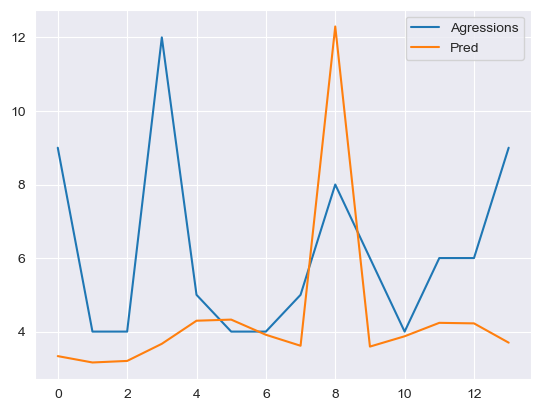

In [110]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [203]:
#MEJOR DICIEMBRE

X= nnf.drop(columns = ['Agressions', 'New Years'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
# weights = create_sample_weights(X_train, '2023-01-01')
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

test = y_test.to_frame()
test['Pred']  = xg_pred_test_y
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2022-12-18         3.0  5.211168    3.428571   inf        inf  45.041249   
2022-12-19         5.0  4.614480    3.428571   inf        inf  45.041249   
2022-12-20         3.0  4.737120    3.428571   inf        inf  45.041249   
2022-12-21         0.0  3.836506    3.428571   inf        inf  45.041249   
2022-12-22         1.0  3.776090    3.428571   inf        inf  45.041249   
2022-12-23         4.0  3.813182    3.428571   inf        inf  45.041249   
2022-12-24         1.0  4.101409    3.428571   inf        inf  45.041249   
2022-12-25         4.0  4.040656    3.428571   inf        inf  45.041249   
2022-12-26         5.0  3.684177    3.428571   inf        inf  45.041249   
2022-12-27         5.0  3.560190    3.428571   inf        inf  45.041249   
2022-12-28         4.0  3.830437    3.428571   inf        inf  45.041249   
2022-12-29         4.0  4.129337    3.428571   inf        inf  45.041249   
2022-12-30         4.0  4.326001    3.428571   inf        inf  45.041249   
2022-12-31         5.0  4.956375    3.428571   inf        inf  45.041249   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2022-12-18   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-19   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-20   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-21   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-22   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-23   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-24   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-25   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-26   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-27   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-28   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-29   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-30   43.252933  1.264246  1.306122     57.142857          35.714286   
2022-12-31   43.252933  1.264246  1.306122     57.142857          35.714286   

               RMSE  RMSE mean       MSE  
Dates                                     
2022-12-18  1.77471    1.59079  3.149595  
2022-12-19  1.77471    1.59079  3.149595  
2022-12-20  1.77471    1.59079  3.149595  
2022-12-21  1.77471    1.59079  3.149595  
2022-12-22  1.77471    1.59079  3.149595  
2022-12-23  1.77471    1.59079  3.149595  
2022-12-24  1.77471    1.59079  3.149595  
2022-12-25  1.77471    1.59079  3.149595  
2022-12-26  1.77471    1.59079  3.149595  
2022-12-27  1.77471    1.59079  3.149595  
2022-12-28  1.77471    1.59079  3.149595  
2022-12-29  1.77471    1.59079  3.149595  
2022-12-30  1.77471    1.59079  3.149595  
2022-12-31  1.77471    1.59079  3.149595

In [32]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train_y
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('Dates')
d = d[-24:]

dies_desembre = pd.DataFrame()
dies_desembre = d[['Agressions', 'Pred']]
dies_desembre = dies_desembre.rename(columns={'Pred':'XGBoost'})

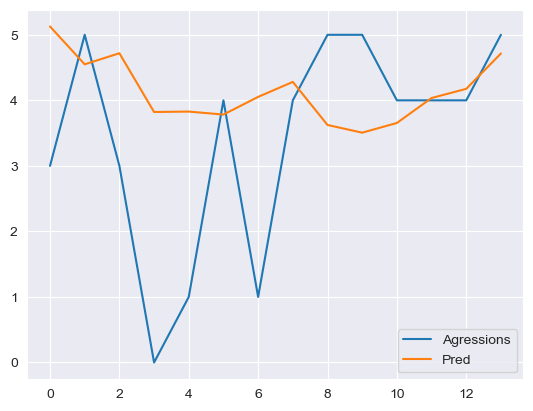

In [126]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [187]:
#MEJOR ENERO
X= new_df_dies.drop(columns = 'Agressions')
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)    
    
# RandomForestRegressor
model = RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(subsample = 0.6, n_estimators = 100, max_depth=5, learning_rate = 0.1, colsample_bytree = 0.5, colsample_bylevel = 0.4, random_state=0)
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.2 + rf_pred_train * 0.8
total_pred_test = xg_pred_test * 0.2 + rf_pred_test * 0.8
        
test = y_test.to_frame()
test['Pred']  = total_pred_test
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions       Pred  Mean model      MAPE  MAPE mean      SMAPE  \
Dates                                                                           
2023-01-24           9   4.034862    5.857143  26.56245  33.718821  28.508324   
2023-01-25           4   3.884859    5.857143  26.56245  33.718821  28.508324   
2023-01-26           4   4.475051    5.857143  26.56245  33.718821  28.508324   
2023-01-27          12   4.749581    5.857143  26.56245  33.718821  28.508324   
2023-01-28           5   5.443732    5.857143  26.56245  33.718821  28.508324   
2023-01-29           4   5.259055    5.857143  26.56245  33.718821  28.508324   
2023-01-30           4   5.406851    5.857143  26.56245  33.718821  28.508324   
2023-01-31           5   5.130722    5.857143  26.56245  33.718821  28.508324   
2023-02-01           8  11.241860    5.857143  26.56245  33.718821  28.508324   
2023-02-02           4   5.409665    5.857143  26.56245  33.718821  28.508324   
2023-02-03           4   5.309757    5.857143  26.56245  33.718821  28.508324   
2023-02-04           5   5.501325    5.857143  26.56245  33.718821  28.508324   
2023-02-05           6   5.392620    5.857143  26.56245  33.718821  28.508324   
2023-02-06           8   5.221111    5.857143  26.56245  33.718821  28.508324   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-25   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-26   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-27   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-28   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-29   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-30   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-01-31   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-01   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-02   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-03   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-04   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-05   34.166522  1.849642  1.959184     64.285714          64.285714   
2023-02-06   34.166522  1.849642  1.959184     64.285714          64.285714   

               RMSE  RMSE mean       MSE  
Dates                                     
2023-01-24  2.72283   2.386185  7.413805  
2023-01-25  2.72283   2.386185  7.413805  
2023-01-26  2.72283   2.386185  7.413805  
2023-01-27  2.72283   2.386185  7.413805  
2023-01-28  2.72283   2.386185  7.413805  
2023-01-29  2.72283   2.386185  7.413805  
2023-01-30  2.72283   2.386185  7.413805  
2023-01-31  2.72283   2.386185  7.413805  
2023-02-01  2.72283   2.386185  7.413805  
2023-02-02  2.72283   2.386185  7.413805  
2023-02-03  2.72283   2.386185  7.413805  
2023-02-04  2.72283   2.386185  7.413805  
2023-02-05  2.72283   2.386185  7.413805  
2023-02-06  2.72283   2.386185  7.413805

In [188]:
train = y_train.to_frame()
train['Pred']  = total_pred_train
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('Dates')
d = d[-24:]

dies_gener['Average Model'] = d['Pred']

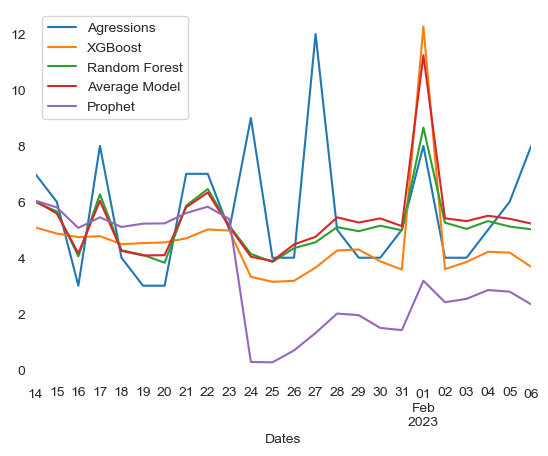

In [200]:
plt.rcParams['axes.facecolor'] = 'white'

dies_gener.plot()
plt.show()

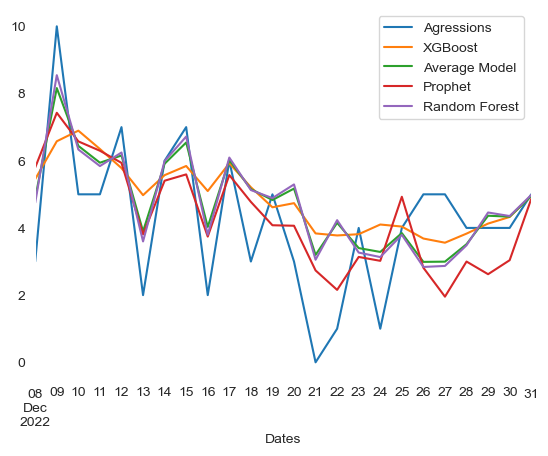

In [224]:
plt.rcParams['axes.facecolor'] = 'white'

dies_desembre.plot()
plt.show()

(-15.0, 15.0)

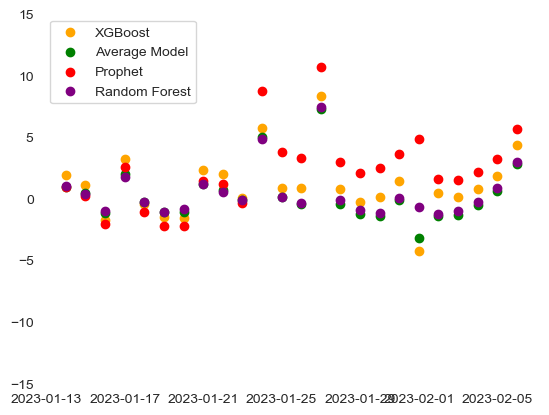

In [201]:
dies_gener['res_XGBoost'] = dies_gener['Agressions'] - dies_gener['XGBoost']
dies_gener['res_Avg_Model'] = dies_gener['Agressions'] - dies_gener['Average Model']
dies_gener['res_Prophet'] = dies_gener['Agressions'] - dies_gener['Prophet']
dies_gener['res_RF'] = dies_gener['Agressions'] - dies_gener['Random Forest']

fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
ax1.scatter(x=dies_gener.index, y= dies_gener['res_XGBoost'], label='XGBoost', color='orange')
ax1.scatter(x=dies_gener.index, y= dies_gener['res_Avg_Model'], label='Average Model', color='green')
ax1.scatter(x=dies_gener.index, y= dies_gener['res_Prophet'], label='Prophet', color='red')
ax1.scatter(x=dies_gener.index, y= dies_gener['res_RF'], label='Random Forest', color='purple')

plt.legend(loc='upper left')
plt.ylim(-15,15)

(-5.0, 5.0)

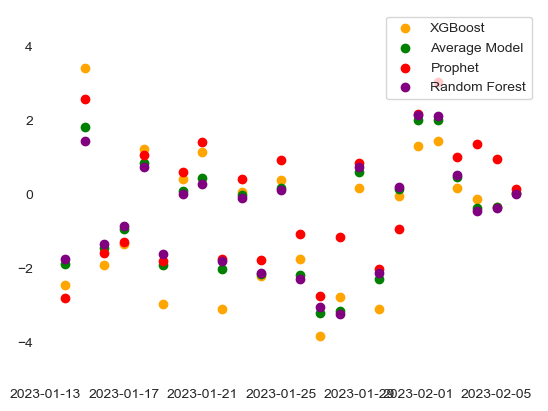

In [225]:
dies_desembre['res_XGBoost'] = dies_desembre['Agressions'] - dies_desembre['XGBoost']
dies_desembre['res_Avg_Model'] = dies_desembre['Agressions'] - dies_desembre['Average Model']
dies_desembre['res_Prophet'] = dies_desembre['Agressions'] - dies_desembre['Prophet']
dies_desembre['res_RF'] = dies_desembre['Agressions'] - dies_desembre['Random Forest']

fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
ax1.scatter(x=dies_gener.index, y= dies_desembre['res_XGBoost'], label='XGBoost', color='orange')
ax1.scatter(x=dies_gener.index, y= dies_desembre['res_Avg_Model'], label='Average Model', color='green')
ax1.scatter(x=dies_gener.index, y= dies_desembre['res_Prophet'], label='Prophet', color='red')
ax1.scatter(x=dies_gener.index, y= dies_desembre['res_RF'], label='Random Forest', color='purple')

plt.legend(loc='upper right')
plt.ylim(-5,5)

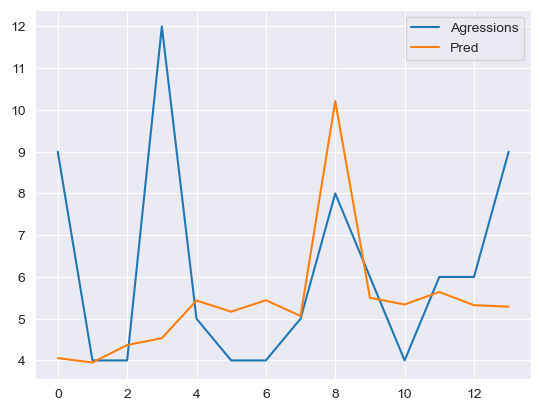

In [155]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [30]:
nnf = new_df_dies[new_df_dies.index.year !=2023]

In [33]:
#MEJOR DICIEMBRE
X= nnf.drop(columns = 'Agressions')
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)    
    
# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.2 + rf_pred_train * 0.8
total_pred_test = xg_pred_test * 0.2 + rf_pred_test * 0.8
        
test = y_test.to_frame()
test['Pred']  = total_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2022-12-18         3.0  5.235430    3.428571   inf        inf  55.369578   
2022-12-19         5.0  4.304456    3.428571   inf        inf  55.369578   
2022-12-20         3.0  4.853873    3.428571   inf        inf  55.369578   
2022-12-21         0.0  2.763898    3.428571   inf        inf  55.369578   
2022-12-22         1.0  3.670422    3.428571   inf        inf  55.369578   
2022-12-23         4.0  3.509969    3.428571   inf        inf  55.369578   
2022-12-24         1.0  3.440692    3.428571   inf        inf  55.369578   
2022-12-25         4.0  3.219830    3.428571   inf        inf  55.369578   
2022-12-26         5.0  2.506387    3.428571   inf        inf  55.369578   
2022-12-27         5.0  2.414841    3.428571   inf        inf  55.369578   
2022-12-28         4.0  2.834084    3.428571   inf        inf  55.369578   
2022-12-29         4.0  3.750167    3.428571   inf        inf  55.369578   
2022-12-30         4.0  3.989872    3.428571   inf        inf  55.369578   
2022-12-31         5.0  6.286367    3.428571   inf        inf  55.369578   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2022-12-18   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-19   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-20   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-21   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-22   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-23   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-24   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-25   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-26   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-27   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-28   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-29   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-30   50.392451  1.551505  1.306122     42.857143          35.714286   
2022-12-31   50.392451  1.551505  1.306122     42.857143          35.714286   

                RMSE  RMSE mean       MSE  
Dates                                      
2022-12-18  1.821922    1.59079  3.319401  
2022-12-19  1.821922    1.59079  3.319401  
2022-12-20  1.821922    1.59079  3.319401  
2022-12-21  1.821922    1.59079  3.319401  
2022-12-22  1.821922    1.59079  3.319401  
2022-12-23  1.821922    1.59079  3.319401  
2022-12-24  1.821922    1.59079  3.319401  
2022-12-25  1.821922    1.59079  3.319401  
2022-12-26  1.821922    1.59079  3.319401  
2022-12-27  1.821922    1.59079  3.319401  
2022-12-28  1.821922    1.59079  3.319401  
2022-12-29  1.821922    1.59079  3.319401  
2022-12-30  1.821922    1.59079  3.319401  
2022-12-31  1.821922    1.59079  3.319401

In [34]:
train = y_train.to_frame()
train['Pred']  = total_pred_train
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('Dates')
d = d[-24:]

dies_desembre['Average Model'] = d['Pred']

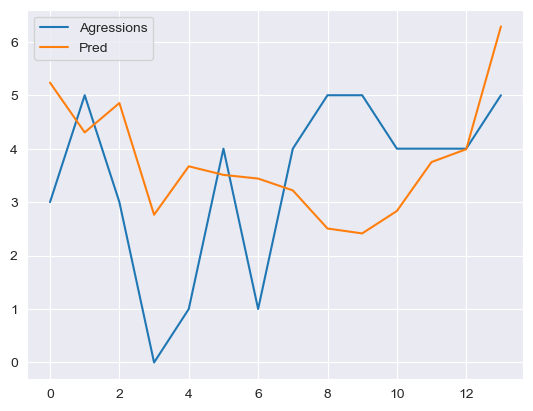

In [175]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [214]:
#MEJOR ENERO

X= new_df_dies.drop(columns = 'Agressions')
y = new_df_dies['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

# Prophet
model = Prophet(holidays = hol, 
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'multiplicative',
                yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()

test.loc[test['Pred'] < 0, 'Pred'] = 0


test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model       MAPE  MAPE mean  \
ds                                                                   
2023-01-24  0.273267           9    5.857143  65.180239  33.718821   
2023-01-25  0.260353           4    5.857143  65.180239  33.718821   
2023-01-26  0.685228           4    5.857143  65.180239  33.718821   
2023-01-27  1.310210          12    5.857143  65.180239  33.718821   
2023-01-28  2.003691           5    5.857143  65.180239  33.718821   
2023-01-29  1.947108           4    5.857143  65.180239  33.718821   
2023-01-30  1.489934           4    5.857143  65.180239  33.718821   
2023-01-31  1.412084           5    5.857143  65.180239  33.718821   
2023-02-01  3.176868           8    5.857143  65.180239  33.718821   
2023-02-02  2.409200           4    5.857143  65.180239  33.718821   
2023-02-03  2.529257           4    5.857143  65.180239  33.718821   
2023-02-04  2.844064           5    5.857143  65.180239  33.718821   
2023-02-05  2.787469           6    5.857143  65.180239  33.718821   
2023-02-06  2.330359           8    5.857143  65.180239  33.718821   

                 SMAPE  SMAPE mean       MAE  MAE mean  Metrica nomb  \
ds                                                                     
2023-01-24  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-25  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-26  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-27  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-28  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-29  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-30  103.049894   51.974657  4.038636  1.959184           0.0   
2023-01-31  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-01  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-02  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-03  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-04  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-05  103.049894   51.974657  4.038636  1.959184           0.0   
2023-02-06  103.049894   51.974657  4.038636  1.959184           0.0   

            Metrica nomb mean     RMSE  RMSE mean        MSE  
ds                                                            
2023-01-24          64.285714  4.80205   2.386185  23.059681  
2023-01-25          64.285714  4.80205   2.386185  23.059681  
2023-01-26          64.285714  4.80205   2.386185  23.059681  
2023-01-27          64.285714  4.80205   2.386185  23.059681  
2023-01-28          64.285714  4.80205   2.386185  23.059681  
2023-01-29          64.285714  4.80205   2.386185  23.059681  
2023-01-30          64.285714  4.80205   2.386185  23.059681  
2023-01-31          64.285714  4.80205   2.386185  23.059681  
2023-02-01          64.285714  4.80205   2.386185  23.059681  
2023-02-02          64.285714  4.80205   2.386185  23.059681  
2023-02-03          64.285714  4.80205   2.386185  23.059681  
2023-02-04          64.285714  4.80205   2.386185  23.059681  
2023-02-05          64.285714  4.80205   2.386185  23.059681  
2023-02-06          64.285714  4.80205   2.386185  23.059681

In [215]:
p_pred_train_y = p_pred_train_y.set_index('ds')

In [216]:
train = y_train.to_frame()
train['Pred']  = p_pred_train_y['yhat']
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['ds','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('level_0').rename(columns={'level_0':'Dates'})
d = d[-24:]

dies_gener['Prophet'] = d['Pred']

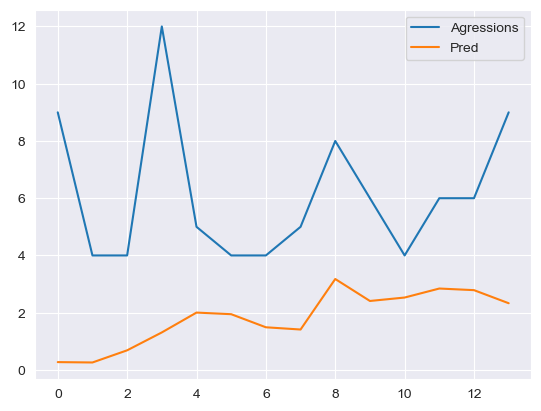

In [124]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [36]:
year = [x for x in range(2001, 2024, 1)]
md = ['01-02', '01-16', '02-13', '02-20', '03-06', '05-29', '06-19', '07-04', '09-04', '10-09','11-10', '11-23', '12-25']
holidays = []
for i in year:
    for j in md:
        string = str(i) + '-' + j
        holidays.append(string)

In [37]:
hol = pd.DataFrame()

hol['ds'] = holidays
hol['holiday'] = 'Holiday'
hol['ds'] = pd.to_datetime(hol['ds'])
hol

ds  holiday
0   2001-01-02  Holiday
1   2001-01-16  Holiday
2   2001-02-13  Holiday
3   2001-02-20  Holiday
4   2001-03-06  Holiday
..         ...      ...
294 2023-09-04  Holiday
295 2023-10-09  Holiday
296 2023-11-10  Holiday
297 2023-11-23  Holiday
298 2023-12-25  Holiday

[299 rows x 2 columns]

In [38]:
#MEJOR DICIEMBRE

X= nnf.drop(columns = 'Agressions')
y = nnf['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

# Prophet
model = Prophet(holidays = hol,
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 5,
                seasonality_prior_scale = 5,
                seasonality_mode = 'additive',
                yearly_seasonality = True,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
test['Agressions'] = y_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model  MAPE  MAPE mean      SMAPE  \
ds                                                                         
2022-12-18  4.914002         3.0    3.428571   inf        inf  49.605262   
2022-12-19  3.999426         5.0    3.428571   inf        inf  49.605262   
2022-12-20  4.182530         3.0    3.428571   inf        inf  49.605262   
2022-12-21  3.159695         0.0    3.428571   inf        inf  49.605262   
2022-12-22  2.910865         1.0    3.428571   inf        inf  49.605262   
2022-12-23  3.586904         4.0    3.428571   inf        inf  49.605262   
2022-12-24  3.904844         1.0    3.428571   inf        inf  49.605262   
2022-12-25  4.535223         4.0    3.428571   inf        inf  49.605262   
2022-12-26  3.031700         5.0    3.428571   inf        inf  49.605262   
2022-12-27  2.844310         5.0    3.428571   inf        inf  49.605262   
2022-12-28  3.282806         4.0    3.428571   inf        inf  49.605262   
2022-12-29  3.358833         4.0    3.428571   inf        inf  49.605262   
2022-12-30  3.782297         4.0    3.428571   inf        inf  49.605262   
2022-12-31  5.237930         5.0    3.428571   inf        inf  49.605262   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                            
2022-12-18   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-19   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-20   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-21   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-22   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-23   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-24   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-25   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-26   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-27   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-28   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-29   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-30   48.727573  1.354201  1.306122          50.0          35.714286   
2022-12-31   48.727573  1.354201  1.306122          50.0          35.714286   

                RMSE  RMSE mean       MSE  
ds                                         
2022-12-18  1.650626    1.59079  2.724565  
2022-12-19  1.650626    1.59079  2.724565  
2022-12-20  1.650626    1.59079  2.724565  
2022-12-21  1.650626    1.59079  2.724565  
2022-12-22  1.650626    1.59079  2.724565  
2022-12-23  1.650626    1.59079  2.724565  
2022-12-24  1.650626    1.59079  2.724565  
2022-12-25  1.650626    1.59079  2.724565  
2022-12-26  1.650626    1.59079  2.724565  
2022-12-27  1.650626    1.59079  2.724565  
2022-12-28  1.650626    1.59079  2.724565  
2022-12-29  1.650626    1.59079  2.724565  
2022-12-30  1.650626    1.59079  2.724565  
2022-12-31  1.650626    1.59079  2.724565

In [39]:
p_pred_train_y=p_pred_train_y.set_index('ds')
train = y_train.to_frame()
train['Pred']  = p_pred_train_y['yhat']
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['ds','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('level_0').rename(columns={'level_0':'Dates'})
d = d[-24:]

dies_desembre['Prophet'] = d['Pred']
dies_desembre

Agressions   XGBoost  Average Model   Prophet
Dates                                                    
2022-12-08         3.0  5.592759       4.972133  5.415401
2022-12-09        10.0  6.215531       8.473720  6.430225
2022-12-10         5.0  6.830405       6.255543  6.454200
2022-12-11         5.0  5.989652       5.840286  5.904930
2022-12-12         7.0  5.362611       5.880057  5.246717
2022-12-13         2.0  5.063727       3.669514  4.304629
2022-12-14         6.0  5.180110       5.862838  4.850304
2022-12-15         7.0  5.642812       6.530693  5.258514
2022-12-16         2.0  4.946269       3.752092  4.373813
2022-12-17         6.0  5.926549       6.095576  5.678766
2022-12-18         3.0  5.249505       5.235430  4.914002
2022-12-19         5.0  4.190883       4.304456  3.999426
2022-12-20         3.0  4.287557       4.853873  4.182530
2022-12-21         0.0  3.453882       2.763898  3.159695
2022-12-22         1.0  3.408537       3.670422  2.910865
2022-12-23         4.0  3.614137       3.509969  3.586904
2022-12-24         1.0  4.204781       3.440692  3.904844
2022-12-25         4.0  4.081614       3.219830  4.535223
2022-12-26         5.0  3.365299       2.506387  3.031700
2022-12-27         5.0  3.316170       2.414841  2.844310
2022-12-28         4.0  3.329285       2.834084  3.282806
2022-12-29         4.0  3.689929       3.750167  3.358833
2022-12-30         4.0  3.916649       3.989872  3.782297
2022-12-31         5.0  5.076131       6.286367  5.237930

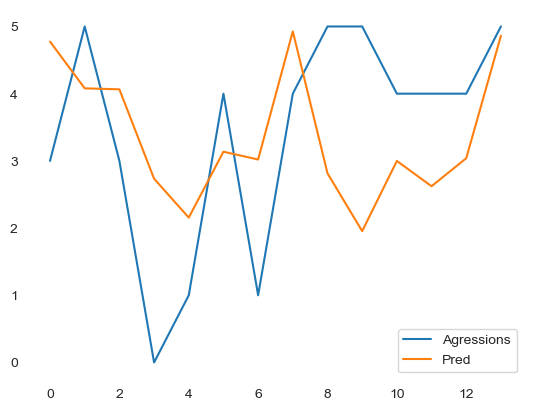

In [220]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

### Feature Selection

In [199]:
nnf = new_df_dies.loc[new_df_dies.index.year >=2017]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

In [207]:
#Feature Selection
X= new_df_dies.drop(columns = 'Agressions')
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

sel = SelectFromModel(RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0))
sel.fit(X_train, y_train)
selected_feat=X_train.columns[(sel.get_support())]
model= RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0)
model.fit(X_train[selected_feat], y_train)
rf_pred_train_y = model.predict(X_train[selected_feat]) 
rf_pred_test_y = model.predict(X_test[selected_feat])

selected_feat

Index(['New Years', 'agressions_lag_3', 'agressions_lag_4',
       'agressions_week_avg', 'agressions_biweek_avg',
       'agressions_1_month_avg', 'day', 'firstday', 'trend',
       'cos(1,freq=A-DEC)', 'cos(1,freq=M)'],
      dtype='object')

In [52]:
test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model       MAPE  MAPE mean      SMAPE  \
Dates                                                                           
2023-01-24           9  4.393099    6.142857  21.087955  32.587868  24.188987   
2023-01-25           4  4.371822    6.142857  21.087955  32.587868  24.188987   
2023-01-26           4  4.370690    6.142857  21.087955  32.587868  24.188987   
2023-01-27          12  4.777408    6.142857  21.087955  32.587868  24.188987   
2023-01-28           5  4.987946    6.142857  21.087955  32.587868  24.188987   
2023-01-29           4  4.940337    6.142857  21.087955  32.587868  24.188987   
2023-01-30           4  4.924861    6.142857  21.087955  32.587868  24.188987   
2023-01-31           5  4.971879    6.142857  21.087955  32.587868  24.188987   
2023-02-01           8  7.012658    6.142857  21.087955  32.587868  24.188987   
2023-02-02           6  5.594294    6.142857  21.087955  32.587868  24.188987   
2023-02-03           4  5.568824    6.142857  21.087955  32.587868  24.188987   
2023-02-04           6  5.371989    6.142857  21.087955  32.587868  24.188987   
2023-02-05           6  5.450695    6.142857  21.087955  32.587868  24.188987   
2023-02-06           9  5.407834    6.142857  21.087955  32.587868  24.188987   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-25    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-26    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-27    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-28    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-29    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-30    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-01-31    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-01    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-02    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-03    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-04    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-05    33.80744  1.586338  1.918367     35.714286          71.428571   
2023-02-06    33.80744  1.586338  1.918367     35.714286          71.428571   

                RMSE  RMSE mean  
Dates                            
2023-01-24  2.571909   2.386185  
2023-01-25  2.571909   2.386185  
2023-01-26  2.571909   2.386185  
2023-01-27  2.571909   2.386185  
2023-01-28  2.571909   2.386185  
2023-01-29  2.571909   2.386185  
2023-01-30  2.571909   2.386185  
2023-01-31  2.571909   2.386185  
2023-02-01  2.571909   2.386185  
2023-02-02  2.571909   2.386185  
2023-02-03  2.571909   2.386185  
2023-02-04  2.571909   2.386185  
2023-02-05  2.571909   2.386185  
2023-02-06  2.571909   2.386185

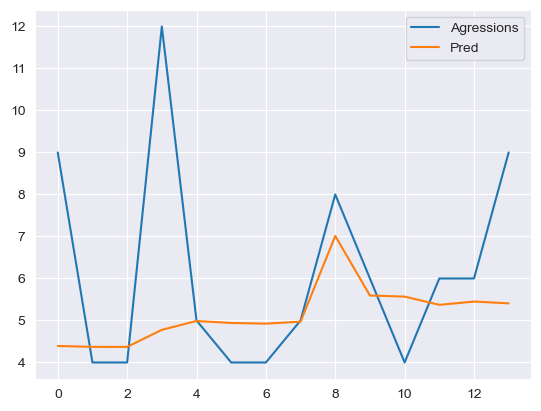

In [53]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [54]:
#Feature Selection
sel = SelectFromModel(xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0))
sel.fit(X_train, y_train)
selected_feat=X_train.columns[(sel.get_support())]
model= xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0)
model.fit(X_train[selected_feat], y_train)
xg_pred_train_y = model.predict(X_train[selected_feat]) 
xg_pred_test_y = model.predict(X_test[selected_feat])

selected_feat

Index(['New Years', 'agressions_week_avg', 'agressions_biweek_avg', 'month',
       'day', 'firstday', 'tardor', 'hivern', 'year_2023', 'cos(1,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'cos(4,freq=A-DEC)',
       'cos(1,freq=M)', 'cos(2,freq=M)', 'Poverty', 'Foreign born'],
      dtype='object')

In [55]:
test = y_test.to_frame()
test['Pred']  = xg_pred_test_y
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions       Pred  Mean model       MAPE  MAPE mean  \
Dates                                                                 
2023-01-24           9   5.538626    6.142857  34.690023  32.587868   
2023-01-25           4   5.538964    6.142857  34.690023  32.587868   
2023-01-26           4   5.635348    6.142857  34.690023  32.587868   
2023-01-27          12   5.640912    6.142857  34.690023  32.587868   
2023-01-28           5   5.648220    6.142857  34.690023  32.587868   
2023-01-29           4   5.587489    6.142857  34.690023  32.587868   
2023-01-30           4   5.800390    6.142857  34.690023  32.587868   
2023-01-31           5   5.736190    6.142857  34.690023  32.587868   
2023-02-01           8  15.602082    6.142857  34.690023  32.587868   
2023-02-02           6   5.972439    6.142857  34.690023  32.587868   
2023-02-03           4   5.897153    6.142857  34.690023  32.587868   
2023-02-04           6   5.430158    6.142857  34.690023  32.587868   
2023-02-05           6   5.413586    6.142857  34.690023  32.587868   
2023-02-06           9   5.374794    6.142857  34.690023  32.587868   

                SMAPE  SMAPE mean       MAE  MAE mean  Metrica nomb  \
Dates                                                                 
2023-01-24  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-25  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-26  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-27  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-28  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-29  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-30  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-01-31  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-01  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-02  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-03  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-04  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-05  32.540754   30.891685  2.291095  1.918367     57.142857   
2023-02-06  32.540754   30.891685  2.291095  1.918367     57.142857   

            Metrica nomb mean      RMSE  RMSE mean  
Dates                                               
2023-01-24          71.428571  3.155357   2.386185  
2023-01-25          71.428571  3.155357   2.386185  
2023-01-26          71.428571  3.155357   2.386185  
2023-01-27          71.428571  3.155357   2.386185  
2023-01-28          71.428571  3.155357   2.386185  
2023-01-29          71.428571  3.155357   2.386185  
2023-01-30          71.428571  3.155357   2.386185  
2023-01-31          71.428571  3.155357   2.386185  
2023-02-01          71.428571  3.155357   2.386185  
2023-02-02          71.428571  3.155357   2.386185  
2023-02-03          71.428571  3.155357   2.386185  
2023-02-04          71.428571  3.155357   2.386185  
2023-02-05          71.428571  3.155357   2.386185  
2023-02-06          71.428571  3.155357   2.386185

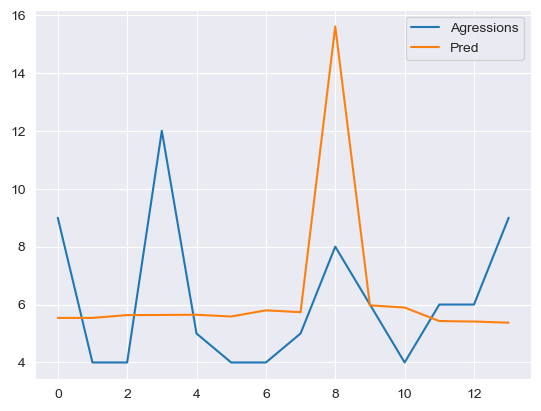

In [56]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

### Hyperparameter Tuning

In [158]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

X= new_df_dies.drop(columns = ['Agressions'])
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

In [159]:
test = y_test.to_frame()
test['Pred']  = rf_pred_test
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model       MAPE  MAPE mean      SMAPE  \
Dates                                                                           
2023-01-24           9  4.134921    5.857143  21.898678  33.718821  25.011459   
2023-01-25           4  3.847976    5.857143  21.898678  33.718821  25.011459   
2023-01-26           4  4.343659    5.857143  21.898678  33.718821  25.011459   
2023-01-27          12  4.553860    5.857143  21.898678  33.718821  25.011459   
2023-01-28           5  5.094916    5.857143  21.898678  33.718821  25.011459   
2023-01-29           4  4.948621    5.857143  21.898678  33.718821  25.011459   
2023-01-30           4  5.143301    5.857143  21.898678  33.718821  25.011459   
2023-01-31           5  4.983737    5.857143  21.898678  33.718821  25.011459   
2023-02-01           8  8.652019    5.857143  21.898678  33.718821  25.011459   
2023-02-02           4  5.252666    5.857143  21.898678  33.718821  25.011459   
2023-02-03           4  5.032200    5.857143  21.898678  33.718821  25.011459   
2023-02-04           5  5.310778    5.857143  21.898678  33.718821  25.011459   
2023-02-05           6  5.113082    5.857143  21.898678  33.718821  25.011459   
2023-02-06           8  5.016738    5.857143  21.898678  33.718821  25.011459   

            SMAPE mean      MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                        
2023-01-24   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-25   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-26   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-27   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-28   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-29   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-30   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-31   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-01   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-02   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-03   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-04   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-05   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-06   34.951596  1.58056  1.959184     57.142857          64.285714   

                RMSE  RMSE mean  
Dates                            
2023-01-24  2.595522   2.386185  
2023-01-25  2.595522   2.386185  
2023-01-26  2.595522   2.386185  
2023-01-27  2.595522   2.386185  
2023-01-28  2.595522   2.386185  
2023-01-29  2.595522   2.386185  
2023-01-30  2.595522   2.386185  
2023-01-31  2.595522   2.386185  
2023-02-01  2.595522   2.386185  
2023-02-02  2.595522   2.386185  
2023-02-03  2.595522   2.386185  
2023-02-04  2.595522   2.386185  
2023-02-05  2.595522   2.386185  
2023-02-06  2.595522   2.386185

In [161]:
random_search.best_estimator_

RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0)

In [162]:
random_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [184]:
#MEJOR ENERO

X= new_df_dies.drop(columns = ['Agressions'])
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)
model = RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])
test

Agressions      Pred  Mean model       MAPE  MAPE mean      SMAPE  \
Dates                                                                           
2023-01-24           9  4.134921    5.857143  21.898678  33.718821  25.011459   
2023-01-25           4  3.847976    5.857143  21.898678  33.718821  25.011459   
2023-01-26           4  4.343659    5.857143  21.898678  33.718821  25.011459   
2023-01-27          12  4.553860    5.857143  21.898678  33.718821  25.011459   
2023-01-28           5  5.094916    5.857143  21.898678  33.718821  25.011459   
2023-01-29           4  4.948621    5.857143  21.898678  33.718821  25.011459   
2023-01-30           4  5.143301    5.857143  21.898678  33.718821  25.011459   
2023-01-31           5  4.983737    5.857143  21.898678  33.718821  25.011459   
2023-02-01           8  8.652019    5.857143  21.898678  33.718821  25.011459   
2023-02-02           4  5.252666    5.857143  21.898678  33.718821  25.011459   
2023-02-03           4  5.032200    5.857143  21.898678  33.718821  25.011459   
2023-02-04           5  5.310778    5.857143  21.898678  33.718821  25.011459   
2023-02-05           6  5.113082    5.857143  21.898678  33.718821  25.011459   
2023-02-06           8  5.016738    5.857143  21.898678  33.718821  25.011459   

            SMAPE mean      MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                        
2023-01-24   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-25   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-26   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-27   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-28   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-29   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-30   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-01-31   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-01   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-02   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-03   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-04   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-05   34.951596  1.58056  1.959184     57.142857          64.285714   
2023-02-06   34.951596  1.58056  1.959184     57.142857          64.285714   

                RMSE  RMSE mean       MSE  
Dates                                      
2023-01-24  2.595522   2.386185  6.736735  
2023-01-25  2.595522   2.386185  6.736735  
2023-01-26  2.595522   2.386185  6.736735  
2023-01-27  2.595522   2.386185  6.736735  
2023-01-28  2.595522   2.386185  6.736735  
2023-01-29  2.595522   2.386185  6.736735  
2023-01-30  2.595522   2.386185  6.736735  
2023-01-31  2.595522   2.386185  6.736735  
2023-02-01  2.595522   2.386185  6.736735  
2023-02-02  2.595522   2.386185  6.736735  
2023-02-03  2.595522   2.386185  6.736735  
2023-02-04  2.595522   2.386185  6.736735  
2023-02-05  2.595522   2.386185  6.736735  
2023-02-06  2.595522   2.386185  6.736735

In [185]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('Dates')
d = d[-24:]

dies_gener['Random Forest'] = d['Pred']
dies_gener

Agressions    XGBoost  Random Forest
Dates                                           
2023-01-14         7.0   5.083340       5.991043
2023-01-15         6.0   4.865583       5.657867
2023-01-16         3.0   4.735273       4.048769
2023-01-17         8.0   4.772075       6.267617
2023-01-18         4.0   4.486415       4.266171
2023-01-19         3.0   4.522335       4.102830
2023-01-20         3.0   4.547059       3.820859
2023-01-21         7.0   4.692887       5.860730
2023-01-22         7.0   5.011000       6.455478
2023-01-23         5.0   4.971490       5.145605
2023-01-24         9.0   3.318645       4.134921
2023-01-25         4.0   3.140037       3.847976
2023-01-26         4.0   3.173428       4.343659
2023-01-27        12.0   3.648169       4.553860
2023-01-28         5.0   4.259130       5.094916
2023-01-29         4.0   4.294036       4.948621
2023-01-30         4.0   3.871274       5.143301
2023-01-31         5.0   3.576068       4.983737
2023-02-01         8.0  12.274116       8.652019
2023-02-02         4.0   3.592997       5.252666
2023-02-03         4.0   3.848856       5.032200
2023-02-04         5.0   4.211697       5.310778
2023-02-05         6.0   4.183637       5.113082
2023-02-06         8.0   3.673980       5.016738

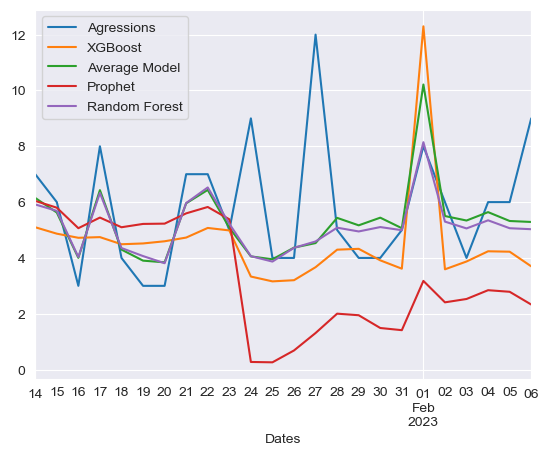

In [179]:
dies_gener.plot()
plt.show()

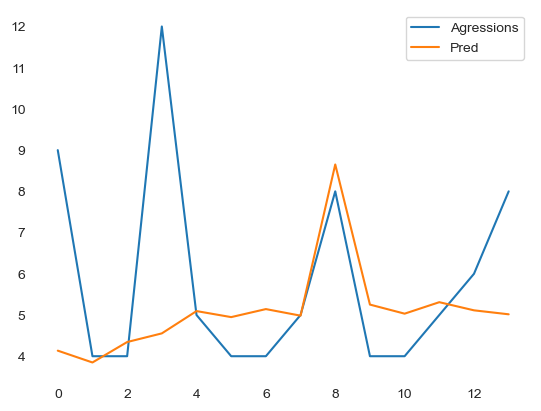

In [174]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [205]:
nnf = new_df_dies.loc[(new_df_dies.index.year !=2023) & (new_df_dies.index.year>= 2017)]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

X= nnf.drop(columns = ['Agressions'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)

model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

test = y_test.to_frame()
test['Pred']  = rf_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])
test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2022-12-18         3.0  5.132256    3.428571   inf        inf  50.289172   
2022-12-19         5.0  4.882676    3.428571   inf        inf  50.289172   
2022-12-20         3.0  5.297369    3.428571   inf        inf  50.289172   
2022-12-21         0.0  3.060478    3.428571   inf        inf  50.289172   
2022-12-22         1.0  4.238078    3.428571   inf        inf  50.289172   
2022-12-23         4.0  3.282286    3.428571   inf        inf  50.289172   
2022-12-24         1.0  3.146770    3.428571   inf        inf  50.289172   
2022-12-25         4.0  3.813435    3.428571   inf        inf  50.289172   
2022-12-26         5.0  2.828104    3.428571   inf        inf  50.289172   
2022-12-27         5.0  2.880701    3.428571   inf        inf  50.289172   
2022-12-28         4.0  3.493301    3.428571   inf        inf  50.289172   
2022-12-29         4.0  4.459727    3.428571   inf        inf  50.289172   
2022-12-30         4.0  4.355995    3.428571   inf        inf  50.289172   
2022-12-31         5.0  4.999550    3.428571   inf        inf  50.289172   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2022-12-18    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-19    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-20    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-21    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-22    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-23    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-24    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-25    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-26    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-27    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-28    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-29    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-30    47.91446  1.393616  1.306122          50.0          35.714286   
2022-12-31    47.91446  1.393616  1.306122          50.0          35.714286   

                RMSE  RMSE mean       MSE  
Dates                                      
2022-12-18  1.785893    1.59079  3.189413  
2022-12-19  1.785893    1.59079  3.189413  
2022-12-20  1.785893    1.59079  3.189413  
2022-12-21  1.785893    1.59079  3.189413  
2022-12-22  1.785893    1.59079  3.189413  
2022-12-23  1.785893    1.59079  3.189413  
2022-12-24  1.785893    1.59079  3.189413  
2022-12-25  1.785893    1.59079  3.189413  
2022-12-26  1.785893    1.59079  3.189413  
2022-12-27  1.785893    1.59079  3.189413  
2022-12-28  1.785893    1.59079  3.189413  
2022-12-29  1.785893    1.59079  3.189413  
2022-12-30  1.785893    1.59079  3.189413  
2022-12-31  1.785893    1.59079  3.189413

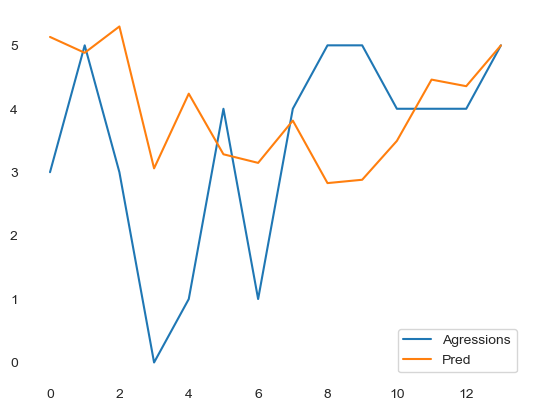

In [206]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [207]:
print(random_search.best_params_)
random_search.best_estimator_

{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0)

In [40]:
#MEJOR DICIEMBRE
X= nnf.drop(columns = ['Agressions', 'New Years'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-12-15', 14)

# weights = create_sample_weights(X_train, '2022-12-01')
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
# f = df_prova.loc[df_prova.Dates.year!=2023]
# f =df_prova.groupby(df_prova.Dates).size()
# test['Agressions'] = f.iloc[-37:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2022-12-18         3.0  5.204839    3.428571   inf        inf  57.651788   
2022-12-19         5.0  4.313732    3.428571   inf        inf  57.651788   
2022-12-20         3.0  4.969989    3.428571   inf        inf  57.651788   
2022-12-21         0.0  2.588399    3.428571   inf        inf  57.651788   
2022-12-22         1.0  3.737363    3.428571   inf        inf  57.651788   
2022-12-23         4.0  3.494726    3.428571   inf        inf  57.651788   
2022-12-24         1.0  3.232514    3.428571   inf        inf  57.651788   
2022-12-25         4.0  2.994309    3.428571   inf        inf  57.651788   
2022-12-26         5.0  2.275597    3.428571   inf        inf  57.651788   
2022-12-27         5.0  2.179506    3.428571   inf        inf  57.651788   
2022-12-28         4.0  2.702387    3.428571   inf        inf  57.651788   
2022-12-29         4.0  3.761950    3.428571   inf        inf  57.651788   
2022-12-30         4.0  3.998098    3.428571   inf        inf  57.651788   
2022-12-31         5.0  6.597203    3.428571   inf        inf  57.651788   

            SMAPE mean    MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                      
2022-12-18   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-19   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-20   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-21   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-22   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-23   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-24   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-25   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-26   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-27   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-28   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-29   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-30   52.062589  1.615  1.306122     42.857143          35.714286   
2022-12-31   52.062589  1.615  1.306122     42.857143          35.714286   

                RMSE  RMSE mean  
Dates                            
2022-12-18  1.877042    1.59079  
2022-12-19  1.877042    1.59079  
2022-12-20  1.877042    1.59079  
2022-12-21  1.877042    1.59079  
2022-12-22  1.877042    1.59079  
2022-12-23  1.877042    1.59079  
2022-12-24  1.877042    1.59079  
2022-12-25  1.877042    1.59079  
2022-12-26  1.877042    1.59079  
2022-12-27  1.877042    1.59079  
2022-12-28  1.877042    1.59079  
2022-12-29  1.877042    1.59079  
2022-12-30  1.877042    1.59079  
2022-12-31  1.877042    1.59079

In [41]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['Dates','Agressions', 'Pred']), test.reset_index().set_index(['Dates','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-11]
d = d.set_index('Dates')
d = d[-24:]

dies_desembre['Random Forest'] = d['Pred']

In [42]:
dies_desembre.to_csv('dies_desembre.csv')

In [179]:
nnf = new_df_dies.loc[(new_df_dies.index.year>= 2017)]
nnf = nnf.drop(columns=['cos(1,freq=A-DEC)'])

X= nnf.drop(columns = ['Agressions'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)


random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
test['Pred']  = rf_pred_test
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.5, enable_categorical=False, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)
{'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}


Agressions       Pred  Mean model       MAPE  MAPE mean  \
Dates                                                                 
2023-01-24           9   1.786634    5.857143  30.355679  33.718821   
2023-01-25           4   2.171811    5.857143  30.355679  33.718821   
2023-01-26           4   3.329528    5.857143  30.355679  33.718821   
2023-01-27          12   4.188497    5.857143  30.355679  33.718821   
2023-01-28           5   5.235990    5.857143  30.355679  33.718821   
2023-01-29           4   5.434574    5.857143  30.355679  33.718821   
2023-01-30           4   5.317503    5.857143  30.355679  33.718821   
2023-01-31           5   5.075625    5.857143  30.355679  33.718821   
2023-02-01           8  11.671555    5.857143  30.355679  33.718821   
2023-02-02           4   4.924365    5.857143  30.355679  33.718821   
2023-02-03           4   4.487036    5.857143  30.355679  33.718821   
2023-02-04           5   4.627885    5.857143  30.355679  33.718821   
2023-02-05           6   5.063345    5.857143  30.355679  33.718821   
2023-02-06           8   4.959861    5.857143  30.355679  33.718821   

                SMAPE  SMAPE mean      MAE  MAE mean  Metrica nomb  \
Dates                                                                
2023-01-24  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-25  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-26  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-27  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-28  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-29  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-30  36.692487   37.045958  2.14422  1.959184          50.0   
2023-01-31  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-01  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-02  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-03  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-04  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-05  36.692487   37.045958  2.14422  1.959184          50.0   
2023-02-06  36.692487   37.045958  2.14422  1.959184          50.0   

            Metrica nomb mean      RMSE  RMSE mean  
Dates                                               
2023-01-24          64.285714  3.224122   2.386185  
2023-01-25          64.285714  3.224122   2.386185  
2023-01-26          64.285714  3.224122   2.386185  
2023-01-27          64.285714  3.224122   2.386185  
2023-01-28          64.285714  3.224122   2.386185  
2023-01-29          64.285714  3.224122   2.386185  
2023-01-30          64.285714  3.224122   2.386185  
2023-01-31          64.285714  3.224122   2.386185  
2023-02-01          64.285714  3.224122   2.386185  
2023-02-02          64.285714  3.224122   2.386185  
2023-02-03          64.285714  3.224122   2.386185  
2023-02-04          64.285714  3.224122   2.386185  
2023-02-05          64.285714  3.224122   2.386185  
2023-02-06          64.285714  3.224122   2.386185

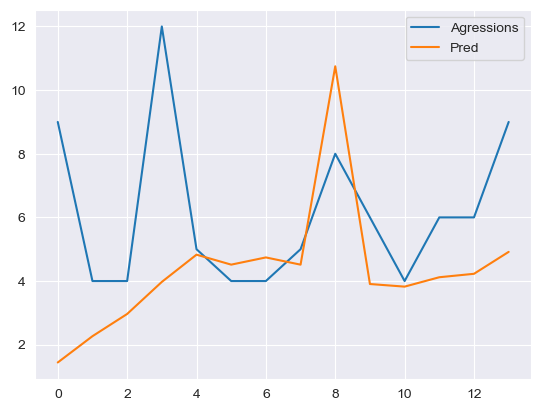

In [102]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [103]:
X= nnf.drop(columns = ['Agressions', 'New Years'])
y = nnf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)


random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
test['Pred']  = rf_pred_test
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.5, enable_categorical=False, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)
{'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}


Agressions       Pred  Mean model       MAPE  MAPE mean  \
Dates                                                                 
2023-01-24           9   1.072351    6.142857  33.974748  32.587868   
2023-01-25           4   1.807120    6.142857  33.974748  32.587868   
2023-01-26           4   2.713364    6.142857  33.974748  32.587868   
2023-01-27          12   3.582587    6.142857  33.974748  32.587868   
2023-01-28           5   4.663614    6.142857  33.974748  32.587868   
2023-01-29           4   4.426033    6.142857  33.974748  32.587868   
2023-01-30           4   4.671627    6.142857  33.974748  32.587868   
2023-01-31           5   4.782352    6.142857  33.974748  32.587868   
2023-02-01           8  10.689610    6.142857  33.974748  32.587868   
2023-02-02           6   3.183944    6.142857  33.974748  32.587868   
2023-02-03           4   4.417315    6.142857  33.974748  32.587868   
2023-02-04           6   4.380742    6.142857  33.974748  32.587868   
2023-02-05           6   4.468992    6.142857  33.974748  32.587868   
2023-02-06           9   4.642687    6.142857  33.974748  32.587868   

                SMAPE  SMAPE mean       MAE  MAE mean  Metrica nomb  \
Dates                                                                 
2023-01-24  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-25  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-26  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-27  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-28  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-29  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-30  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-01-31  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-01  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-02  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-03  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-04  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-05  45.761818   38.436988  2.493345  1.918367     28.571429   
2023-02-06  45.761818   38.436988  2.493345  1.918367     28.571429   

            Metrica nomb mean      RMSE  RMSE mean  
Dates                                               
2023-01-24          71.428571  3.588157   2.386185  
2023-01-25          71.428571  3.588157   2.386185  
2023-01-26          71.428571  3.588157   2.386185  
2023-01-27          71.428571  3.588157   2.386185  
2023-01-28          71.428571  3.588157   2.386185  
2023-01-29          71.428571  3.588157   2.386185  
2023-01-30          71.428571  3.588157   2.386185  
2023-01-31          71.428571  3.588157   2.386185  
2023-02-01          71.428571  3.588157   2.386185  
2023-02-02          71.428571  3.588157   2.386185  
2023-02-03          71.428571  3.588157   2.386185  
2023-02-04          71.428571  3.588157   2.386185  
2023-02-05          71.428571  3.588157   2.386185  
2023-02-06          71.428571  3.588157   2.386185

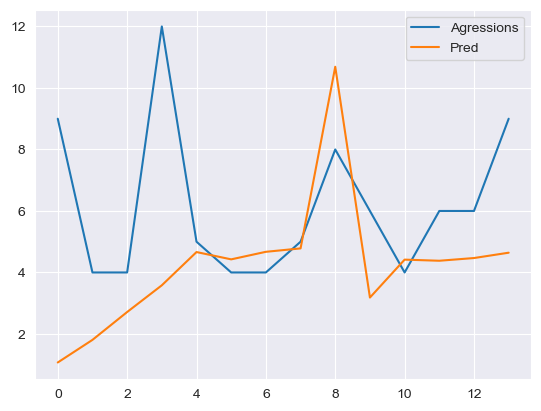

In [104]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [132]:
# #haig de triar una unica metrica per la que ordenar

def tuning(train, test, y_test, X_test):
    param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'holidays_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12]
    }
    grid = ParameterGrid(param_grid)

    model_parameters = pd.DataFrame(columns = ['RMSLE','Parameters'])
    for p in grid:
        random.seed(0)
        train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                          holidays_prior_scale = p['holidays_prior_scale'],
                          seasonality_prior_scale = p['seasonality_prior_scale'],
                          yearly_seasonality = True,
                          weekly_seasonality = True,
                          daily_seasonality = False)

        print('He entrado', p)
        train_model.fit(train)
        p_pred_test_y = train_model.predict(test)
        MAE = np.mean(np.abs(mean_squared_error(f.iloc[-14:].to_frame(), p_pred_test_y[['ds', 'yhat']].set_index('ds').clip(0.0))))
        model_parameters = model_parameters.append({'MAE':MAE,'Parameters':p},ignore_index=True)

    parameters = model_parameters.sort_values(by=['MAE'])
    parameters = parameters.reset_index(drop=True)
    
    return parameters['Parameters'][0]

In [133]:
X= new_df_dies.drop(columns = 'Agressions')
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

cols = X.columns[~X.columns.str.match(r'Agressions|year_|trend')]
X = X.loc[:,cols]
y = new_df_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2023-01-23', 14)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

# Prophet

params = tuning(train, test, y_test, X_test)
model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'], 
             seasonality_prior_scale=params['seasonality_prior_scale'], 
             holidays_prior_scale=params['holidays_prior_scale'],
             yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])
    
print(params)


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
f =df_prova.groupby(df_prova.Dates).size()
test['Agressions'] = f.iloc[-14:].to_frame()

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.08, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 1}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 5}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 10}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


He entrado {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 12, 'seasonality_prior_scale': 12}


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01}


INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model       MAPE  MAPE mean  \
ds                                                                    
2023-01-24  -1.864720           9    6.142857  88.864477  32.587868   
2023-01-25  -1.746727           4    6.142857  88.864477  32.587868   
2023-01-26  -1.080075           4    6.142857  88.864477  32.587868   
2023-01-27   0.040462          12    6.142857  88.864477  32.587868   
2023-01-28   1.432774           5    6.142857  88.864477  32.587868   
2023-01-29   1.417224           4    6.142857  88.864477  32.587868   
2023-01-30   0.593647           4    6.142857  88.864477  32.587868   
2023-01-31   0.489638           5    6.142857  88.864477  32.587868   
2023-02-01  11.045394           8    6.142857  88.864477  32.587868   
2023-02-02   0.529031           6    6.142857  88.864477  32.587868   
2023-02-03   0.886408           4    6.142857  88.864477  32.587868   
2023-02-04   1.685298           6    6.142857  88.864477  32.587868   
2023-02-05   1.669749           6    6.142857  88.864477  32.587868   
2023-02-06   0.846171           9    6.142857  88.864477  32.587868   

                 SMAPE  SMAPE mean       MAE  MAE mean  Metrica nomb  \
ds                                                                     
2023-01-24  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-25  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-26  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-27  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-28  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-29  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-30  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-01-31  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-01  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-02  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-03  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-04  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-05  145.384476   52.533419  5.439037  1.918367      7.142857   
2023-02-06  145.384476   52.533419  5.439037  1.918367      7.142857   

            Metrica nomb mean      RMSE  RMSE mean  
ds                                                  
2023-01-24          71.428571  6.117891   2.386185  
2023-01-25          71.428571  6.117891   2.386185  
2023-01-26          71.428571  6.117891   2.386185  
2023-01-27          71.428571  6.117891   2.386185  
2023-01-28          71.428571  6.117891   2.386185  
2023-01-29          71.428571  6.117891   2.386185  
2023-01-30          71.428571  6.117891   2.386185  
2023-01-31          71.428571  6.117891   2.386185  
2023-02-01          71.428571  6.117891   2.386185  
2023-02-02          71.428571  6.117891   2.386185  
2023-02-03          71.428571  6.117891   2.386185  
2023-02-04          71.428571  6.117891   2.386185  
2023-02-05          71.428571  6.117891   2.386185  
2023-02-06          71.428571  6.117891   2.386185

## 14 dies cada comunitat

In [117]:
community_dies['New Years'] = 0
community_dies.loc[(community_dies.index.day == 1) & (community_dies.index.month == 1), 'New Years'] = 1

In [172]:
X= community_dies.drop(columns = 'Agressions')
y = community_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2023-01-23', 1078)
model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

y_test = y_test.to_frame()
test = y_test


f = df_prova.groupby([df.Dates, df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('Dates')
f.index = pd.to_datetime(f.index)
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
test['Agressions'] = f.iloc[-1078:]

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model  MAPE  MAPE mean       SMAPE  \
Dates                                                                       
2023-01-24           0  0.293186    0.079777   inf        inf  192.018264   
2023-01-24           1  0.240663    0.079777   inf        inf  192.018264   
2023-01-24           2  0.133676    0.079777   inf        inf  192.018264   
2023-01-24           0  0.217512    0.079777   inf        inf  192.018264   
2023-01-24           0  0.000000    0.079777   inf        inf  192.018264   
...                ...       ...         ...   ...        ...         ...   
2023-02-06           0  0.000000    0.079777   inf        inf  192.018264   
2023-02-06           0  0.000000    0.079777   inf        inf  192.018264   
2023-02-06           1  0.343821    0.079777   inf        inf  192.018264   
2023-02-06           0  0.311370    0.079777   inf        inf  192.018264   
2023-02-06           0  0.066595    0.079777   inf        inf  192.018264   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-01-24  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-01-24  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-01-24  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-01-24  197.947705  0.256334   0.14801      70.96475          92.764378   
...                ...       ...       ...           ...                ...   
2023-02-06  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-02-06  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-02-06  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-02-06  197.947705  0.256334   0.14801      70.96475          92.764378   
2023-02-06  197.947705  0.256334   0.14801      70.96475          92.764378   

                RMSE  RMSE mean  
Dates                            
2023-01-24  0.347243   0.306302  
2023-01-24  0.347243   0.306302  
2023-01-24  0.347243   0.306302  
2023-01-24  0.347243   0.306302  
2023-01-24  0.347243   0.306302  
...              ...        ...  
2023-02-06  0.347243   0.306302  
2023-02-06  0.347243   0.306302  
2023-02-06  0.347243   0.306302  
2023-02-06  0.347243   0.306302  
2023-02-06  0.347243   0.306302  

[1078 rows x 13 columns]

In [124]:
test

Agressions
Dates                 
2023-01-24           0
2023-01-24           1
2023-01-24           2
2023-01-24           0
2023-01-24           0
...                ...
2023-02-06           0
2023-02-06           0
2023-02-06           0
2023-02-06           0
2023-02-06           0

[1078 rows x 1 columns]

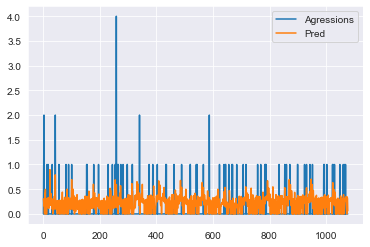

In [566]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [146]:
X= community_dies.drop(columns = 'Agressions')
y = community_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2023-01-23', 1078)
model= xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0)
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

y_test = y_test.to_frame()
test = y_test


f = df_prova.groupby([df.Dates, df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-23]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('Dates')
f.index = pd.to_datetime(f.index)
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
test['Agressions'] = f.iloc[-1078:]

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()


Agressions      Pred  Mean model  MAPE  MAPE mean       SMAPE  \
Dates                                                                       
2023-01-24           0  0.053530    0.076067   inf        inf  196.886453   
2023-01-24           1  0.130270    0.076067   inf        inf  196.886453   
2023-01-24           2  0.084020    0.076067   inf        inf  196.886453   
2023-01-24           0  0.113895    0.076067   inf        inf  196.886453   
2023-01-24           0  0.010268    0.076067   inf        inf  196.886453   
...                ...       ...         ...   ...        ...         ...   
2023-02-06           0  0.011842    0.076067   inf        inf  196.886453   
2023-02-06           0  0.003533    0.076067   inf        inf  196.886453   
2023-02-06           0  0.031620    0.076067   inf        inf  196.886453   
2023-02-06           0  0.038078    0.076067   inf        inf  196.886453   
2023-02-06           0  0.045619    0.076067   inf        inf  196.886453   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.131427  0.141549     93.042672          93.042672   
...                ...       ...       ...           ...                ...   
2023-02-06  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.131427  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.131427  0.141549     93.042672          93.042672   

                RMSE  RMSE mean  
Dates                            
2023-01-24  0.288331    0.29805  
2023-01-24  0.288331    0.29805  
2023-01-24  0.288331    0.29805  
2023-01-24  0.288331    0.29805  
2023-01-24  0.288331    0.29805  
...              ...        ...  
2023-02-06  0.288331    0.29805  
2023-02-06  0.288331    0.29805  
2023-02-06  0.288331    0.29805  
2023-02-06  0.288331    0.29805  
2023-02-06  0.288331    0.29805  

[1078 rows x 13 columns]

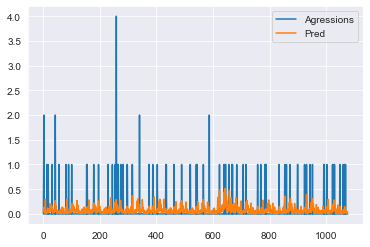

In [147]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [148]:
# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(subsample = 0.6, n_estimators = 100, max_depth=5, learning_rate = 0.1, colsample_bytree = 0.5, colsample_bylevel = 0.4, random_state=0)
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.2 + rf_pred_train * 0.8
total_pred_test = xg_pred_test * 0.2 + rf_pred_test * 0.8

test = y_test


f = df_prova.groupby([df.Dates, df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-23]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('Dates')
f.index = pd.to_datetime(f.index)
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
test['Agressions'] = f.iloc[-1078:]

test['Pred'] = total_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
Dates                                                                      
2023-01-24           0  0.270351    0.076067   inf        inf  194.36605   
2023-01-24           1  0.234675    0.076067   inf        inf  194.36605   
2023-01-24           2  0.140719    0.076067   inf        inf  194.36605   
2023-01-24           0  0.196692    0.076067   inf        inf  194.36605   
2023-01-24           0  0.008492    0.076067   inf        inf  194.36605   
...                ...       ...         ...   ...        ...        ...   
2023-02-06           0  0.024845    0.076067   inf        inf  194.36605   
2023-02-06           0  0.010692    0.076067   inf        inf  194.36605   
2023-02-06           0  0.310814    0.076067   inf        inf  194.36605   
2023-02-06           0  0.285732    0.076067   inf        inf  194.36605   
2023-02-06           0  0.070552    0.076067   inf        inf  194.36605   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
Dates                                                                         
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
...                ...       ...       ...           ...                ...   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   

                RMSE  RMSE mean  
Dates                            
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
...              ...        ...  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  

[1078 rows x 13 columns]

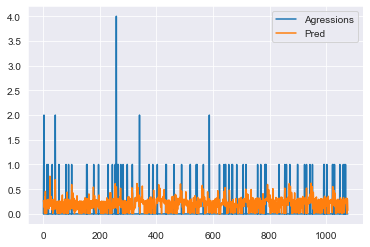

In [149]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [153]:
X= community_dies.drop(columns = 'Agressions')
cols = X.columns[~X.columns.str.match(r'Agressions|year_|trend')]
X = X.loc[:,cols]
y = community_dies['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2023-01-23', 1078)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'Dates': 'ds', 'Agressions': 'y'})

# Prophet
model = Prophet(
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'additive',
                yearly_seasonality = True,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
f = df_prova.groupby([df.Dates, df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-23]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('Dates')
f.index = pd.to_datetime(f.index)
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
test['Agressions'] = f.iloc[-1078:]

test['Pred'] = total_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model  MAPE  MAPE mean      SMAPE  \
ds                                                                         
2023-01-24  0.270351           0    0.076067   inf        inf  194.36605   
2023-01-24  0.234675           1    0.076067   inf        inf  194.36605   
2023-01-24  0.140719           2    0.076067   inf        inf  194.36605   
2023-01-24  0.196692           0    0.076067   inf        inf  194.36605   
2023-01-24  0.008492           0    0.076067   inf        inf  194.36605   
...              ...         ...         ...   ...        ...        ...   
2023-02-06  0.024845           0    0.076067   inf        inf  194.36605   
2023-02-06  0.010692           0    0.076067   inf        inf  194.36605   
2023-02-06  0.310814           0    0.076067   inf        inf  194.36605   
2023-02-06  0.285732           0    0.076067   inf        inf  194.36605   
2023-02-06  0.070552           0    0.076067   inf        inf  194.36605   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                            
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-01-24  198.102598  0.240272  0.141549     93.042672          93.042672   
...                ...       ...       ...           ...                ...   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   
2023-02-06  198.102598  0.240272  0.141549     93.042672          93.042672   

                RMSE  RMSE mean  
ds                               
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
2023-01-24  0.328794    0.29805  
...              ...        ...  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  
2023-02-06  0.328794    0.29805  

[1078 rows x 13 columns]

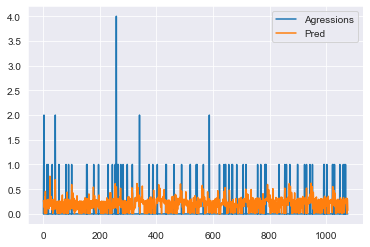

In [154]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

## 6 mes total

In [ ]:
#no tinc en compte el mes de 2023 pq tin un mes i mig

In [ ]:
############################ 1 any ####################################3

In [96]:
# nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = new_df_mesos.loc[new_df_mesos.index.year >=2018]
nf = nf.iloc[:-12]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2021-01', 12)

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-14]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions        Pred  Mean model      MAPE  MAPE mean    SMAPE  \
month_year                                                                     
2021-01-01         144  141.260498  192.916667  5.012042  12.313246  5.08593   
2021-02-01         147  141.745741  192.916667  5.012042  12.313246  5.08593   
2021-03-01         191  171.864721  192.916667  5.012042  12.313246  5.08593   
2021-04-01         169  173.543582  192.916667  5.012042  12.313246  5.08593   
2021-05-01         208  180.187674  192.916667  5.012042  12.313246  5.08593   
2021-06-01         216  205.304087  192.916667  5.012042  12.313246  5.08593   
2021-07-01         225  229.636656  192.916667  5.012042  12.313246  5.08593   
2021-08-01         207  235.203267  192.916667  5.012042  12.313246  5.08593   
2021-09-01         207  206.994018  192.916667  5.012042  12.313246  5.08593   
2021-10-01         217  205.411063  192.916667  5.012042  12.313246  5.08593   
2021-11-01         202  201.682917  192.916667  5.012042  12.313246  5.08593   
2021-12-01         182  186.462205  192.916667  5.012042  12.313246  5.08593   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2021-01-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-02-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-03-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-04-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-05-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-06-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-07-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-08-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-09-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-10-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-11-01   12.413814  9.949583  21.930556     33.333333          41.666667   
2021-12-01   12.413814  9.949583  21.930556     33.333333          41.666667   

                 RMSE  RMSE mean  
month_year                        
2021-01-01  13.787317  25.892271  
2021-02-01  13.787317  25.892271  
2021-03-01  13.787317  25.892271  
2021-04-01  13.787317  25.892271  
2021-05-01  13.787317  25.892271  
2021-06-01  13.787317  25.892271  
2021-07-01  13.787317  25.892271  
2021-08-01  13.787317  25.892271  
2021-09-01  13.787317  25.892271  
2021-10-01  13.787317  25.892271  
2021-11-01  13.787317  25.892271  
2021-12-01  13.787317  25.892271

In [30]:
def sqr_err(y_true, y_pred):
    """

    :param y_true: true values of y
    :param y_pred: predicted values of y
    :return: array of lenght original data containing mean squared error for each predictions
    """
    if len(y_true) != len(y_pred):
        raise IndexError("Mismathced array sizes, you inputted arrays with sizes {} and {}".format(len(y_true),
                                                                                                  len(y_pred)))
    else:
        length = len(y_true)

    sqrerror_out = [(y_pred[i]-y_true[i])**2 for i in range(length)]

    return np.array(sqrerror_out)


# Squared_error = sqr_err(test['Agressions'], test['Pred'])

# test['MSE'] = Squared_error

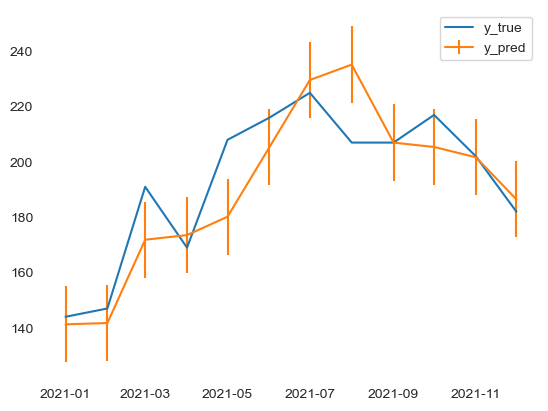

In [98]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

(-50.0, 50.0)

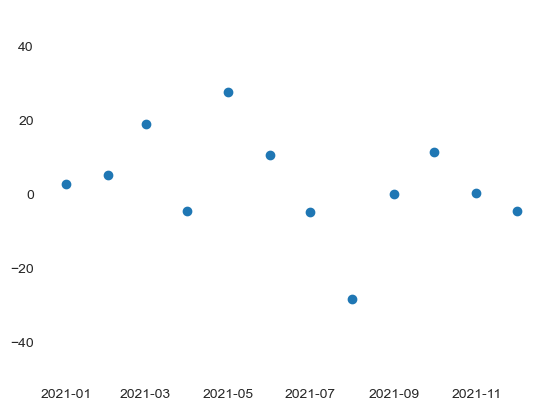

In [99]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

plt.ylim(-50,50)

<AxesSubplot:xlabel='month_year'>

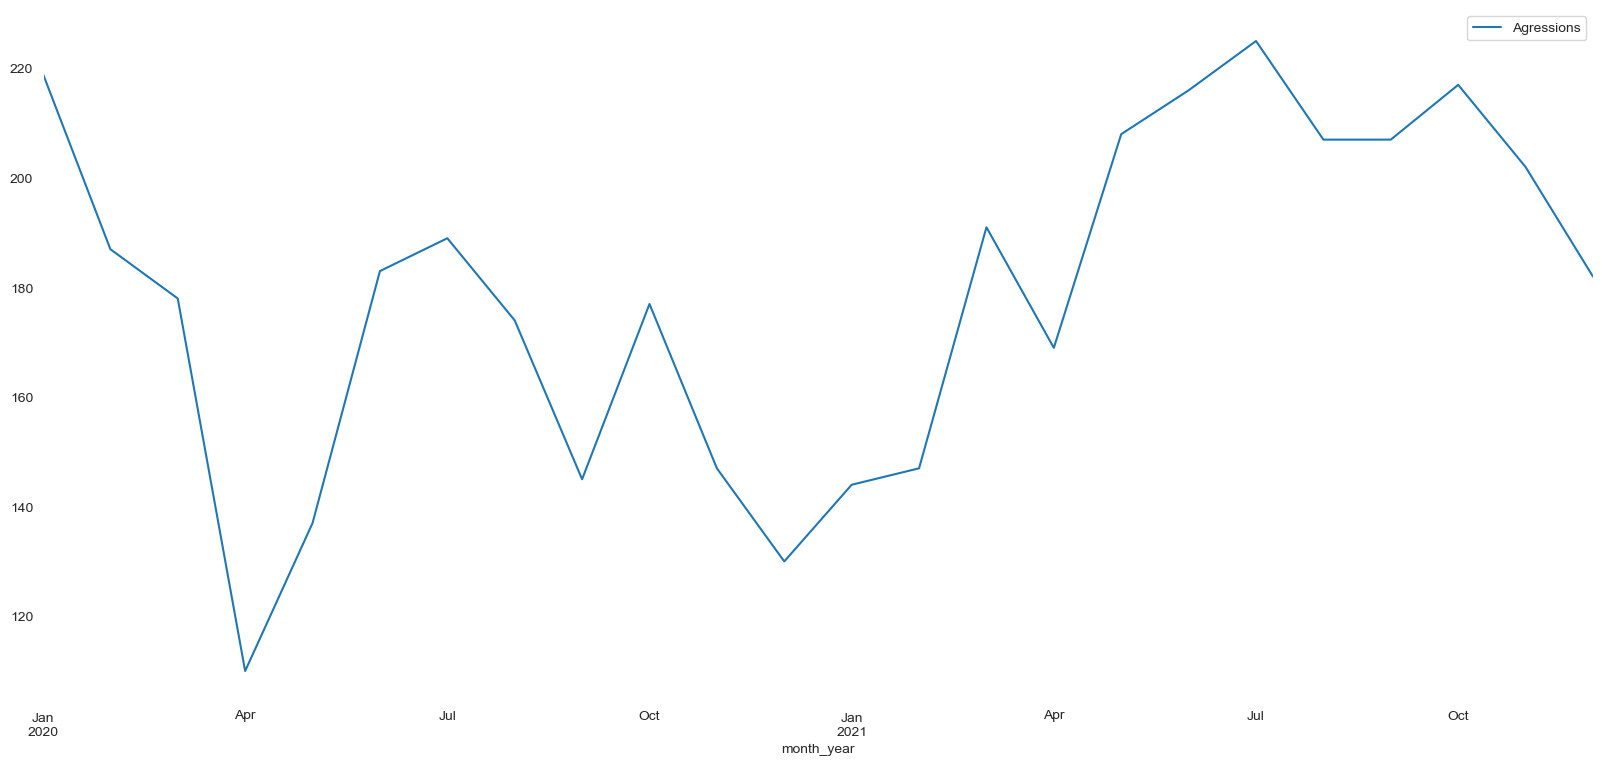

In [100]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-13]
d = d.set_index('month_year')
d = d[-24:]

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')

d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [31]:
# nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = new_df_mesos.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = sqr_err(test['Agressions'], test['Pred'])
test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-01-01         183  180.393865      203.75  18.066921  11.325039   
2022-02-01         183  177.677091      203.75  18.066921  11.325039   
2022-03-01         214  193.084744      203.75  18.066921  11.325039   
2022-04-01         192  195.650718      203.75  18.066921  11.325039   
2022-05-01         225  211.536135      203.75  18.066921  11.325039   
2022-06-01         204  219.901427      203.75  18.066921  11.325039   
2022-07-01         229  139.534682      203.75  18.066921  11.325039   
2022-08-01         234  136.818435      203.75  18.066921  11.325039   
2022-09-01         222  141.954649      203.75  18.066921  11.325039   
2022-10-01         230  140.526920      203.75  18.066921  11.325039   
2022-11-01         177  139.668029      203.75  18.066921  11.325039   
2022-12-01         152  136.239324      203.75  18.066921  11.325039   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-01-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-02-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-03-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-04-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-05-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-06-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-07-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-08-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-09-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-10-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-11-01  21.498155   12.574678  39.259856  21.958333     16.666667   
2022-12-01  21.498155   12.574678  39.259856  21.958333     16.666667   

            Metrica nomb mean       RMSE  RMSE mean          MSE  
month_year                                                        
2022-01-01          41.666667  53.559233  25.040384     6.791939  
2022-02-01          41.666667  53.559233  25.040384    28.333364  
2022-03-01          41.666667  53.559233  25.040384   437.447943  
2022-04-01          41.666667  53.559233  25.040384    13.327744  
2022-05-01          41.666667  53.559233  25.040384   181.275663  
2022-06-01          41.666667  53.559233  25.040384   252.855378  
2022-07-01          41.666667  53.559233  25.040384  8004.043206  
2022-08-01          41.666667  53.559233  25.040384  9444.256668  
2022-09-01          41.666667  53.559233  25.040384  6407.258141  
2022-10-01          41.666667  53.559233  25.040384  8005.432109  
2022-11-01          41.666667  53.559233  25.040384  1393.676076  
2022-12-01          41.666667  53.559233  25.040384   248.398906

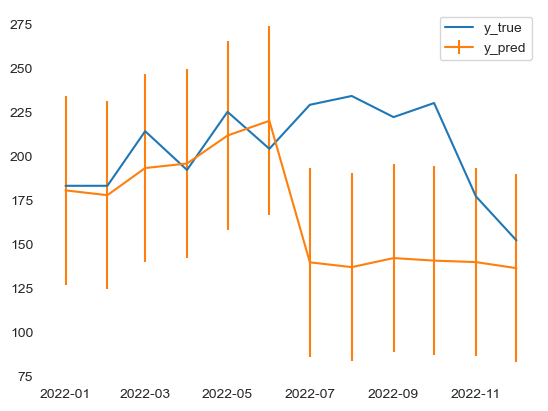

In [102]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

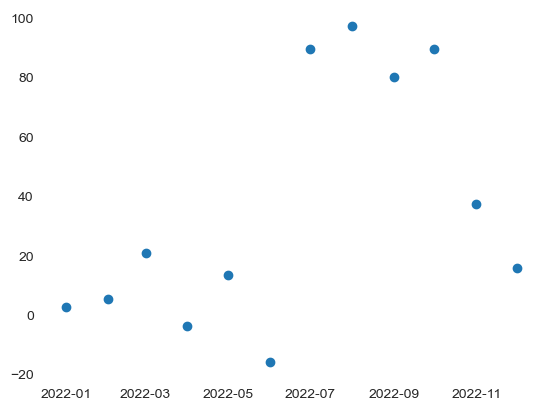

In [103]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

In [35]:
train.reset_index().set_index(['month_year','Agressions', 'Pred'])

Empty DataFrame
Columns: []
Index: [(2018-01-01 00:00:00, 195.0, 195.15218253968249), (2018-02-01 00:00:00, 173.0, 174.8895763888889), (2018-03-01 00:00:00, 180.0, 180.2363370310244), (2018-04-01 00:00:00, 188.0, 181.71007082732103), (2018-05-01 00:00:00, 237.0, 230.39757837301596), (2018-06-01 00:00:00, 231.0, 228.4069249338625), (2018-07-01 00:00:00, 219.0, 224.70515707671953), (2018-08-01 00:00:00, 243.0, 237.8555254629634), (2018-09-01 00:00:00, 248.0, 249.23245833333348), (2018-10-01 00:00:00, 235.0, 235.18674966931252), (2018-11-01 00:00:00, 226.0, 226.842357804233), (2018-12-01 00:00:00, 197.0, 205.9625178571428), (2019-01-01 00:00:00, 231.0, 227.06642791005328), (2019-02-01 00:00:00, 195.0, 208.42090295815296), (2019-03-01 00:00:00, 196.0, 193.98060786435755), (2019-04-01 00:00:00, 175.0, 178.63876818783078), (2019-05-01 00:00:00, 254.0, 239.46329464285736), (2019-06-01 00:00:00, 219.0, 225.00276818783067), (2019-07-01 00:00:00, 273.0, 251.0526150793653), (2019-08-01 00:00:00, 248.0, 248.52852564333816), (2019-09-01 00:00:00, 262.0, 253.67375613275615), (2019-10-01 00:00:00, 223.0, 228.09294874338627), (2019-11-01 00:00:00, 205.0, 211.58507804232806), (2019-12-01 00:00:00, 207.0, 203.30976686507935), (2020-01-01 00:00:00, 219.0, 218.14041798941818), (2020-02-01 00:00:00, 187.0, 192.86408630952357), (2020-03-01 00:00:00, 178.0, 179.10002910052907), (2020-04-01 00:00:00, 110.0, 131.62431249999983), (2020-05-01 00:00:00, 137.0, 136.634240079365), (2020-06-01 00:00:00, 183.0, 170.91506911375672), (2020-07-01 00:00:00, 189.0, 185.47889424001923), (2020-08-01 00:00:00, 174.0, 173.93470905483426), (2020-09-01 00:00:00, 145.0, 154.58674603174597), (2020-10-01 00:00:00, 177.0, 170.42270304232792), (2020-11-01 00:00:00, 147.0, 164.97057638888882), (2020-12-01 00:00:00, 130.0, 132.40574999999987), (2021-01-01 00:00:00, 144.0, 140.9829662698411), (2021-02-01 00:00:00, 147.0, 143.83591038359785), (2021-03-01 00:00:00, 191.0, 181.71406487494), (2021-04-01 00:00:00, 169.0, 172.89948749398752), (2021-05-01 00:00:00, 208.0, 196.29995006613748), (2021-06-01 00:00:00, 216.0, 214.61250760582027), (2021-07-01 00:00:00, 225.0, 223.32379960317476), (2021-08-01 00:00:00, 207.0, 217.14418238936997), (2021-09-01 00:00:00, 207.0, 207.3757343073593), (2021-10-01 00:00:00, 217.0, 214.75853505291022), (2021-11-01 00:00:00, 202.0, 203.5282959656082), (2021-12-01 00:00:00, 182.0, 189.05432969576728)]

<AxesSubplot:xlabel='month_year'>

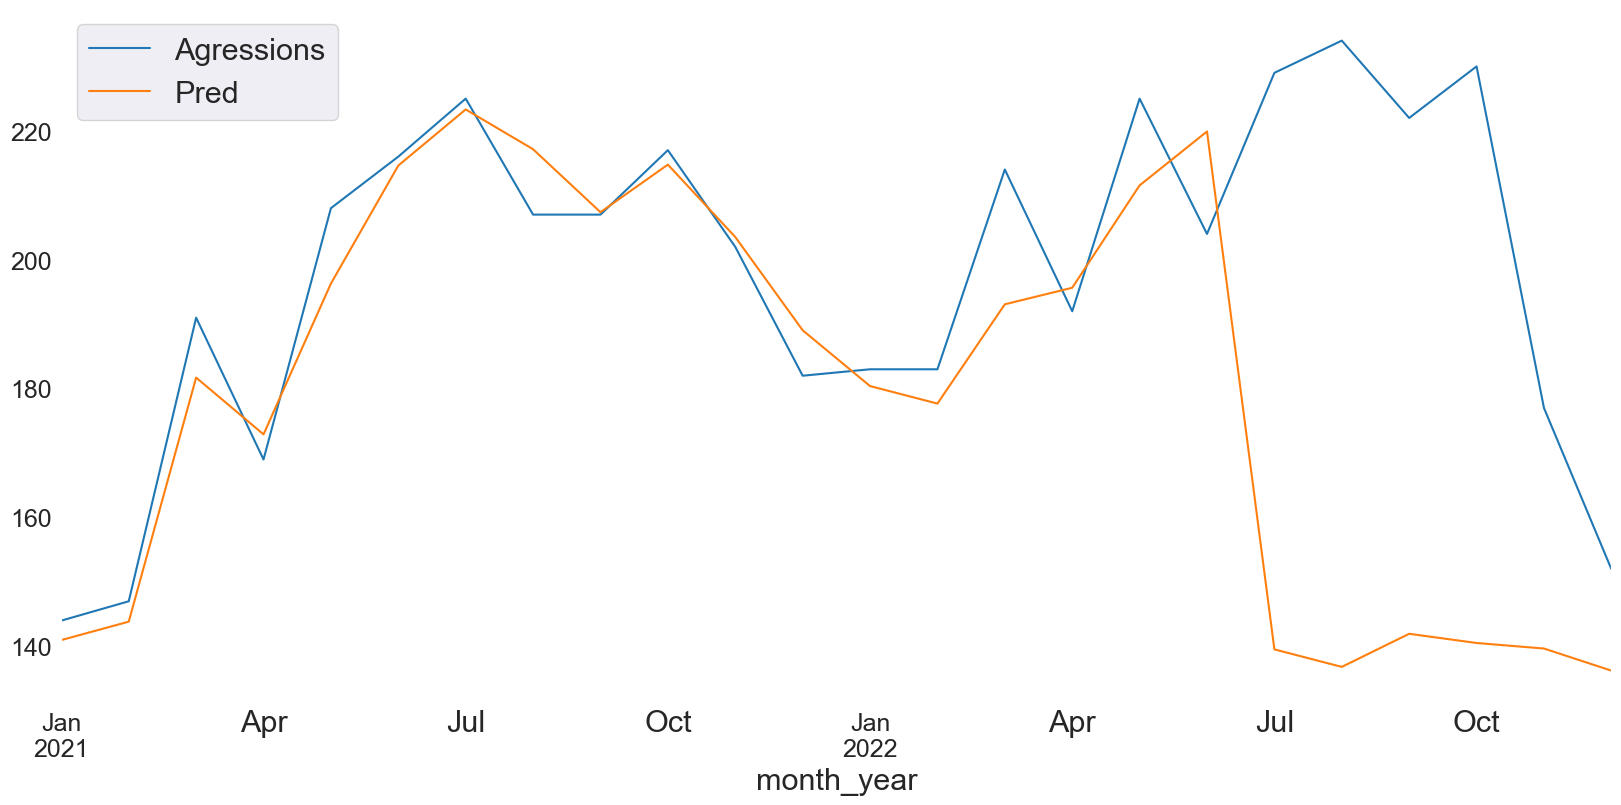

In [41]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

plt.rcParams.update({'font.size': 22})

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [105]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
Squared_error = sqr_err(test['Agressions'], test['Pred'])

test['MSE'] = sqr_err(test['Agressions'], test['Pred'])
test

Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-01-01         183  179.936225      203.75  6.131099  11.325039  6.120603   
2022-02-01         183  195.539317      203.75  6.131099  11.325039  6.120603   
2022-03-01         214  180.939625      203.75  6.131099  11.325039  6.120603   
2022-04-01         192  176.723261      203.75  6.131099  11.325039  6.120603   
2022-05-01         225  220.861452      203.75  6.131099  11.325039  6.120603   
2022-06-01         204  223.207499      203.75  6.131099  11.325039  6.120603   
2022-07-01         229  232.048243      203.75  6.131099  11.325039  6.120603   
2022-08-01         234  236.078677      203.75  6.131099  11.325039  6.120603   
2022-09-01         222  233.630494      203.75  6.131099  11.325039  6.120603   
2022-10-01         230  215.480486      203.75  6.131099  11.325039  6.120603   
2022-11-01         177  175.978816      203.75  6.131099  11.325039  6.120603   
2022-12-01         152  176.378568      203.75  6.131099  11.325039  6.120603   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-02-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-03-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-04-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-05-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-06-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-07-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-08-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-09-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-10-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-11-01    11.15879  11.996911  21.958333          50.0          41.666667   
2022-12-01    11.15879  11.996911  21.958333          50.0          41.666667   

                 RMSE  RMSE mean          MSE  
month_year                                     
2022-01-01  15.367983  25.040384     9.386720  
2022-02-01  15.367983  25.040384   157.234482  
2022-03-01  15.367983  25.040384  1092.988373  
2022-04-01  15.367983  25.040384   233.378742  
2022-05-01  15.367983  25.040384    17.127576  
2022-06-01  15.367983  25.040384   368.928018  
2022-07-01  15.367983  25.040384     9.291786  
2022-08-01  15.367983  25.040384     4.320899  
2022-09-01  15.367983  25.040384   135.268384  
2022-10-01  15.367983  25.040384   210.816274  
2022-11-01  15.367983  25.040384     1.042816  
2022-12-01  15.367983  25.040384   594.314588

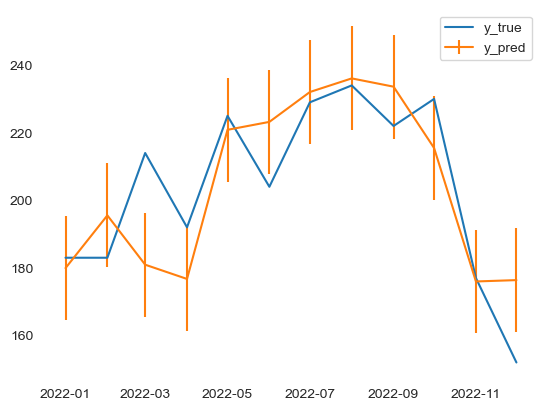

In [106]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

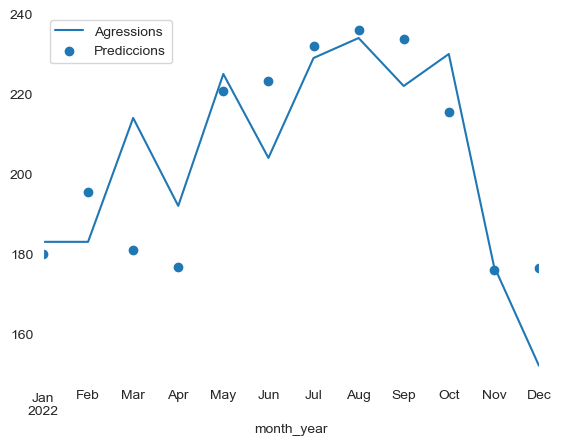

In [107]:
test.plot(y=["Agressions"])
plt.scatter(x=test.index, y=test['Pred'])
plt.legend(['Agressions', 'Prediccions'])
plt.show()

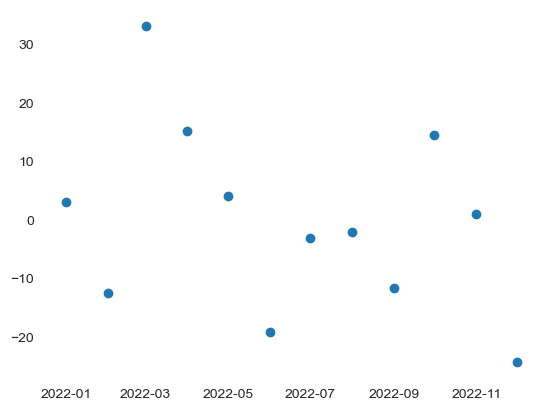

In [108]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

<AxesSubplot:xlabel='month_year'>

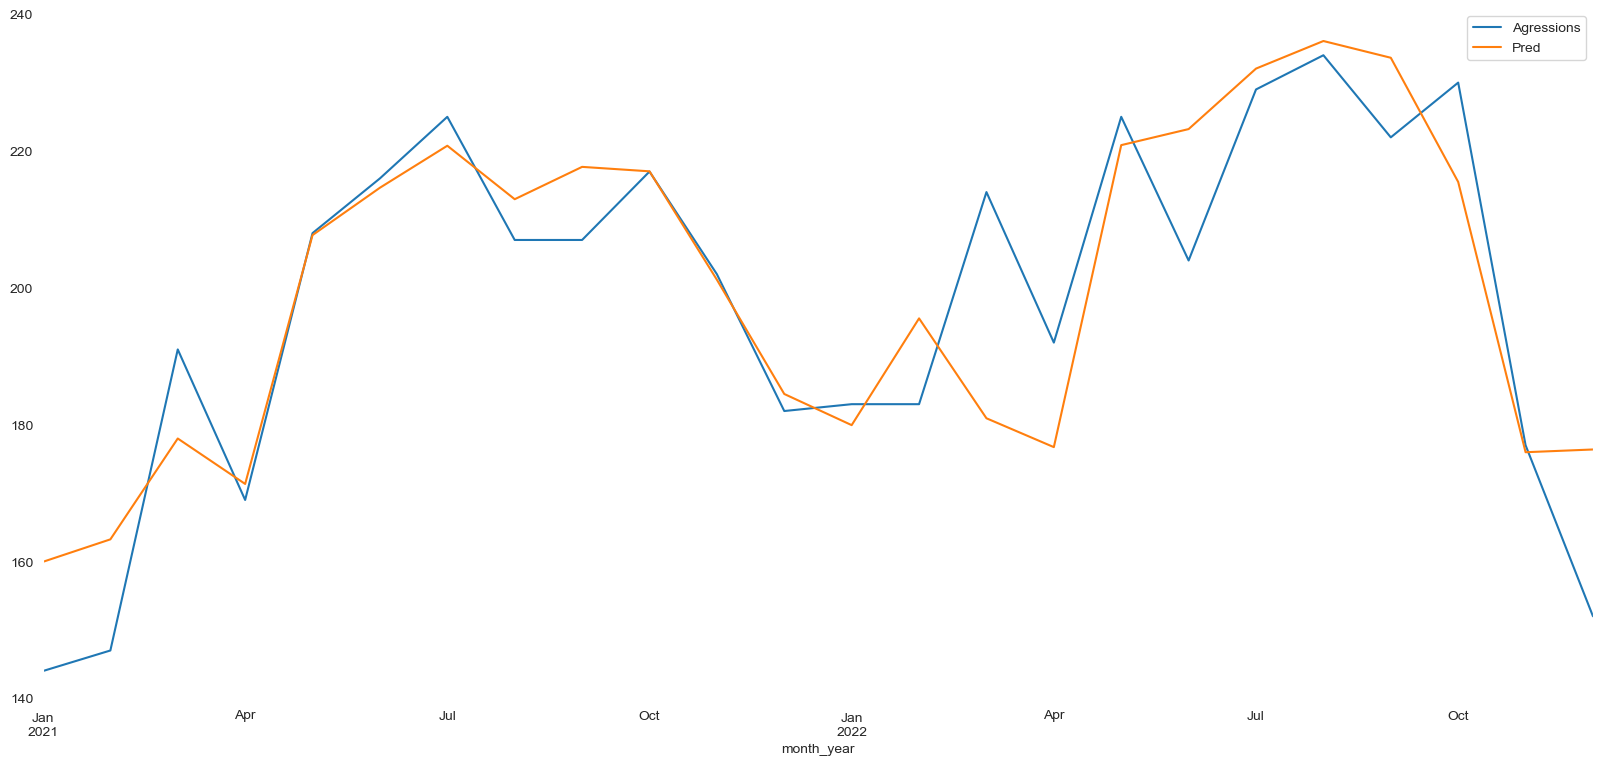

In [109]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-13]
d = d.set_index('month_year')
d = d[-24:]

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')

d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [110]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model     MAPE  MAPE mean     SMAPE  \
month_year                                                                     
2022-01-01         183  196.797394      203.75  5.82895  11.325039  5.891672   
2022-02-01         183  181.701187      203.75  5.82895  11.325039  5.891672   
2022-03-01         214  188.877457      203.75  5.82895  11.325039  5.891672   
2022-04-01         192  174.354218      203.75  5.82895  11.325039  5.891672   
2022-05-01         225  211.558487      203.75  5.82895  11.325039  5.891672   
2022-06-01         204  221.735916      203.75  5.82895  11.325039  5.891672   
2022-07-01         229  224.063934      203.75  5.82895  11.325039  5.891672   
2022-08-01         234  229.583633      203.75  5.82895  11.325039  5.891672   
2022-09-01         222  217.608780      203.75  5.82895  11.325039  5.891672   
2022-10-01         230  210.068039      203.75  5.82895  11.325039  5.891672   
2022-11-01         177  180.990463      203.75  5.82895  11.325039  5.891672   
2022-12-01         152  165.921051      203.75  5.82895  11.325039  5.891672   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-02-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-03-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-04-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-05-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-06-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-07-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-08-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-09-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-10-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-11-01    11.29926  11.719091  21.958333     33.333333          41.666667   
2022-12-01    11.29926  11.719091  21.958333     33.333333          41.666667   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-01-01  13.844259  25.040384  191.663516  
2022-02-01  13.844259  25.040384  191.663516  
2022-03-01  13.844259  25.040384  191.663516  
2022-04-01  13.844259  25.040384  191.663516  
2022-05-01  13.844259  25.040384  191.663516  
2022-06-01  13.844259  25.040384  191.663516  
2022-07-01  13.844259  25.040384  191.663516  
2022-08-01  13.844259  25.040384  191.663516  
2022-09-01  13.844259  25.040384  191.663516  
2022-10-01  13.844259  25.040384  191.663516  
2022-11-01  13.844259  25.040384  191.663516  
2022-12-01  13.844259  25.040384  191.663516

In [332]:
X = nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X,y, '2022-01', 12)
# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_split=10, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 15, subsample = 0.6, colsample_bytree = 0.6, colsample_bylevel = 1, random_state=0)
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.8 + rf_pred_train * 0.2
total_pred_test = xg_pred_test * 0.8 + rf_pred_test * 0.2


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = total_pred_test


test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-01-01         183  192.027096      203.75  5.114698  11.325039  5.178249   
2022-02-01         183  184.939931      203.75  5.114698  11.325039  5.178249   
2022-03-01         214  184.434682      203.75  5.114698  11.325039  5.178249   
2022-04-01         192  177.257855      203.75  5.114698  11.325039  5.178249   
2022-05-01         225  218.169315      203.75  5.114698  11.325039  5.178249   
2022-06-01         204  221.222800      203.75  5.114698  11.325039  5.178249   
2022-07-01         229  228.264280      203.75  5.114698  11.325039  5.178249   
2022-08-01         234  234.680527      203.75  5.114698  11.325039  5.178249   
2022-09-01         222  224.816372      203.75  5.114698  11.325039  5.178249   
2022-10-01         230  210.917776      203.75  5.114698  11.325039  5.178249   
2022-11-01         177  180.956220      203.75  5.114698  11.325039  5.178249   
2022-12-01         152  167.198147      203.75  5.114698  11.325039  5.178249   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-02-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-03-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-04-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-05-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-06-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-07-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-08-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-09-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-10-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-11-01   11.246758  10.149765  21.958333     58.333333          41.666667   
2022-12-01   11.246758  10.149765  21.958333     58.333333          41.666667   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-01-01  13.353142  25.040384  178.306392  
2022-02-01  13.353142  25.040384  178.306392  
2022-03-01  13.353142  25.040384  178.306392  
2022-04-01  13.353142  25.040384  178.306392  
2022-05-01  13.353142  25.040384  178.306392  
2022-06-01  13.353142  25.040384  178.306392  
2022-07-01  13.353142  25.040384  178.306392  
2022-08-01  13.353142  25.040384  178.306392  
2022-09-01  13.353142  25.040384  178.306392  
2022-10-01  13.353142  25.040384  178.306392  
2022-11-01  13.353142  25.040384  178.306392  
2022-12-01  13.353142  25.040384  178.306392

In [256]:
train = y_train.to_frame()
train['Pred']  = total_pred_train
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

any_total['Average Model'] = d['Pred']

In [257]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
# nf = nf.loc[new_df_mesos.index.year >=2018]

In [258]:
X = nf.drop(columns = 'Agressions')
y = nf['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]
y = new_df_mesos['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X,y, '2022-01', 12)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# train['ds'] = train['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')


test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# test['ds'] = test['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')




# Prophet
model = Prophet(holidays = hol,
                changepoint_prior_scale = 0.08,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'multiplicative',
                yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f.index =f.index.to_timestamp('s').strftime('%Y-%m-%d')
f = f.reset_index().rename(columns={'month_year': 'ds'}).set_index('ds')
f.index = pd.to_datetime(f.index)
test['Agressions'] = f.iloc[-12:]
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])


test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model     MAPE  MAPE mean     SMAPE  \
ds                                                                             
2022-01-01  211.121133         183      203.75  7.41802  11.325039  7.440183   
2022-02-01  187.585759         183      203.75  7.41802  11.325039  7.440183   
2022-03-01  184.710436         214      203.75  7.41802  11.325039  7.440183   
2022-04-01  191.286577         192      203.75  7.41802  11.325039  7.440183   
2022-05-01  207.704688         225      203.75  7.41802  11.325039  7.440183   
2022-06-01  214.155605         204      203.75  7.41802  11.325039  7.440183   
2022-07-01  227.503003         229      203.75  7.41802  11.325039  7.440183   
2022-08-01  218.272741         234      203.75  7.41802  11.325039  7.440183   
2022-09-01  208.695499         222      203.75  7.41802  11.325039  7.440183   
2022-10-01  201.635467         230      203.75  7.41802  11.325039  7.440183   
2022-11-01  170.974091         177      203.75  7.41802  11.325039  7.440183   
2022-12-01  175.279779         152      203.75  7.41802  11.325039  7.440183   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                              
2022-01-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-02-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-03-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-04-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-05-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-06-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-07-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-08-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-09-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-10-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-11-01   11.251541  14.863314  21.958333     33.333333          41.666667   
2022-12-01   11.251541  14.863314  21.958333     33.333333          41.666667   

                 RMSE  RMSE mean        MSE  
ds                                           
2022-01-01  17.985834  25.040384  323.49023  
2022-02-01  17.985834  25.040384  323.49023  
2022-03-01  17.985834  25.040384  323.49023  
2022-04-01  17.985834  25.040384  323.49023  
2022-05-01  17.985834  25.040384  323.49023  
2022-06-01  17.985834  25.040384  323.49023  
2022-07-01  17.985834  25.040384  323.49023  
2022-08-01  17.985834  25.040384  323.49023  
2022-09-01  17.985834  25.040384  323.49023  
2022-10-01  17.985834  25.040384  323.49023  
2022-11-01  17.985834  25.040384  323.49023  
2022-12-01  17.985834  25.040384  323.49023

In [259]:
train = y_train.to_frame()
p_pred_train_y=p_pred_train_y.set_index('ds')
train['Pred']  = p_pred_train_y['yhat']
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['ds','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('level_0').rename(columns={'level_0':'month_year'})
d = d[-24:]

any_total['Prophet'] = d['Pred']

In [231]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X,y, '2022-01', 12)


model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      min_samples_split=10, n_estimators=400, random_state=0)
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-01-01         183  188.560801      203.75  6.493075  11.325039  6.497571   
2022-02-01         183  186.360992      203.75  6.493075  11.325039  6.497571   
2022-03-01         214  184.853733      203.75  6.493075  11.325039  6.497571   
2022-04-01         192  178.874272      203.75  6.493075  11.325039  6.497571   
2022-05-01         225  212.679809      203.75  6.493075  11.325039  6.497571   
2022-06-01         204  216.554485      203.75  6.493075  11.325039  6.497571   
2022-07-01         229  222.611476      203.75  6.493075  11.325039  6.497571   
2022-08-01         234  228.343089      203.75  6.493075  11.325039  6.497571   
2022-09-01         222  220.216436      203.75  6.493075  11.325039  6.497571   
2022-10-01         230  207.043741      203.75  6.493075  11.325039  6.497571   
2022-11-01         177  189.972851      203.75  6.493075  11.325039  6.497571   
2022-12-01         152  178.804928      203.75  6.493075  11.325039  6.497571   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-02-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-03-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-04-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-05-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-06-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-07-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-08-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-09-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-10-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-11-01   11.175848  12.719292  21.958333     41.666667          41.666667   
2022-12-01   11.175848  12.719292  21.958333     41.666667          41.666667   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-01-01  15.446667  25.040384  238.599534  
2022-02-01  15.446667  25.040384  238.599534  
2022-03-01  15.446667  25.040384  238.599534  
2022-04-01  15.446667  25.040384  238.599534  
2022-05-01  15.446667  25.040384  238.599534  
2022-06-01  15.446667  25.040384  238.599534  
2022-07-01  15.446667  25.040384  238.599534  
2022-08-01  15.446667  25.040384  238.599534  
2022-09-01  15.446667  25.040384  238.599534  
2022-10-01  15.446667  25.040384  238.599534  
2022-11-01  15.446667  25.040384  238.599534  
2022-12-01  15.446667  25.040384  238.599534

In [241]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_split=10, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model     MAPE  MAPE mean     SMAPE  \
month_year                                                                     
2022-01-01         183  183.358448      203.75  5.95149  11.325039  5.937347   
2022-02-01         183  192.843084      203.75  5.95149  11.325039  5.937347   
2022-03-01         214  178.202634      203.75  5.95149  11.325039  5.937347   
2022-04-01         192  177.004359      203.75  5.95149  11.325039  5.937347   
2022-05-01         225  220.706698      203.75  5.95149  11.325039  5.937347   
2022-06-01         204  225.716574      203.75  5.95149  11.325039  5.937347   
2022-07-01         229  228.799278      203.75  5.95149  11.325039  5.937347   
2022-08-01         234  234.027608      203.75  5.95149  11.325039  5.937347   
2022-09-01         222  229.685910      203.75  5.95149  11.325039  5.937347   
2022-10-01         230  217.056344      203.75  5.95149  11.325039  5.937347   
2022-11-01         177  180.283626      203.75  5.95149  11.325039  5.937347   
2022-12-01         152  178.915217      203.75  5.95149  11.325039  5.937347   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-02-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-03-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-04-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-05-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-06-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-07-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-08-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-09-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-10-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-11-01    11.13747  11.505096  21.958333     58.333333          41.666667   
2022-12-01    11.13747  11.505096  21.958333     58.333333          41.666667   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-01-01  15.956297  25.040384  254.603421  
2022-02-01  15.956297  25.040384  254.603421  
2022-03-01  15.956297  25.040384  254.603421  
2022-04-01  15.956297  25.040384  254.603421  
2022-05-01  15.956297  25.040384  254.603421  
2022-06-01  15.956297  25.040384  254.603421  
2022-07-01  15.956297  25.040384  254.603421  
2022-08-01  15.956297  25.040384  254.603421  
2022-09-01  15.956297  25.040384  254.603421  
2022-10-01  15.956297  25.040384  254.603421  
2022-11-01  15.956297  25.040384  254.603421  
2022-12-01  15.956297  25.040384  254.603421

In [242]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

any_total = pd.DataFrame()
any_total = d[['Agressions', 'Pred']]
any_total = any_total.rename(columns={'Pred':'Random Forest'})

In [243]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
xg_pred_train = random_search.predict(X_train) 
xg_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = xg_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'subsample': 0.6, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}


Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-01-01         183  197.221298      203.75  5.233381  11.325039  5.365839   
2022-02-01         183  174.865341      203.75  5.233381  11.325039  5.365839   
2022-03-01         214  183.548920      203.75  5.233381  11.325039  5.365839   
2022-04-01         192  174.779449      203.75  5.233381  11.325039  5.365839   
2022-05-01         225  223.925888      203.75  5.233381  11.325039  5.365839   
2022-06-01         204  220.426224      203.75  5.233381  11.325039  5.365839   
2022-07-01         229  231.472809      203.75  5.233381  11.325039  5.365839   
2022-08-01         234  236.280487      203.75  5.233381  11.325039  5.365839   
2022-09-01         222  220.974060      203.75  5.233381  11.325039  5.365839   
2022-10-01         230  205.872742      203.75  5.233381  11.325039  5.365839   
2022-11-01         177  171.638596      203.75  5.233381  11.325039  5.365839   
2022-12-01         152  156.287231      203.75  5.233381  11.325039  5.365839   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-01-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-02-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-03-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-04-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-05-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-06-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-07-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-08-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-09-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-10-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-11-01   11.391167  10.590254  21.958333     41.666667          41.666667   
2022-12-01   11.391167  10.590254  21.958333     41.666667          41.666667   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-01-01  14.156347  25.040384  200.402146  
2022-02-01  14.156347  25.040384  200.402146  
2022-03-01  14.156347  25.040384  200.402146  
2022-04-01  14.156347  25.040384  200.402146  
2022-05-01  14.156347  25.040384  200.402146  
2022-06-01  14.156347  25.040384  200.402146  
2022-07-01  14.156347  25.040384  200.402146  
2022-08-01  14.156347  25.040384  200.402146  
2022-09-01  14.156347  25.040384  200.402146  
2022-10-01  14.156347  25.040384  200.402146  
2022-11-01  14.156347  25.040384  200.402146  
2022-12-01  14.156347  25.040384  200.402146

In [253]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-01', 12)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 15, subsample = 0.6, colsample_bytree = 0.6, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-12:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model     MAPE  MAPE mean     SMAPE  \
month_year                                                                     
2022-01-01         183  195.742233      203.75  4.88787  11.325039  4.965159   
2022-02-01         183  181.552872      203.75  4.88787  11.325039  4.965159   
2022-03-01         214  187.105560      203.75  4.88787  11.325039  4.965159   
2022-04-01         192  177.366501      203.75  4.88787  11.325039  4.965159   
2022-05-01         225  217.081863      203.75  4.88787  11.325039  4.965159   
2022-06-01         204  219.296890      203.75  4.88787  11.325039  4.965159   
2022-07-01         229  228.034988      203.75  4.88787  11.325039  4.965159   
2022-08-01         234  234.960342      203.75  4.88787  11.325039  4.965159   
2022-09-01         222  222.729431      203.75  4.88787  11.325039  4.965159   
2022-10-01         230  208.286957      203.75  4.88787  11.325039  4.965159   
2022-11-01         177  181.244476      203.75  4.88787  11.325039  4.965159   
2022-12-01         152  162.176544      203.75  4.88787  11.325039  4.965159   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-01-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-02-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-03-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-04-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-05-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-06-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-07-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-08-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-09-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-10-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-11-01   11.296602  9.810098  21.958333          50.0          41.666667   
2022-12-01   11.296602  9.810098  21.958333          50.0          41.666667   

                RMSE  RMSE mean         MSE  
month_year                                   
2022-01-01  12.89063  25.040384  166.168339  
2022-02-01  12.89063  25.040384  166.168339  
2022-03-01  12.89063  25.040384  166.168339  
2022-04-01  12.89063  25.040384  166.168339  
2022-05-01  12.89063  25.040384  166.168339  
2022-06-01  12.89063  25.040384  166.168339  
2022-07-01  12.89063  25.040384  166.168339  
2022-08-01  12.89063  25.040384  166.168339  
2022-09-01  12.89063  25.040384  166.168339  
2022-10-01  12.89063  25.040384  166.168339  
2022-11-01  12.89063  25.040384  166.168339  
2022-12-01  12.89063  25.040384  166.168339

In [254]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

any_total['XGBoost'] = d['Pred']

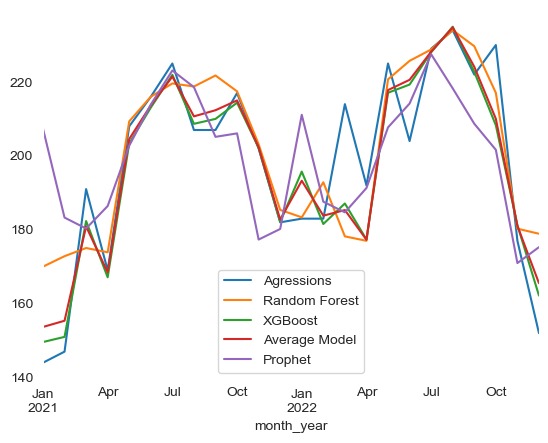

In [260]:
any_total.plot()
plt.show()

(-70.0, 70.0)

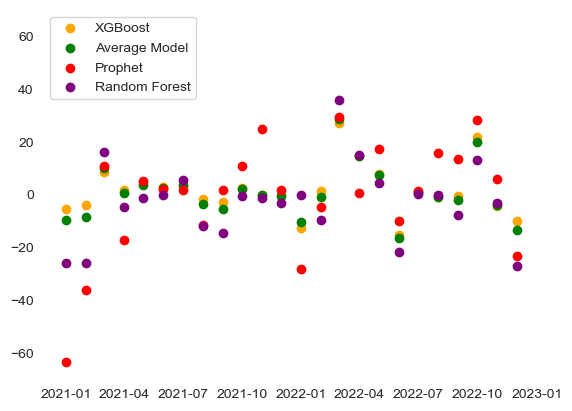

In [261]:
any_total['res_XGBoost'] = any_total['Agressions'] - any_total['XGBoost']
any_total['res_Avg_Model'] = any_total['Agressions'] - any_total['Average Model']
any_total['res_Prophet'] = any_total['Agressions'] - any_total['Prophet']
any_total['res_RF'] = any_total['Agressions'] - any_total['Random Forest']

fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
ax1.scatter(x=any_total.index, y= any_total['res_XGBoost'], label='XGBoost', color='orange')
ax1.scatter(x=any_total.index, y= any_total['res_Avg_Model'], label='Average Model', color='green')
ax1.scatter(x=any_total.index, y= any_total['res_Prophet'], label='Prophet', color='red')
ax1.scatter(x=any_total.index, y= any_total['res_RF'], label='Random Forest', color='purple')

plt.legend(loc='upper left')
plt.ylim(-70,70)

In [ ]:
############################6 MESOS #################################

In [42]:
# nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = new_df_mesos.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = sqr_err(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07-01         229  139.855046  207.333333  31.324053   15.14335   
2022-08-01         234  136.244704  207.333333  31.324053   15.14335   
2022-09-01         222  141.421291  207.333333  31.324053   15.14335   
2022-10-01         230  140.349473  207.333333  31.324053   15.14335   
2022-11-01         177  139.970867  207.333333  31.324053   15.14335   
2022-12-01         152  135.211594  207.333333  31.324053   15.14335   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07-01  38.159224      17.356  68.491171  28.555556           0.0   
2022-08-01  38.159224      17.356  68.491171  28.555556           0.0   
2022-09-01  38.159224      17.356  68.491171  28.555556           0.0   
2022-10-01  38.159224      17.356  68.491171  28.555556           0.0   
2022-11-01  38.159224      17.356  68.491171  28.555556           0.0   
2022-12-01  38.159224      17.356  68.491171  28.555556           0.0   

            Metrica nomb mean       RMSE  RMSE mean          MSE  
month_year                                                        
2022-07-01          33.333333  74.928937  31.335106  7946.822889  
2022-08-01          33.333333  74.928937  31.335106  9556.097825  
2022-09-01          33.333333  74.928937  31.335106  6492.928397  
2022-10-01          33.333333  74.928937  31.335106  8037.216953  
2022-11-01          33.333333  74.928937  31.335106  1371.156686  
2022-12-01          33.333333  74.928937  31.335106   281.850568

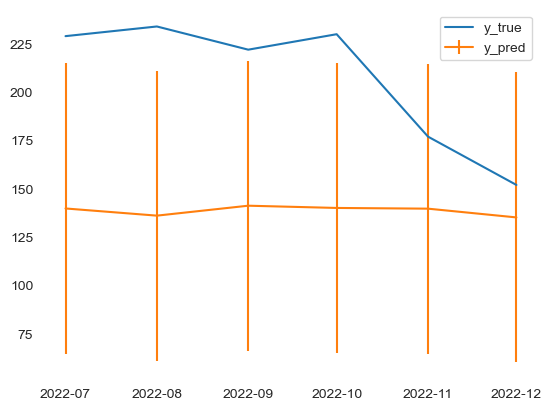

In [126]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

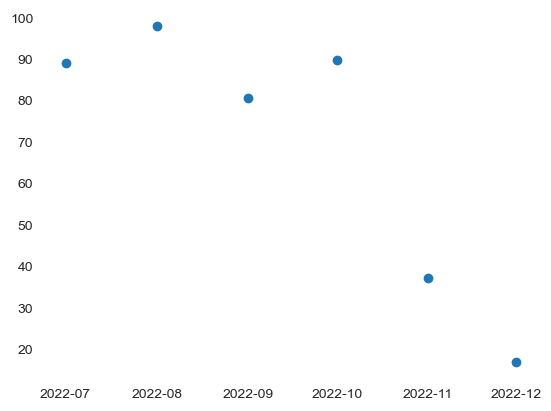

In [127]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

<AxesSubplot:xlabel='month_year'>

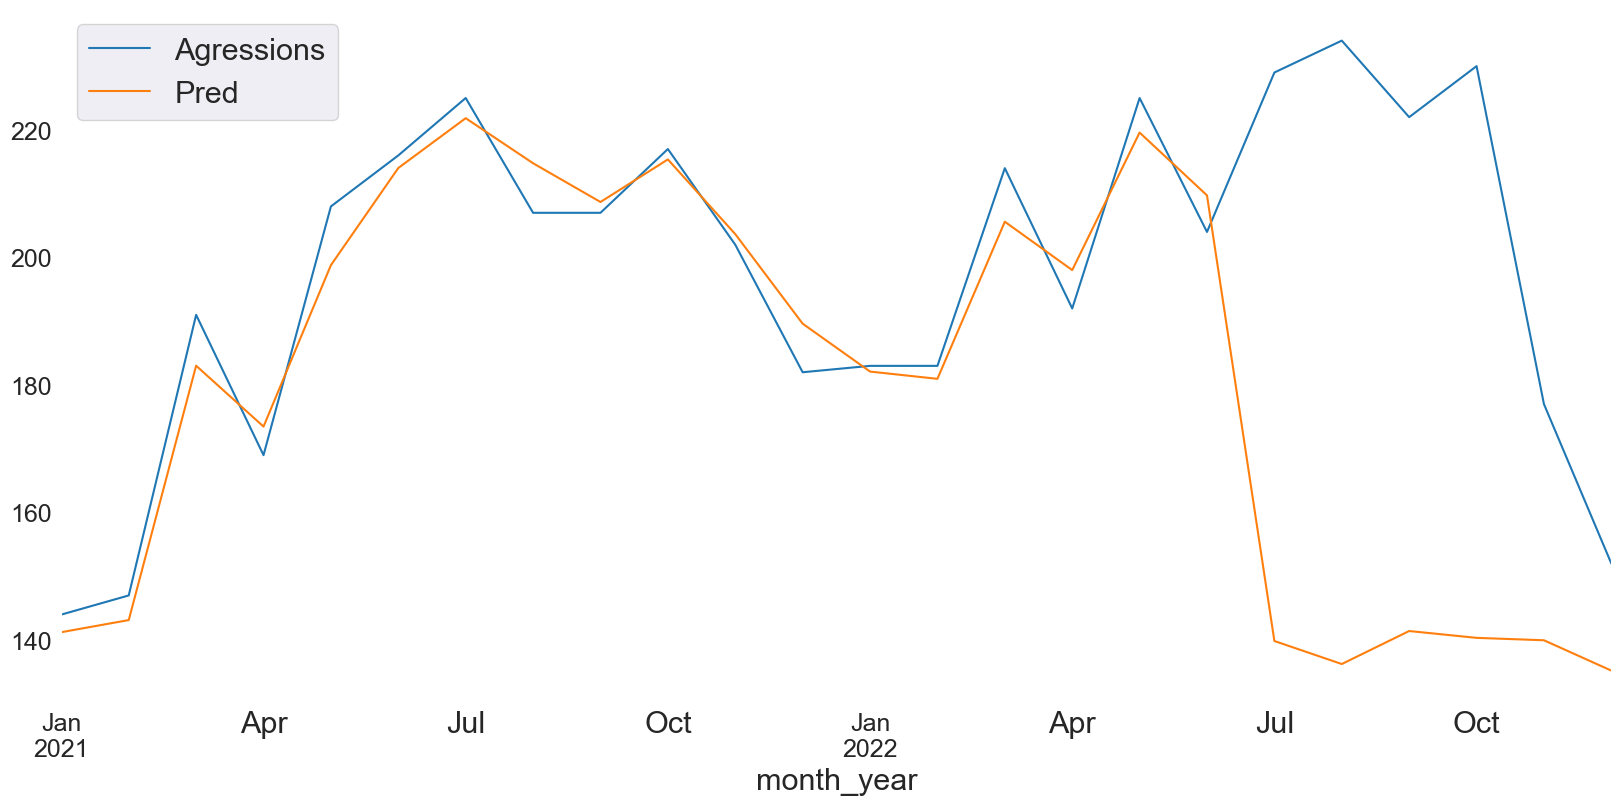

In [44]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [129]:
residuals_test2 = pd.DataFrame()
residuals_test2['Dif_jul'] = test['Agressions'] - test['Pred']
residuals_test2

Dif_jul
month_year           
2022-07-01  89.172445
2022-08-01  97.883302
2022-09-01  80.741209
2022-10-01  89.902121
2022-11-01  37.274023
2022-12-01  16.803217

<AxesSubplot:xlabel='month_year'>

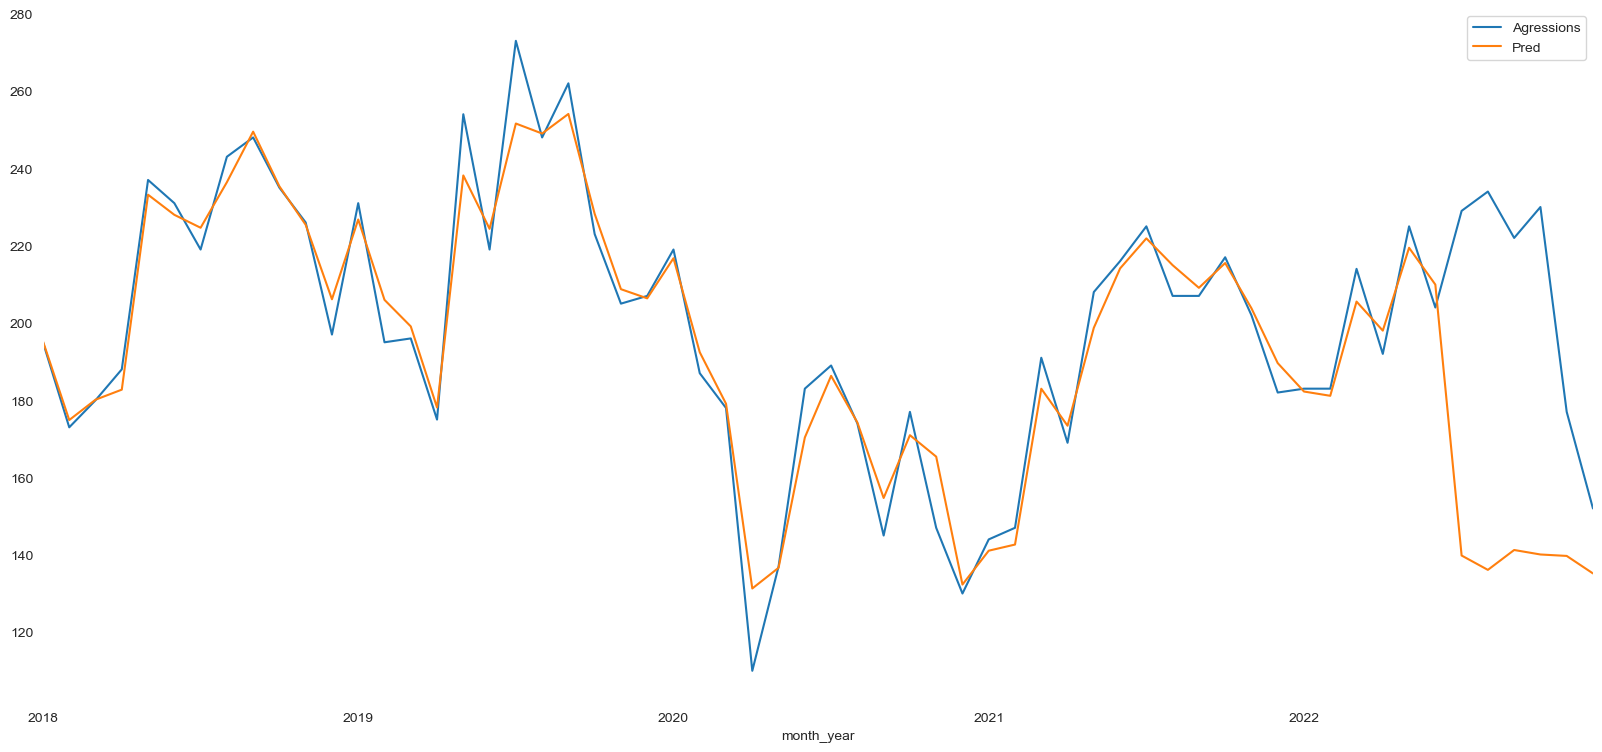

In [131]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-13]
d = d.set_index('month_year')
d

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

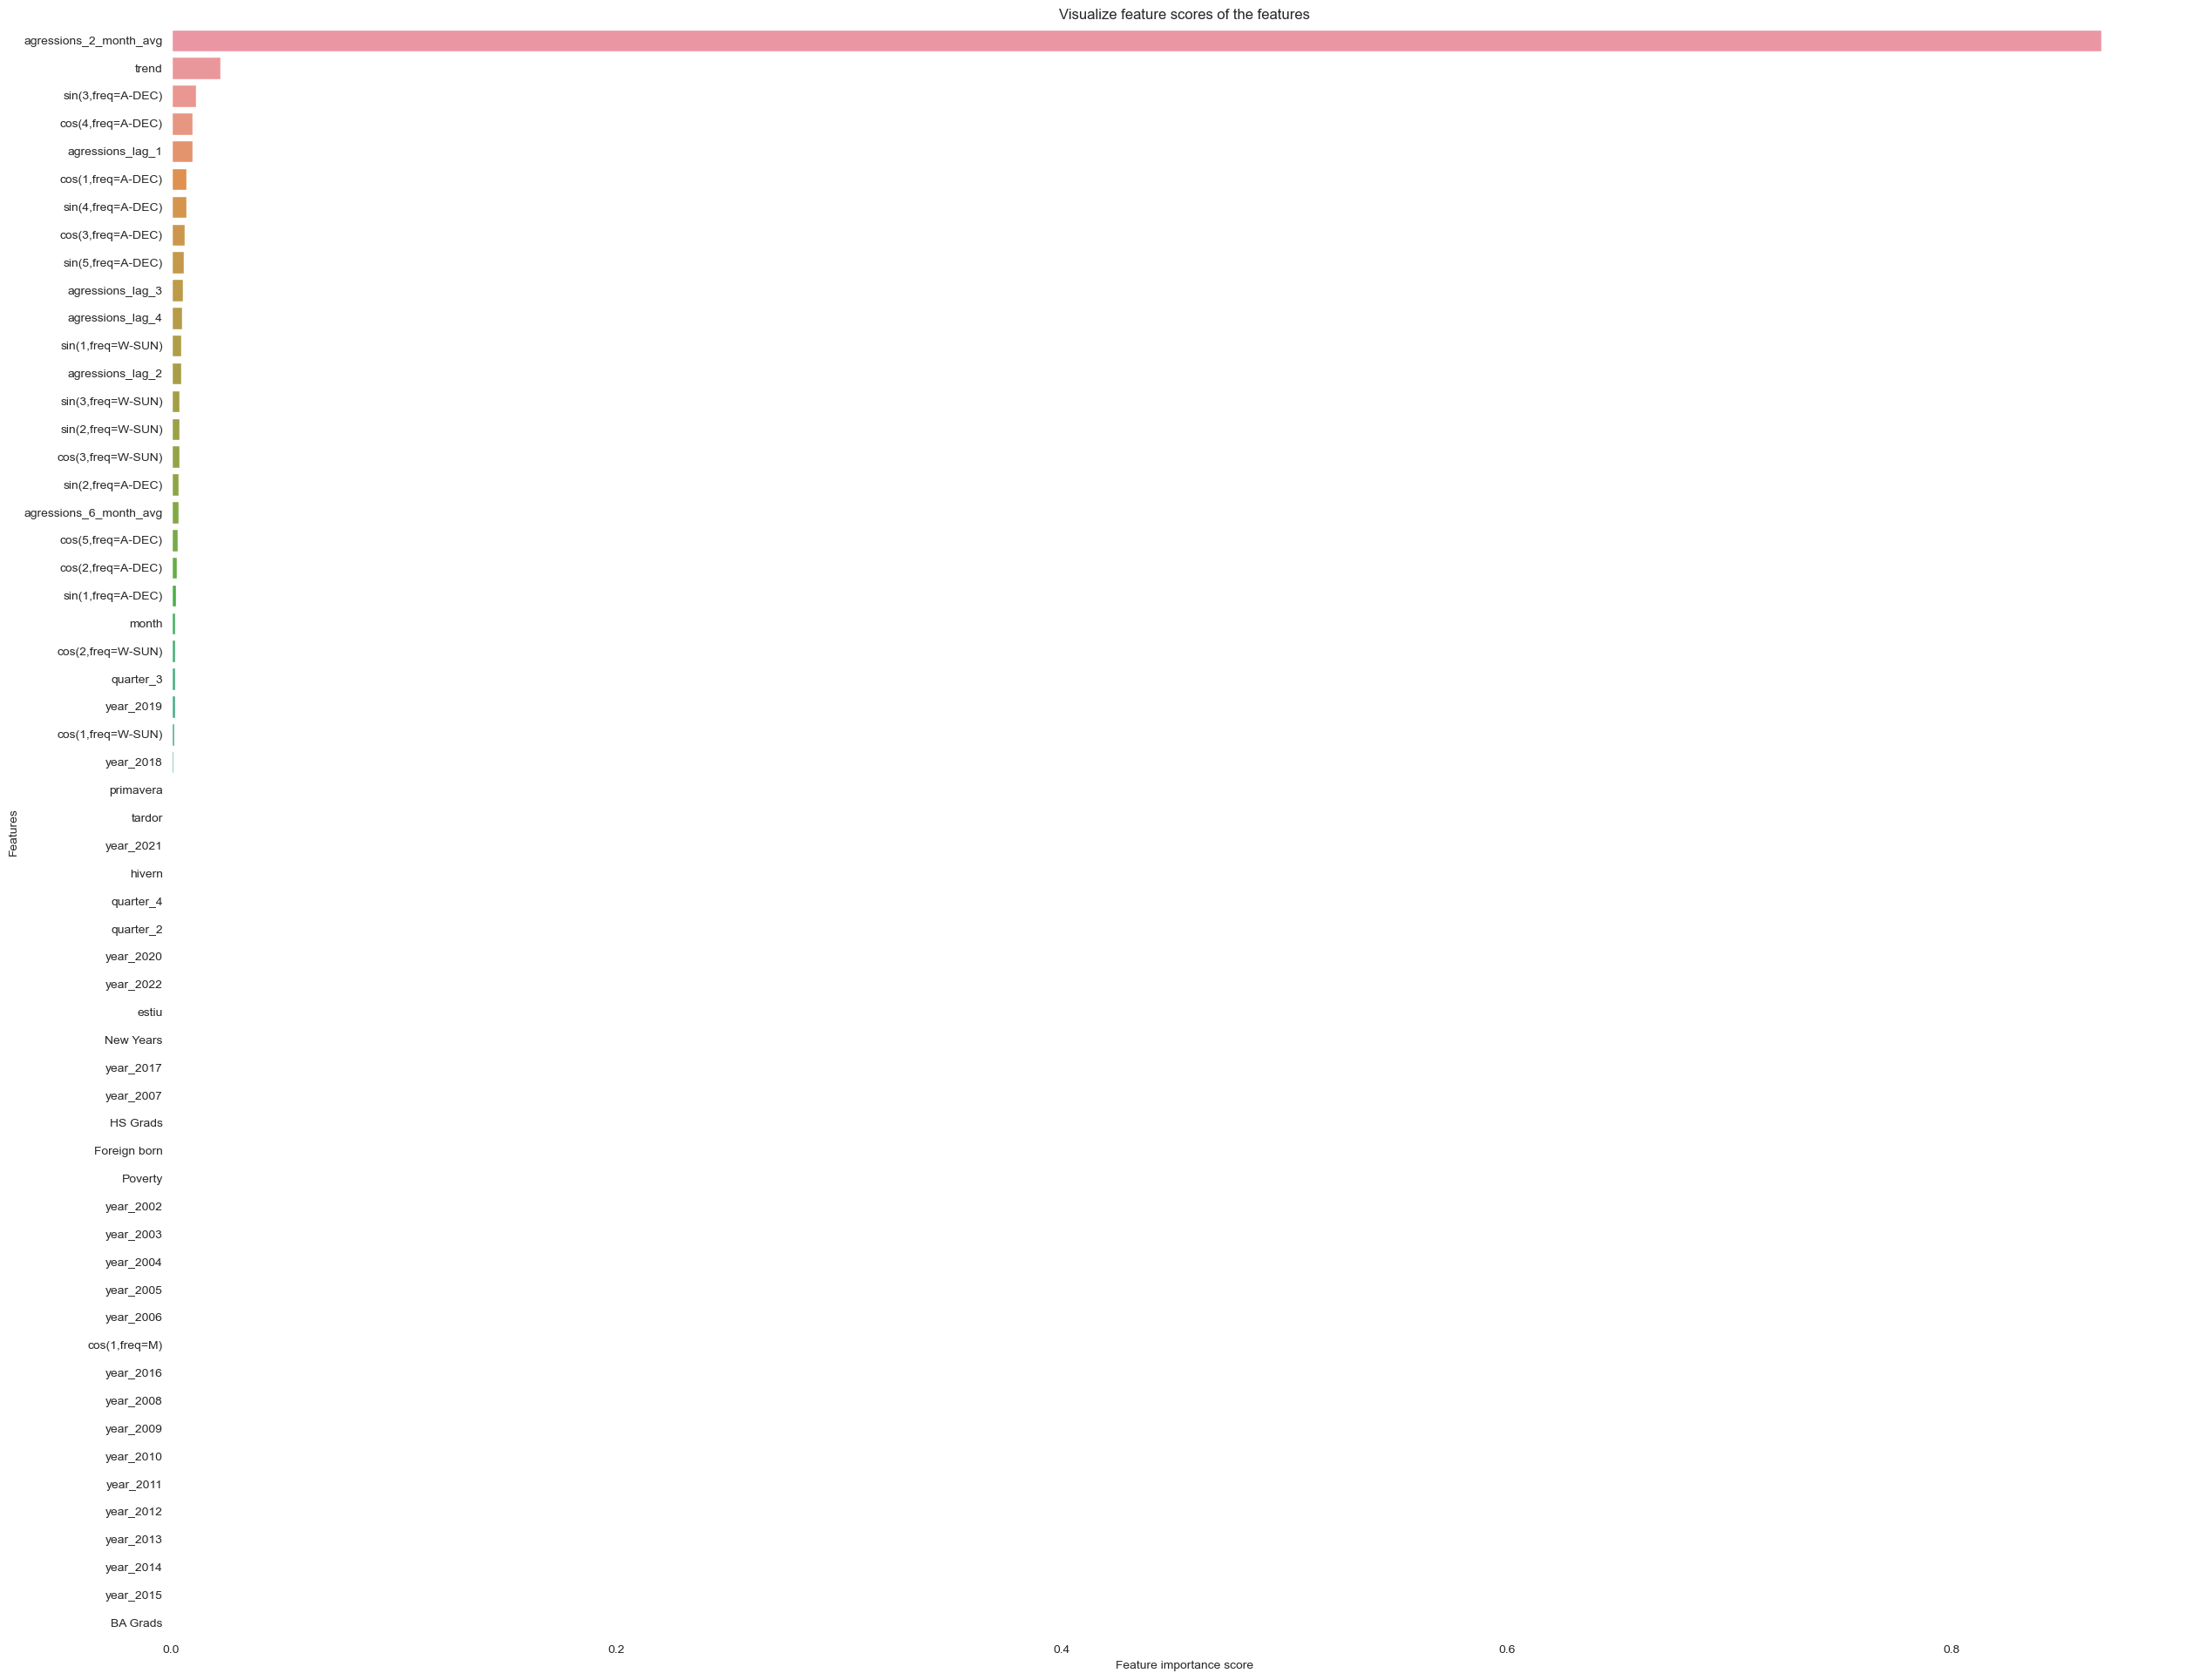

In [132]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

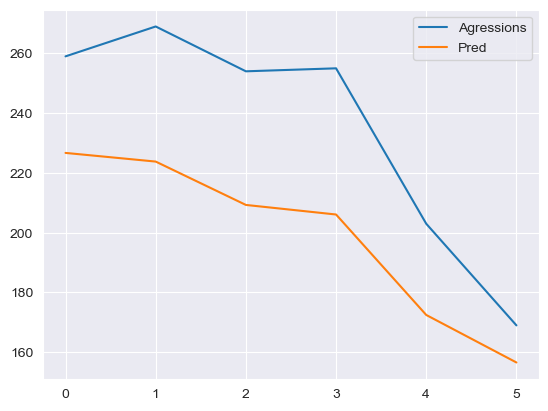

In [125]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [ ]:
##################### PRED 6 MESES ANTES ##############################

In [46]:
# nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'trend']) #
# nf = new_df_mesos.loc[new_df_mesos.index.year >=2018]
nf = new_df_mesos.iloc[:-6]

In [47]:
X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2021-12', 6)
# weights = create_sample_weights(X_train, '2022-07')

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 
# pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=6), RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0))
# pipe_modelado.fit(X=X_train, y=y_train)

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

# predicciones = pipe_modelado.predict(X=X_test)

test = y_test.to_frame()
# f = df_prova.groupby([df['month_year']]).size().to_frame()
# f = f.iloc[:-2]
# f = f.rename(columns = {0:'Agressions'})
# f.index = f.index.astype('string')
# f.index = pd.to_datetime(f.index)
# test['Agressions']  = f.iloc[-6:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = sqr_err(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-01-01       183.0  193.889081  200.166667  3.598942   7.065859  3.600177   
2022-02-01       183.0  171.857459  200.166667  3.598942   7.065859  3.600177   
2022-03-01       214.0  206.822816  200.166667  3.598942   7.065859  3.600177   
2022-04-01       192.0  189.528660  200.166667  3.598942   7.065859  3.600177   
2022-05-01       225.0  223.092585  200.166667  3.598942   7.065859  3.600177   
2022-06-01       204.0  212.294213  200.166667  3.598942   7.065859  3.600177   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-01-01    7.094337  6.980296  14.166667     33.333333               50.0   
2022-02-01    7.094337  6.980296  14.166667     33.333333               50.0   
2022-03-01    7.094337  6.980296  14.166667     33.333333               50.0   
2022-04-01    7.094337  6.980296  14.166667     33.333333               50.0   
2022-05-01    7.094337  6.980296  14.166667     33.333333               50.0   
2022-06-01    7.094337  6.980296  14.166667     33.333333               50.0   

                RMSE  RMSE mean         MSE  
month_year                                   
2022-01-01  7.882259  15.699434  118.572078  
2022-02-01  7.882259  15.699434  124.156228  
2022-03-01  7.882259  15.699434   51.511969  
2022-04-01  7.882259  15.699434    6.107522  
2022-05-01  7.882259  15.699434    3.638233  
2022-06-01  7.882259  15.699434   68.793969

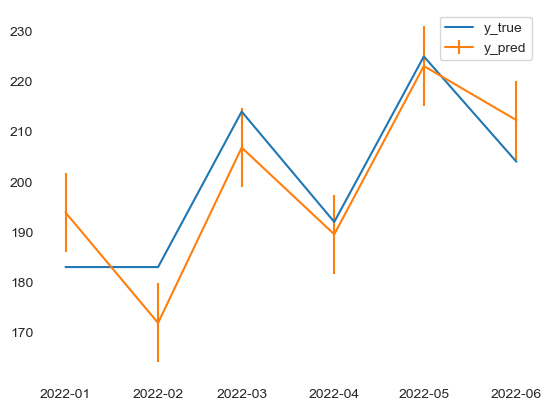

In [137]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

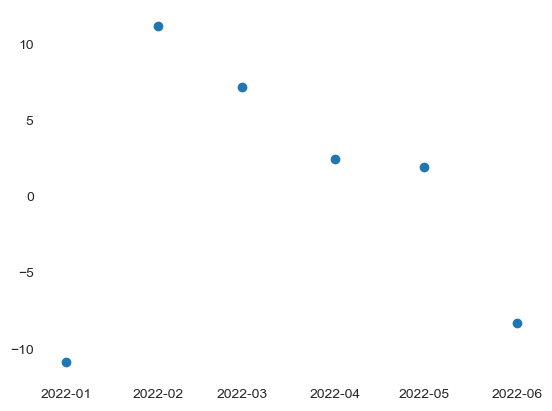

In [138]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

(array([120., 140., 160., 180., 200., 220., 240.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

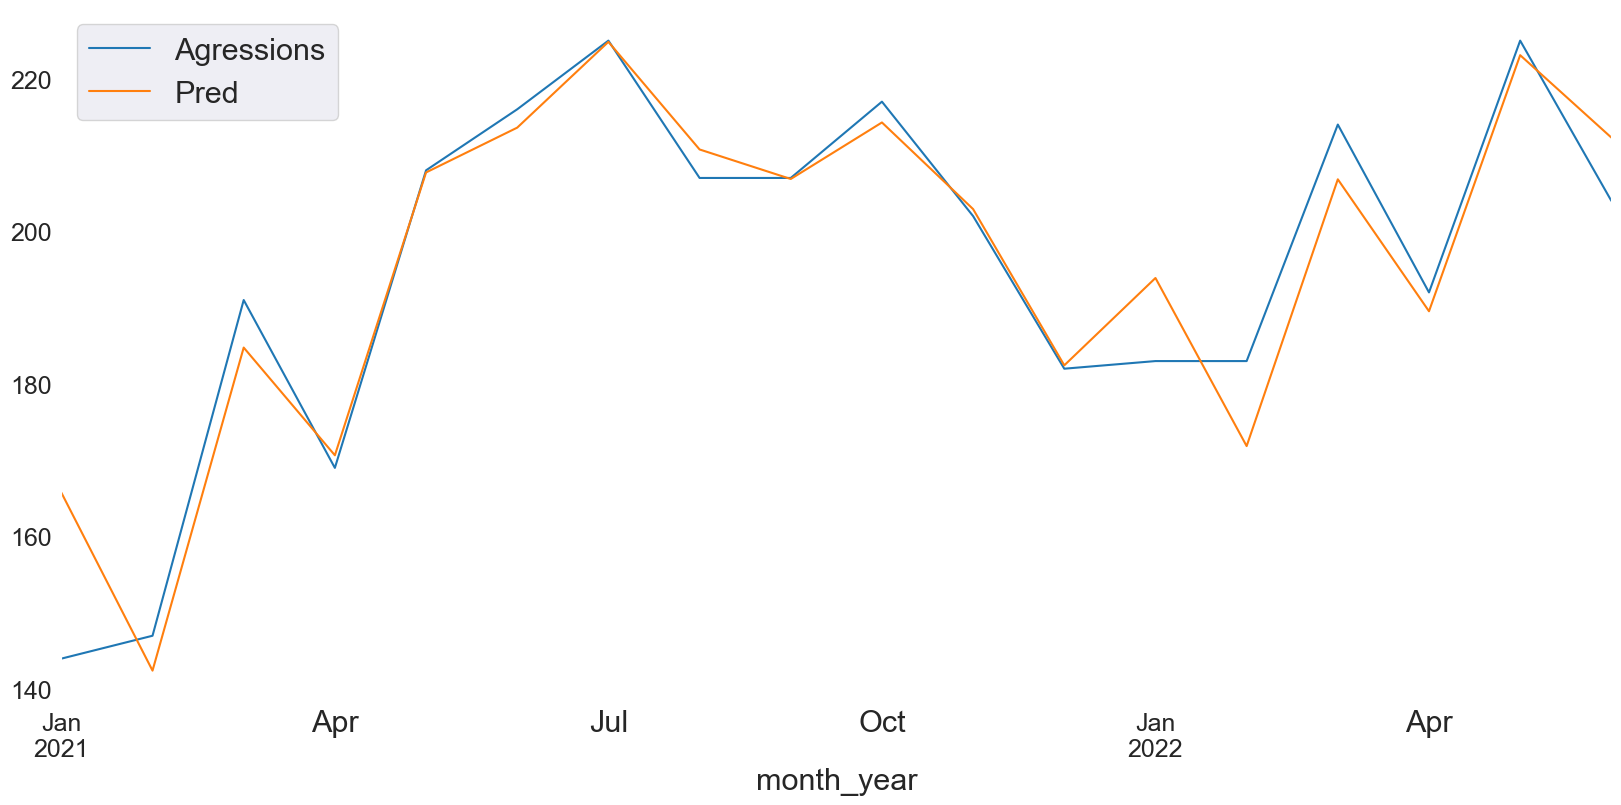

In [49]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-18:]

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')
d.plot(ax=ax)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [140]:
residuals_test1=pd.DataFrame()
residuals_test1['Dif_gener'] = test['Agressions'] - test['Pred']
residuals_test1

Dif_gener
month_year           
2022-01-01 -10.889081
2022-02-01  11.142541
2022-03-01   7.177184
2022-04-01   2.471340
2022-05-01   1.907415
2022-06-01  -8.294213

In [141]:
residuals_training=pd.DataFrame()
residuals_training['Dif_training'] = train['Agressions'] - rf_pred_train_y
residuals_training

Dif_training
month_year              
2001-01-01     98.358735
2001-02-01    -18.580176
2001-03-01      5.246813
2001-04-01     -5.353684
2001-05-01     11.906627
...                  ...
2021-08-01     -3.734798
2021-09-01      0.135170
2021-10-01      2.726013
2021-11-01     -0.917957
2021-12-01     -0.441853

[252 rows x 1 columns]

In [142]:
s = residuals_training.loc[residuals_training.index.year>2018]

In [143]:
residuals_test1

Dif_gener
month_year           
2022-01-01 -10.889081
2022-02-01  11.142541
2022-03-01   7.177184
2022-04-01   2.471340
2022-05-01   1.907415
2022-06-01  -8.294213

In [144]:
residuals_test2

Dif_jul
month_year           
2022-07-01  89.172445
2022-08-01  97.883302
2022-09-01  80.741209
2022-10-01  89.902121
2022-11-01  37.274023
2022-12-01  16.803217

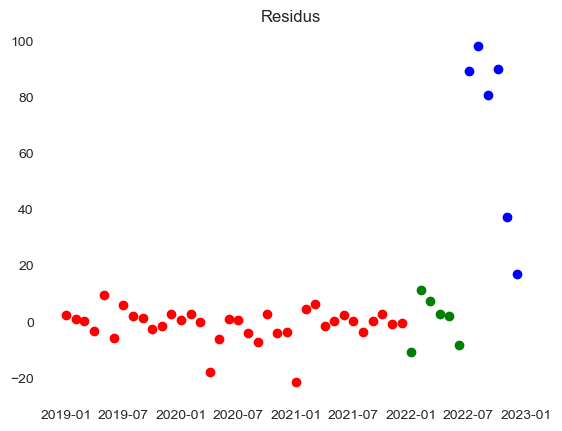

In [145]:
x1 = s.index
x2 = residuals_test1.index
x3 = residuals_test2.index

y1 = s['Dif_training']
y2 = residuals_test1['Dif_gener']
y3 = residuals_test2['Dif_jul']

plt.scatter(x1,y1,color='red')
plt.scatter(x2,y2,color='green')
plt.scatter(x3,y3,color='blue')
plt.title('Residus')
plt.show()

<AxesSubplot:xlabel='month_year'>

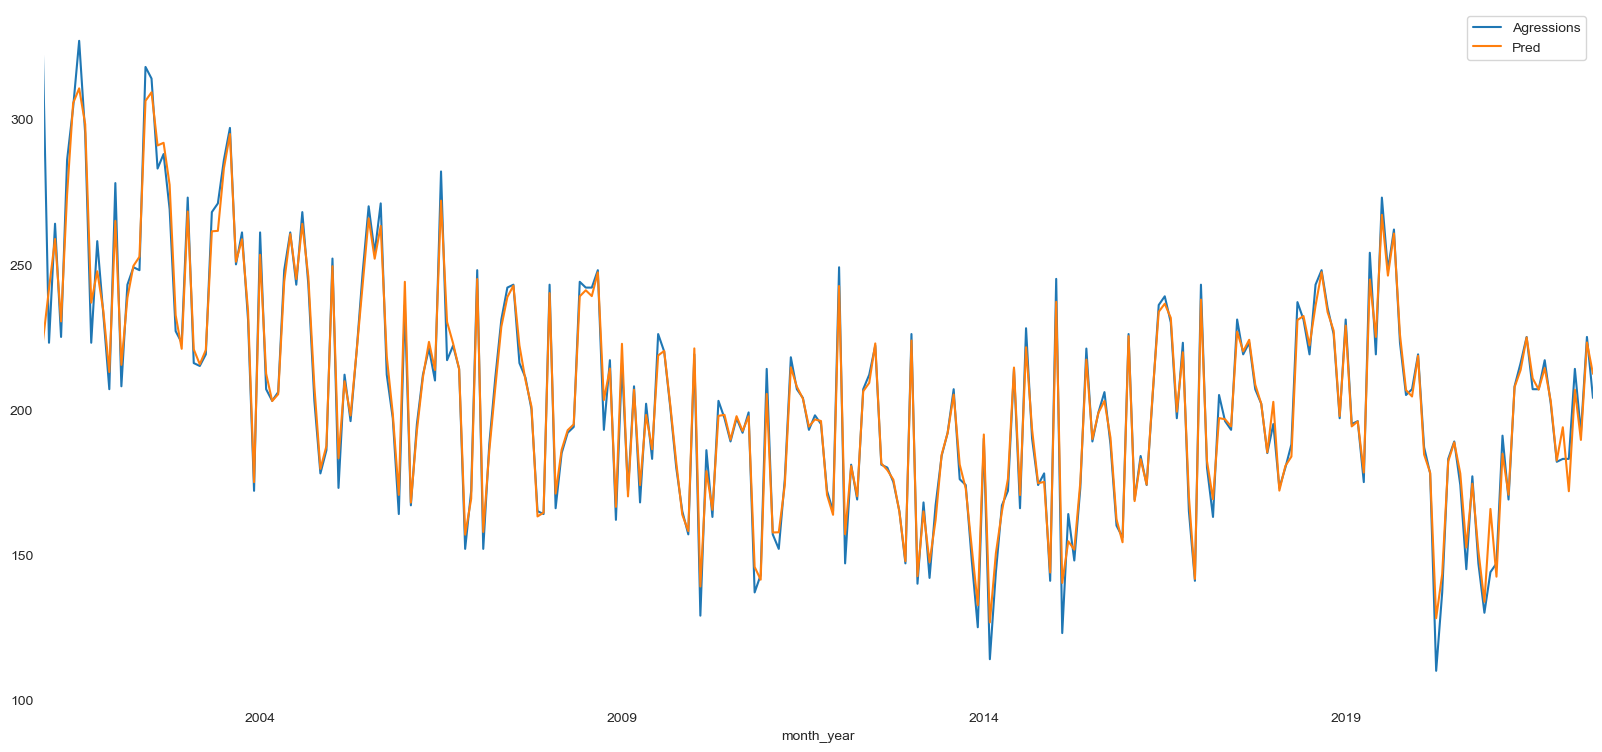

In [147]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-13]
d = d.set_index('month_year')
d

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

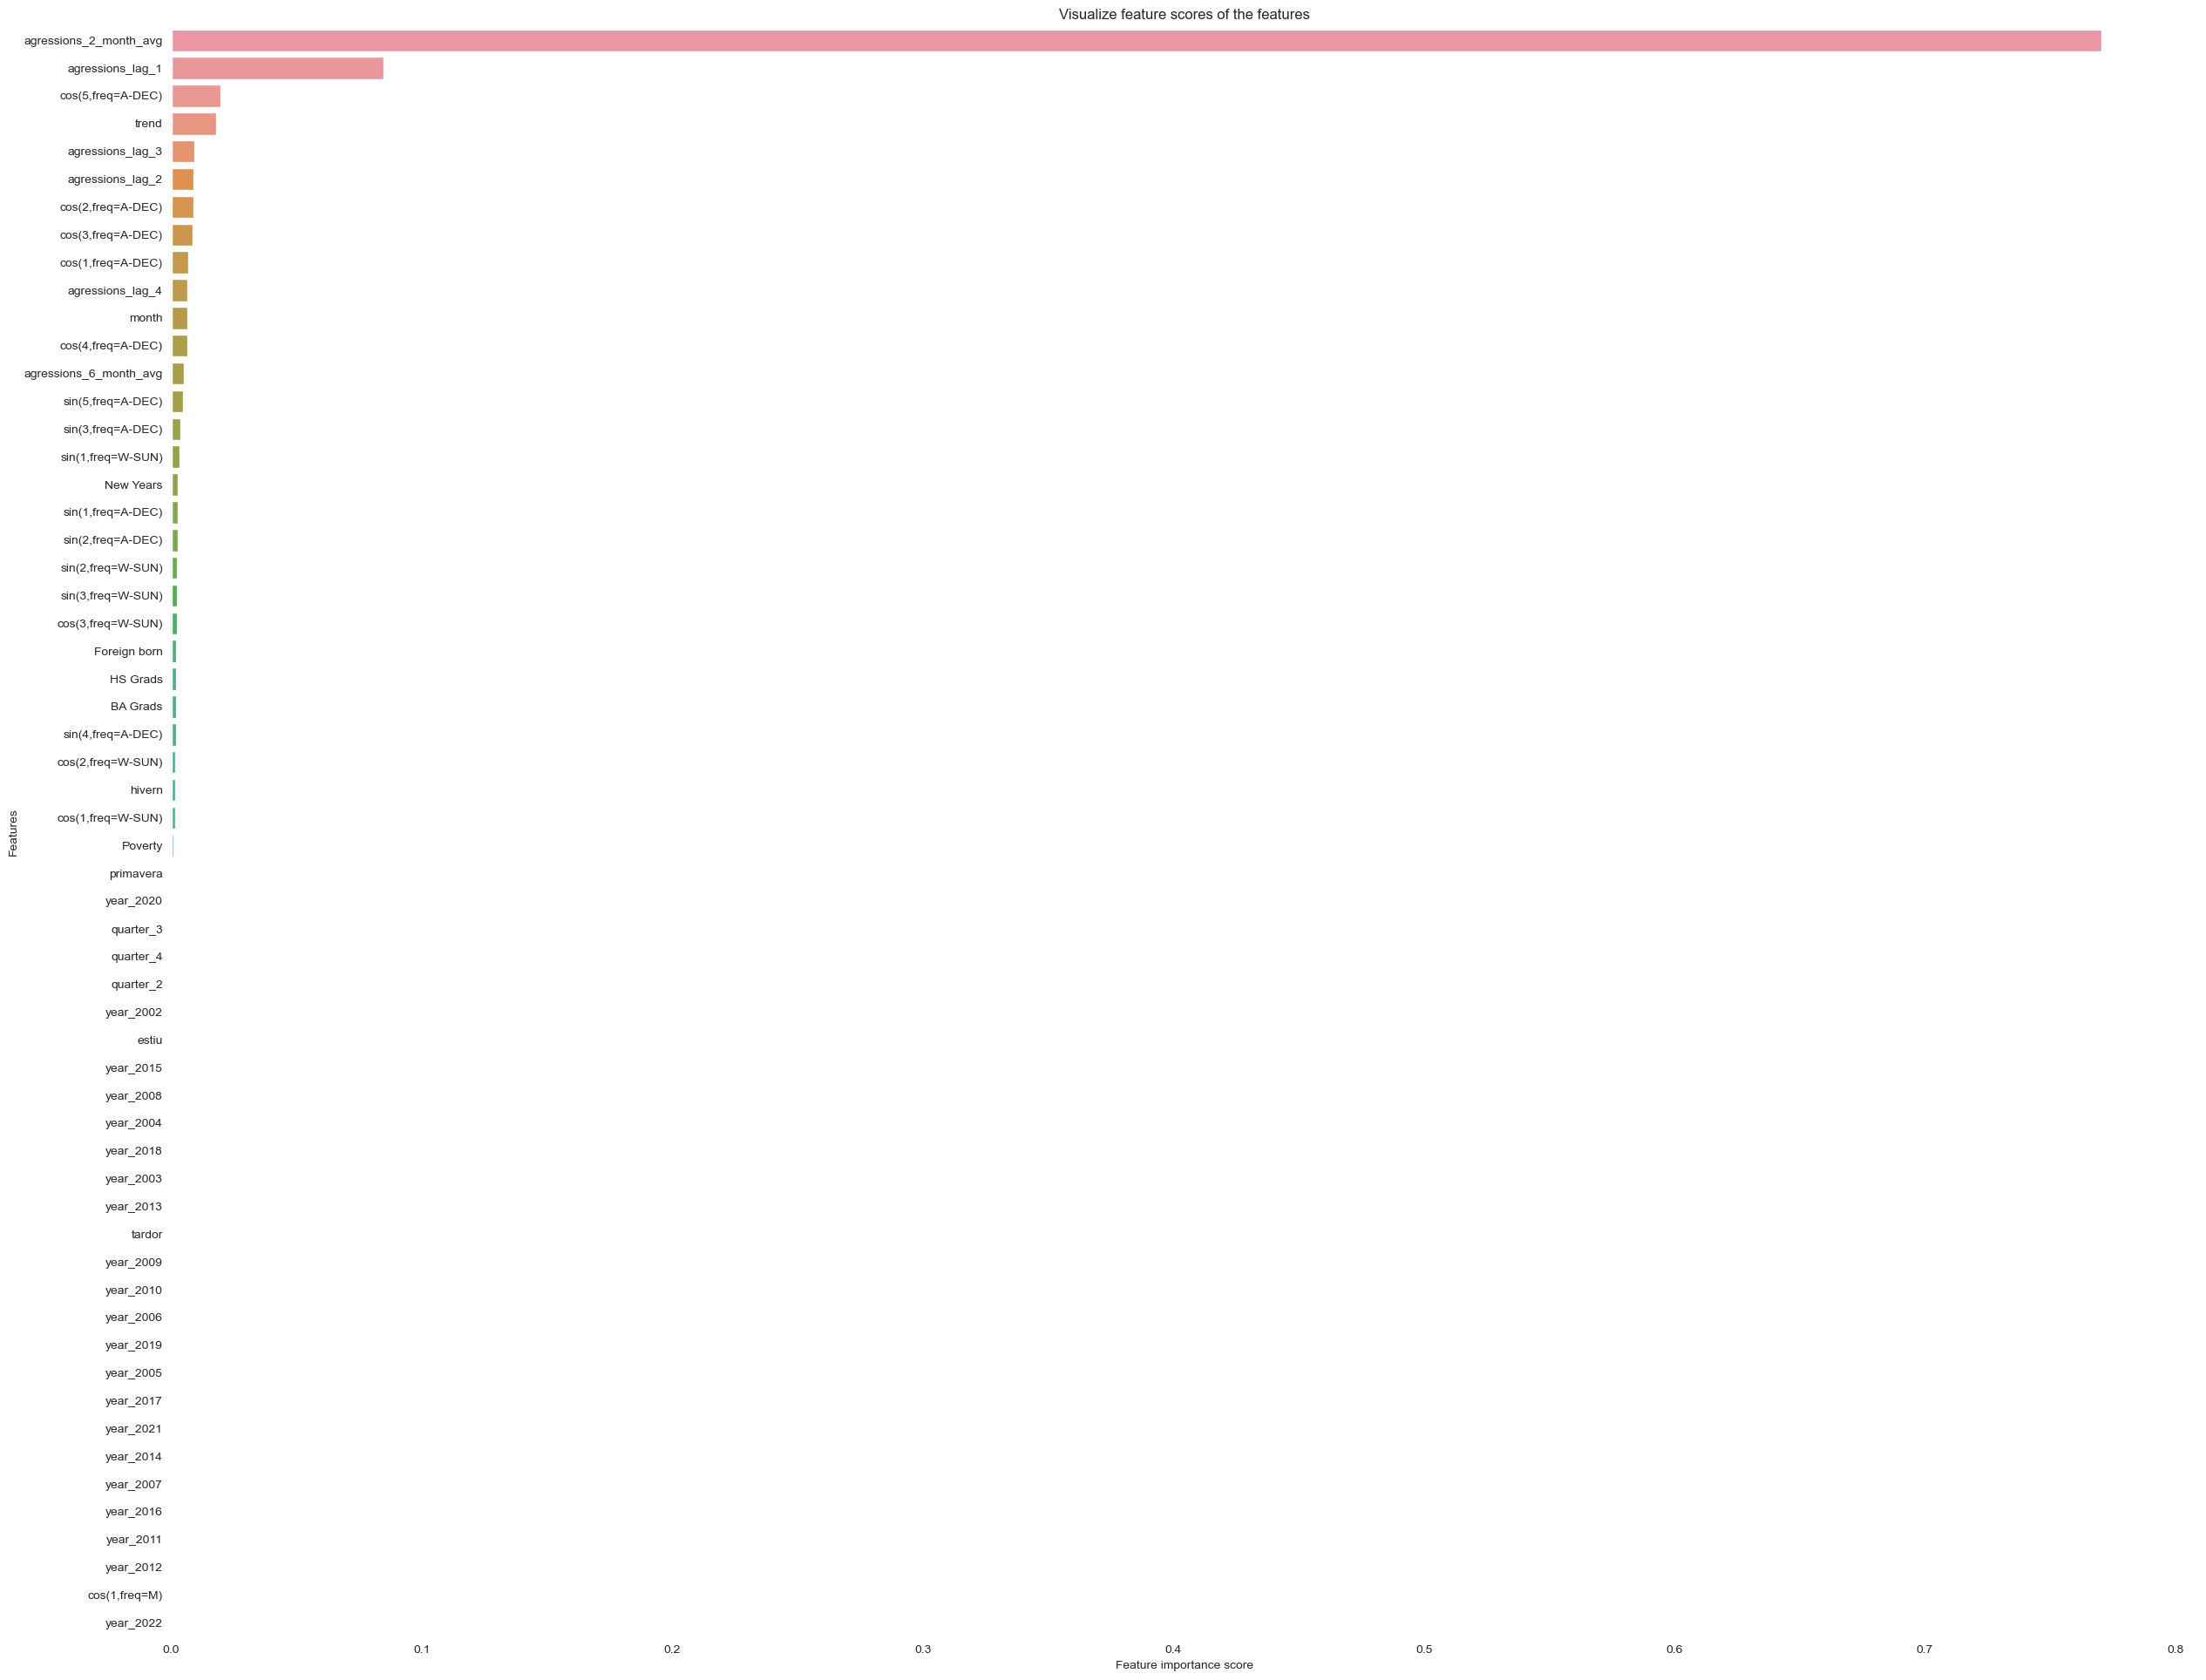

In [148]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

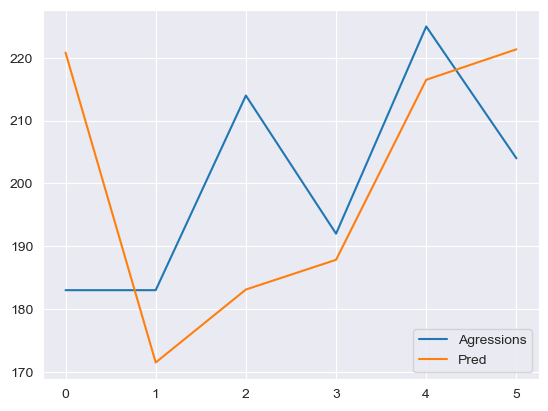

In [149]:
#treient les dos variables que marca camb més influència amb tots els anys
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

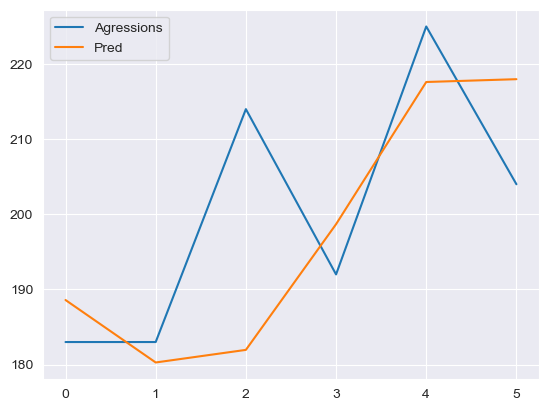

In [121]:
#treient les dos variables que marca camb més influència
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

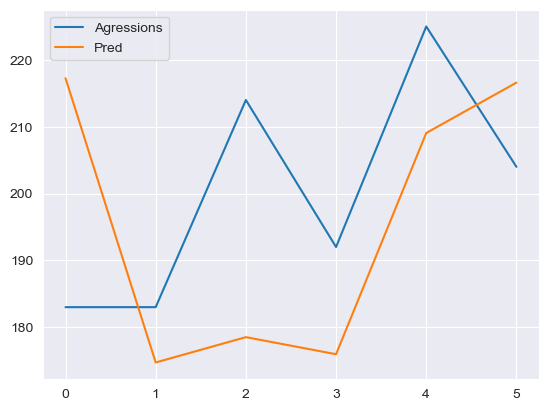

In [137]:
#treient totes les variables que a la predicció dels 6 mesos amb tots els anys
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

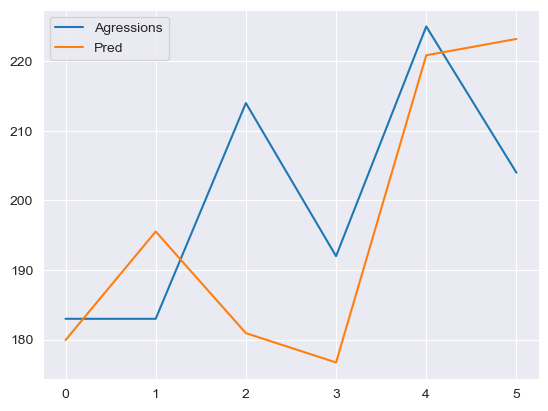

In [98]:
#treient totes les variables que a la predicció dels 6 mesos
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

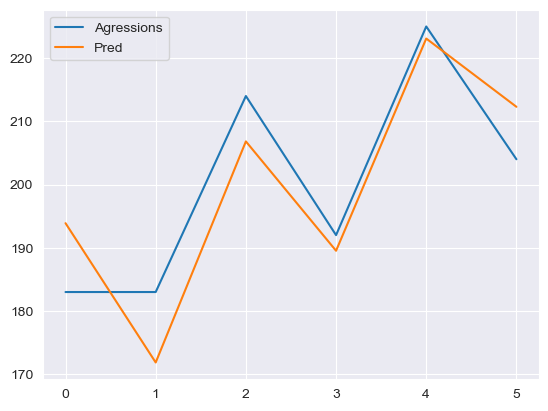

In [131]:
#sense treure variables amb tots els anys
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

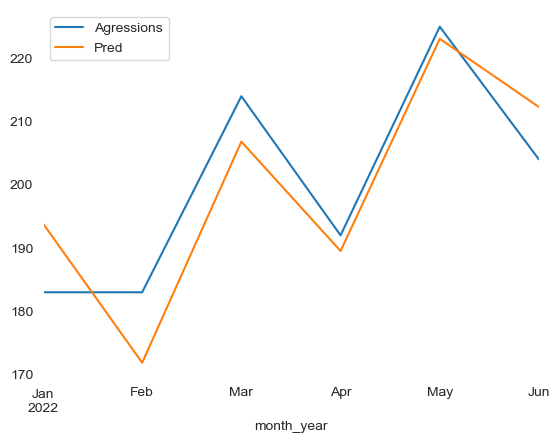

In [37]:
test = test.reset_index()
plt.rcParams['axes.facecolor'] = 'white'
test.plot(x= 'month_year', y=["Agressions","Pred"])
plt.show()

In [35]:
test

month_year  Agressions        Pred  Mean model      MAPE  MAPE mean  \
0 2022-01-01       183.0  193.889081  200.166667  3.598942   7.065859   
1 2022-02-01       183.0  171.857459  200.166667  3.598942   7.065859   
2 2022-03-01       214.0  206.822816  200.166667  3.598942   7.065859   
3 2022-04-01       192.0  189.528660  200.166667  3.598942   7.065859   
4 2022-05-01       225.0  223.092585  200.166667  3.598942   7.065859   
5 2022-06-01       204.0  212.294213  200.166667  3.598942   7.065859   

      SMAPE  SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
0  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   
1  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   
2  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   
3  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   
4  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   
5  3.600177    7.094337  6.980296  14.166667     33.333333               50.0   

       RMSE  RMSE mean  
0  7.882259  15.699434  
1  7.882259  15.699434  
2  7.882259  15.699434  
3  7.882259  15.699434  
4  7.882259  15.699434  
5  7.882259  15.699434

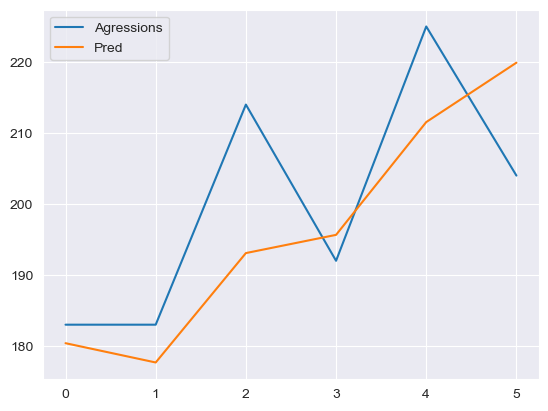

In [92]:
#sense treure variables
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [121]:
X= new_df_mesos.drop(columns = 'Agressions')
y = new_df_mesos['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)
# model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
# model.fit(X_train, y_train) 
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0))
pipe_modelado.fit(X=X_train, y=y_train)

# rf_pred_train_y = model.predict(X_train) 
# rf_pred_test_y = model.predict(X_test)

predicciones = pipe_modelado.predict(X=X_test)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = predicciones

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07-01         259  171.648127  234.833333  25.972454  15.353772   
2022-08-01         269  173.242182  234.833333  25.972454  15.353772   
2022-09-01         254  170.265603  234.833333  25.972454  15.353772   
2022-10-01         255  170.265603  234.833333  25.972454  15.353772   
2022-11-01         203  171.516063  234.833333  25.972454  15.353772   
2022-12-01         169  177.121513  234.833333  25.972454  15.353772   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07-01  30.783661   16.705792  65.197323  32.555556     16.666667   
2022-08-01  30.783661   16.705792  65.197323  32.555556     16.666667   
2022-09-01  30.783661   16.705792  65.197323  32.555556     16.666667   
2022-10-01  30.783661   16.705792  65.197323  32.555556     16.666667   
2022-11-01  30.783661   16.705792  65.197323  32.555556     16.666667   
2022-12-01  30.783661   16.705792  65.197323  32.555556     16.666667   

            Metrica nomb mean       RMSE  RMSE mean  
month_year                                           
2022-07-01          33.333333  73.084967  36.223458  
2022-08-01          33.333333  73.084967  36.223458  
2022-09-01          33.333333  73.084967  36.223458  
2022-10-01          33.333333  73.084967  36.223458  
2022-11-01          33.333333  73.084967  36.223458  
2022-12-01          33.333333  73.084967  36.223458

In [155]:
pca = PCA()
pca = pca.fit(new_df_mesos.drop(columns = 'Agressions'))
# #print(pca.explained_variance_[0])
df = pd.DataFrame(pca.transform(new_df_mesos.drop(columns = 'Agressions')), columns=['PCA%i' % i for i in range(58)], index=new_df_mesos.drop(columns = 'Agressions').index)

In [154]:
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]

In [156]:
x1 = df.loc[:date['date_end_train'],:].PCA0
x2 = df.loc['2022-01':'2022-06',:].PCA0
x3 = df.loc['2022-06':'2022-12',:].PCA0

y1 = f.loc[:date['date_end_train'],:]
y2 = f.loc['2022-01':'2022-06',:]
y3 = f.loc['2022-06':'2022-12',:]

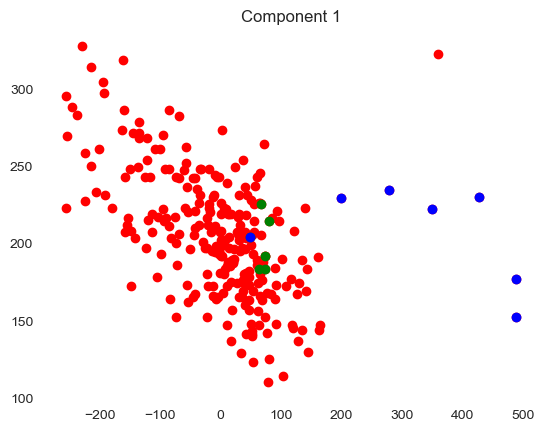

In [157]:
plt.scatter(x1,y1,color='red')
plt.scatter(x2,y2,color='green')
plt.scatter(x3,y3,color='blue')
plt.title('Component 1')
plt.show()

In [ ]:
#grafica residuals fins al gener vermell, residuals gener a juliol verds, residuals juliol desembre blau

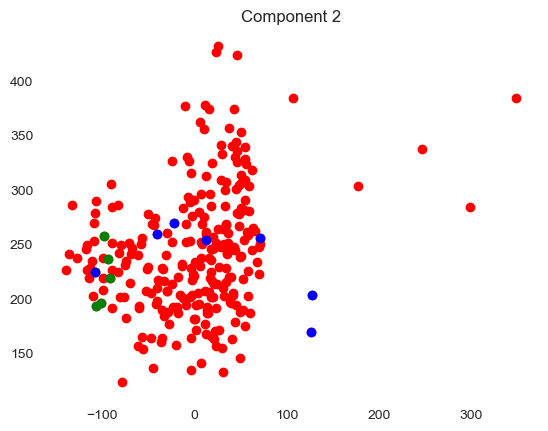

In [134]:
x1 = df.loc[:date['date_end_train'],:].PCA1
x2 = df.loc['2022-01':'2022-06',:].PCA1
x3 = df.loc['2022-06':'2022-12',:].PCA1

y1 = f.loc[:date['date_end_train'],:]
y2 = f.loc['2022-01':'2022-06',:]
y3 = f.loc['2022-06':'2022-12',:]

plt.scatter(x1,y1,color='red')
plt.scatter(x2,y2,color='green')
plt.scatter(x3,y3,color='blue')
plt.title('Component 2')
plt.show()

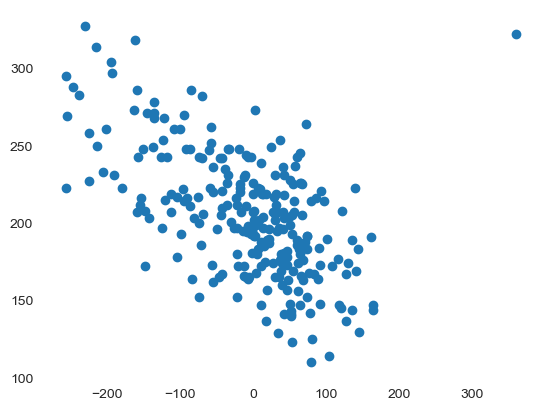

In [135]:
plt.scatter(df.iloc[:,0], new_df_mesos.Agressions)

In [159]:
pipe_modelado.steps[1]

('pca', PCA(n_components=2))

In [252]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[new_df_mesos.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

model = RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0) 
model.fit(X_train, y_train) 

rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = sqr_err(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07-01         259  229.909899  234.833333  10.695852  15.353772   
2022-08-01         269  231.771460  234.833333  10.695852  15.353772   
2022-09-01         254  229.212473  234.833333  10.695852  15.353772   
2022-10-01         255  214.805632  234.833333  10.695852  15.353772   
2022-11-01         203  180.205333  234.833333  10.695852  15.353772   
2022-12-01         169  172.977485  234.833333  10.695852  15.353772   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07-01  11.393667   15.860914  26.345448  32.555556     16.666667   
2022-08-01  11.393667   15.860914  26.345448  32.555556     16.666667   
2022-09-01  11.393667   15.860914  26.345448  32.555556     16.666667   
2022-10-01  11.393667   15.860914  26.345448  32.555556     16.666667   
2022-11-01  11.393667   15.860914  26.345448  32.555556     16.666667   
2022-12-01  11.393667   15.860914  26.345448  32.555556     16.666667   

            Metrica nomb mean       RMSE  RMSE mean          MSE  
month_year                                                        
2022-07-01          33.333333  28.860654  36.223458   846.233949  
2022-08-01          33.333333  28.860654  36.223458  1385.964167  
2022-09-01          33.333333  28.860654  36.223458   614.421501  
2022-10-01          33.333333  28.860654  36.223458  1615.587223  
2022-11-01          33.333333  28.860654  36.223458   519.596844  
2022-12-01          33.333333  28.860654  36.223458    15.820383

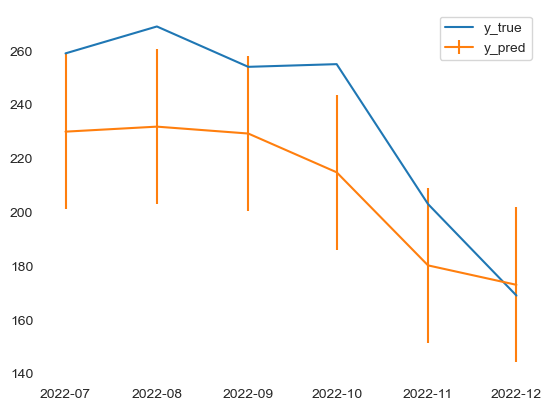

In [253]:
mse = mean_squared_error(test['Agressions'], test['Pred'])
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(test.index, test['Agressions'])
plt.errorbar(test.index, test['Pred'],np.sqrt(mse))
plt.legend(['y_true','y_pred'])
plt.show()

(-42.402960685726235, 42.402960685726235)

<Figure size 640x480 with 0 Axes>

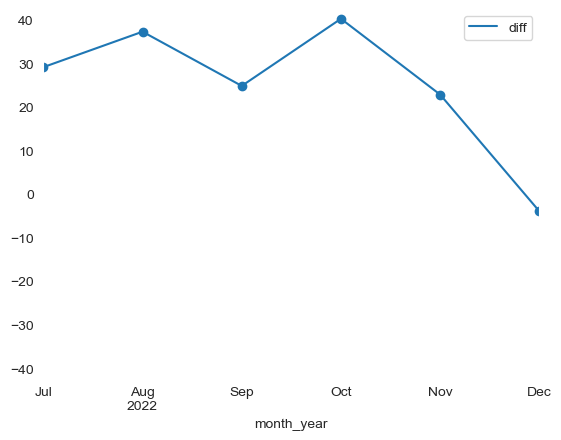

In [278]:
fig = plt.figure()
ax = test.plot(y=['diff'])
plt.scatter(x=test.index, y= test['diff'])
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

In [261]:
plt.rcParams['axes.facecolor'] = 'white'
test['diff'] = test['Agressions'] - test['Pred']

ax = plt.scatter(x=test.index, y= test['diff'])

ax.plot(x=0)



yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_11472/4064027602.py, line 4)

<AxesSubplot:xlabel='month_year'>

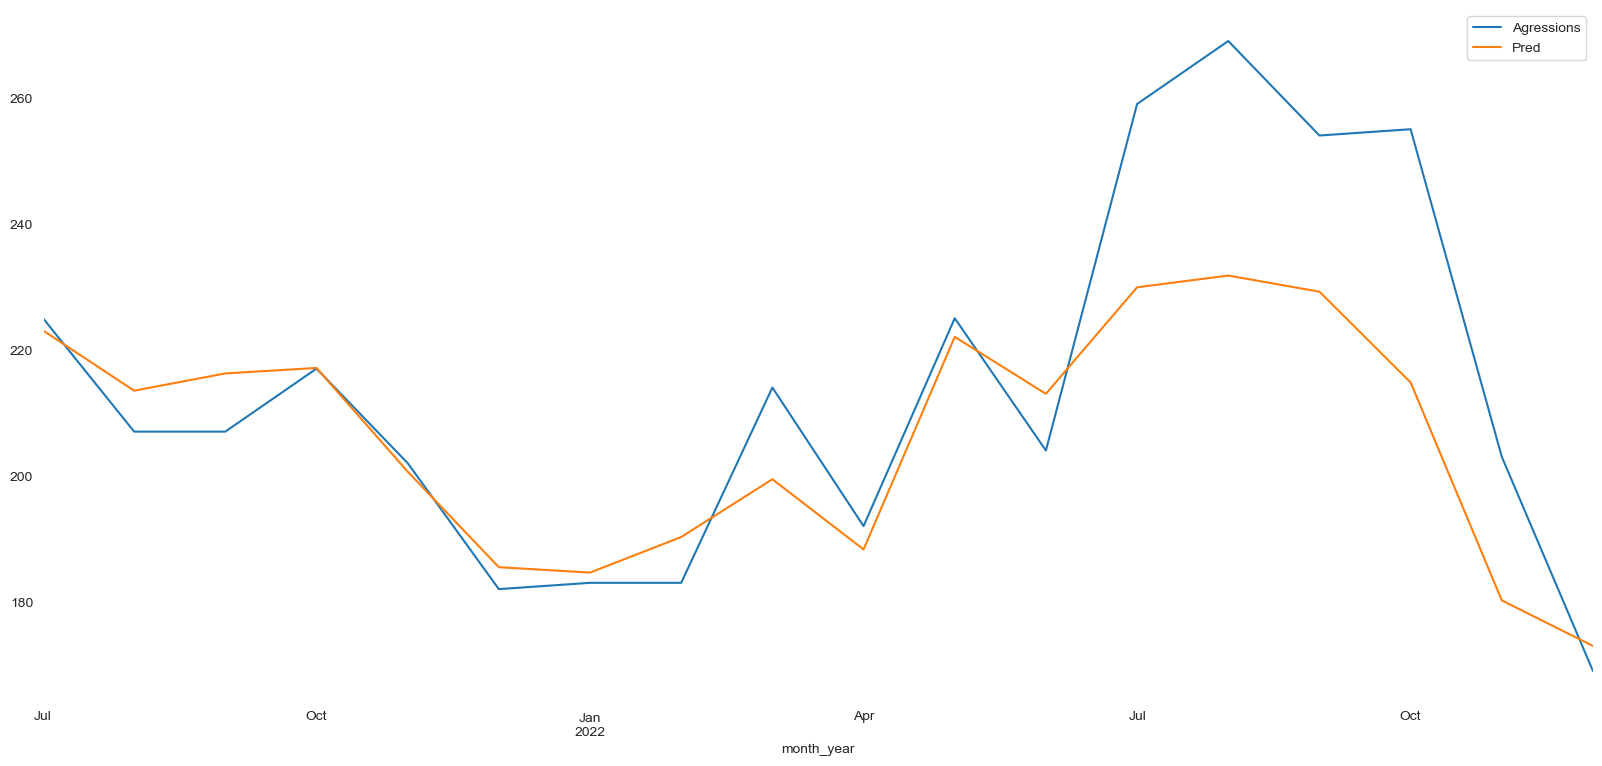

In [256]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-13]
d = d.set_index('month_year')
d = d[-18:]

# d = d.reset_index()
fig, ax = plt.subplots(figsize=(20, 9))
ax.set_facecolor('xkcd:white')
d.plot(ax=ax)
# ax.vlines(x='2022-07', ymin=0, ymax=300, color='k', ls='--')

In [167]:
X = nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = xg_pred_test_y


test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07-01         259  219.524261  234.833333  13.373203  15.353772   
2022-08-01         269  229.841217  234.833333  13.373203  15.353772   
2022-09-01         254  217.113541  234.833333  13.373203  15.353772   
2022-10-01         255  204.618256  234.833333  13.373203  15.353772   
2022-11-01         203  178.278534  234.833333  13.373203  15.353772   
2022-12-01         169  162.269379  234.833333  13.373203  15.353772   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07-01  14.468769   16.192561  32.892469  32.555556           0.0   
2022-08-01  14.468769   16.192561  32.892469  32.555556           0.0   
2022-09-01  14.468769   16.192561  32.892469  32.555556           0.0   
2022-10-01  14.468769   16.192561  32.892469  32.555556           0.0   
2022-11-01  14.468769   16.192561  32.892469  32.555556           0.0   
2022-12-01  14.468769   16.192561  32.892469  32.555556           0.0   

            Metrica nomb mean       RMSE  RMSE mean  
month_year                                           
2022-07-01          33.333333  35.700437  36.223458  
2022-08-01          33.333333  35.700437  36.223458  
2022-09-01          33.333333  35.700437  36.223458  
2022-10-01          33.333333  35.700437  36.223458  
2022-11-01          33.333333  35.700437  36.223458  
2022-12-01          33.333333  35.700437  36.223458

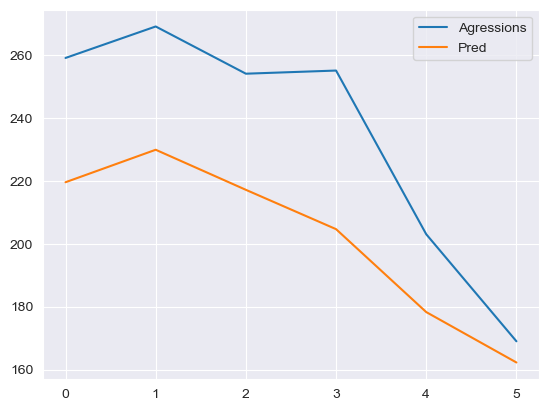

In [168]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [51]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

In [347]:
X = nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_split=4, random_state=0)
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 20, subsample = 0.8999999999999999, colsample_bytree = 0.7, colsample_bylevel = 0.8999999999999999, random_state=0) 
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.8 + rf_pred_train * 0.2
total_pred_test = xg_pred_test * 0.8 + rf_pred_test * 0.2


test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = total_pred_test


test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model      MAPE  MAPE mean    SMAPE  \
month_year                                                                     
2022-07-01         229  222.664505  207.333333  3.627455   15.14335  3.64134   
2022-08-01         234  232.622963  207.333333  3.627455   15.14335  3.64134   
2022-09-01         222  212.477894  207.333333  3.627455   15.14335  3.64134   
2022-10-01         230  217.118099  207.333333  3.627455   15.14335  3.64134   
2022-11-01         177  181.125845  207.333333  3.627455   15.14335  3.64134   
2022-12-01         152  161.406690  207.333333  3.627455   15.14335  3.64134   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-07-01   15.027519  7.274846  28.555556     33.333333          33.333333   
2022-08-01   15.027519  7.274846  28.555556     33.333333          33.333333   
2022-09-01   15.027519  7.274846  28.555556     33.333333          33.333333   
2022-10-01   15.027519  7.274846  28.555556     33.333333          33.333333   
2022-11-01   15.027519  7.274846  28.555556     33.333333          33.333333   
2022-12-01   15.027519  7.274846  28.555556     33.333333          33.333333   

                RMSE  RMSE mean        MSE  
month_year                                  
2022-07-01  8.207284  31.335106  67.359505  
2022-08-01  8.207284  31.335106  67.359505  
2022-09-01  8.207284  31.335106  67.359505  
2022-10-01  8.207284  31.335106  67.359505  
2022-11-01  8.207284  31.335106  67.359505  
2022-12-01  8.207284  31.335106  67.359505

In [53]:
train = y_train.to_frame()
train['Pred']  = total_pred_train
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

mesos_total['Average Model'] = d['Pred']

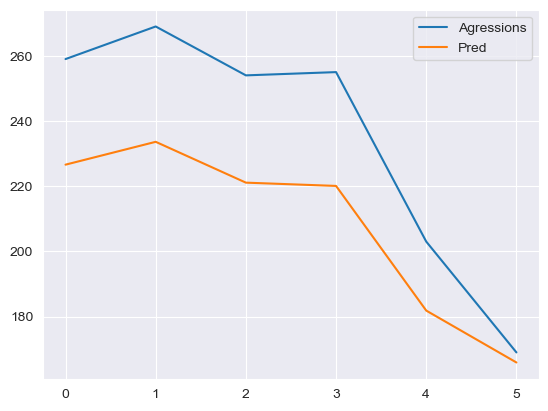

In [48]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [48]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])

In [286]:
X = nf.drop(columns = 'Agressions')
y = nf['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]
y = new_df_mesos['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# train['ds'] = train['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')


test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# test['ds'] = test['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')




# Prophet
model = Prophet(holidays = hol,
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'additive',
                yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test  = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f.index =f.index.to_timestamp('s').strftime('%Y-%m-%d')
f = f.reset_index().rename(columns={'month_year': 'ds'}).set_index('ds')
f.index = pd.to_datetime(f.index)
test['Agressions'] = f.iloc[-6:]
test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model      MAPE  MAPE mean     SMAPE  \
ds                                                                              
2022-07-01  234.120793         229  207.333333  7.043331   15.14335  7.381908   
2022-08-01  223.186295         234  207.333333  7.043331   15.14335  7.381908   
2022-09-01  211.367767         222  207.333333  7.043331   15.14335  7.381908   
2022-10-01  196.002575         230  207.333333  7.043331   15.14335  7.381908   
2022-11-01  156.223829         177  207.333333  7.043331   15.14335  7.381908   
2022-12-01  158.222667         152  207.333333  7.043331   15.14335  7.381908   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                              
2022-07-01   15.385318  14.593832  28.555556     33.333333          33.333333   
2022-08-01   15.385318  14.593832  28.555556     33.333333          33.333333   
2022-09-01   15.385318  14.593832  28.555556     33.333333          33.333333   
2022-10-01   15.385318  14.593832  28.555556     33.333333          33.333333   
2022-11-01   15.385318  14.593832  28.555556     33.333333          33.333333   
2022-12-01   15.385318  14.593832  28.555556     33.333333          33.333333   

                 RMSE  RMSE mean         MSE  
ds                                            
2022-07-01  17.712514  31.335106  313.733146  
2022-08-01  17.712514  31.335106  313.733146  
2022-09-01  17.712514  31.335106  313.733146  
2022-10-01  17.712514  31.335106  313.733146  
2022-11-01  17.712514  31.335106  313.733146  
2022-12-01  17.712514  31.335106  313.733146

In [50]:
p_pred_train_y=p_pred_train_y.set_index('ds')
train = y_train.to_frame()
train['Pred']  = p_pred_train_y['yhat']
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['ds','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('level_0').rename(columns={'level_0':'month_year'})
d = d[-24:]

mesos_total['Prophet'] = d['Pred']

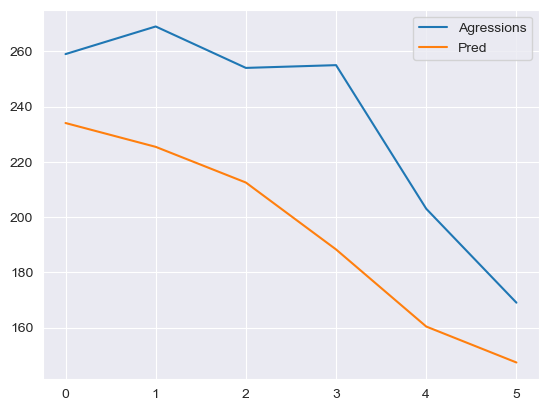

In [189]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

### Feature Selection

In [252]:
#Feature Selection
X = new_df_mesos.drop(columns = 'Agressions')
y = new_df_mesos['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

sel = SelectFromModel(RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0))
sel.fit(X_train, y_train)
selected_feat=X_train.columns[(sel.get_support())]
model= RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0)
model.fit(X_train[selected_feat], y_train)
rf_pred_train_y = model.predict(X_train[selected_feat]) 
rf_pred_test_y = model.predict(X_test[selected_feat])

selected_feat

Index(['agressions_2_month_avg', 'agressions_lag_1', 'trend',
       'cos(5,freq=A-DEC)'],
      dtype='object')

In [254]:
test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
test['Agressions']  = f.iloc[-6:]

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07            259  123.985529  234.833333  37.775358  15.353772   
2022-08            269  150.146642  234.833333  37.775358  15.353772   
2022-09            254  143.404358  234.833333  37.775358  15.353772   
2022-10            255  144.989097  234.833333  37.775358  15.353772   
2022-11            203  147.082352  234.833333  37.775358  15.353772   
2022-12            169  141.772679  234.833333  37.775358  15.353772   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07     47.892014    18.20106  92.936557  32.555556           0.0   
2022-08     47.892014    18.20106  92.936557  32.555556           0.0   
2022-09     47.892014    18.20106  92.936557  32.555556           0.0   
2022-10     47.892014    18.20106  92.936557  32.555556           0.0   
2022-11     47.892014    18.20106  92.936557  32.555556           0.0   
2022-12     47.892014    18.20106  92.936557  32.555556           0.0   

            Metrica nomb mean        RMSE  RMSE mean  
month_year                                            
2022-07             33.333333  100.463039  36.223458  
2022-08             33.333333  100.463039  36.223458  
2022-09             33.333333  100.463039  36.223458  
2022-10             33.333333  100.463039  36.223458  
2022-11             33.333333  100.463039  36.223458  
2022-12             33.333333  100.463039  36.223458

In [255]:
#Feature Selection

sel = SelectFromModel(xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0))
sel.fit(X_train, y_train)
selected_feat=X_train.columns[(sel.get_support())]
model= xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0)
model.fit(X_train[selected_feat], y_train)
rf_pred_train_y = model.predict(X_train[selected_feat]) 
rf_pred_test_y = model.predict(X_test[selected_feat])

selected_feat

Index(['New Years', 'agressions_2_month_avg', 'agressions_6_month_avg',
       'agressions_lag_2', 'month', 'hivern', 'year_2020', 'quarter_3',
       'quarter_4', 'trend', 'cos(1,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'cos(3,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'cos(5,freq=A-DEC)',
       'Foreign born', 'HS Grads', 'BA Grads'],
      dtype='object')

In [256]:
test = y_test.to_frame()
test['Pred']  = rf_pred_test_y
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
test['Agressions']  = f.iloc[-6:]

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions        Pred  Mean model       MAPE  MAPE mean  \
month_year                                                             
2022-07            259  185.027328  234.833333  24.795179  15.353772   
2022-08            269  183.440536  234.833333  24.795179  15.353772   
2022-09            254  179.110901  234.833333  24.795179  15.353772   
2022-10            255  173.661804  234.833333  24.795179  15.353772   
2022-11            203  164.145355  234.833333  24.795179  15.353772   
2022-12            169  155.678986  234.833333  24.795179  15.353772   

                SMAPE  SMAPE mean        MAE   MAE mean  Metrica nomb  \
month_year                                                              
2022-07     28.840586   17.023698  61.322515  32.555556           0.0   
2022-08     28.840586   17.023698  61.322515  32.555556           0.0   
2022-09     28.840586   17.023698  61.322515  32.555556           0.0   
2022-10     28.840586   17.023698  61.322515  32.555556           0.0   
2022-11     28.840586   17.023698  61.322515  32.555556           0.0   
2022-12     28.840586   17.023698  61.322515  32.555556           0.0   

            Metrica nomb mean       RMSE  RMSE mean  
month_year                                           
2022-07             33.333333  66.713055  36.223458  
2022-08             33.333333  66.713055  36.223458  
2022-09             33.333333  66.713055  36.223458  
2022-10             33.333333  66.713055  36.223458  
2022-11             33.333333  66.713055  36.223458  
2022-12             33.333333  66.713055  36.223458

### Hyperparameter Tuning

In [268]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)


model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = rf_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      min_samples_split=10, n_estimators=400, random_state=0)
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


Agressions        Pred  Mean model      MAPE  MAPE mean  SMAPE  \
month_year                                                                   
2022-07-01         229  223.331244  207.333333  6.762736   15.14335  6.556   
2022-08-01         234  229.640932  207.333333  6.762736   15.14335  6.556   
2022-09-01         222  216.970457  207.333333  6.762736   15.14335  6.556   
2022-10-01         230  210.714877  207.333333  6.762736   15.14335  6.556   
2022-11-01         177  192.290504  207.333333  6.762736   15.14335  6.556   
2022-12-01         152  177.762526  207.333333  6.762736   15.14335  6.556   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-07-01   14.673196  12.56592  28.555556     33.333333          33.333333   
2022-08-01   14.673196  12.56592  28.555556     33.333333          33.333333   
2022-09-01   14.673196  12.56592  28.555556     33.333333          33.333333   
2022-10-01   14.673196  12.56592  28.555556     33.333333          33.333333   
2022-11-01   14.673196  12.56592  28.555556     33.333333          33.333333   
2022-12-01   14.673196  12.56592  28.555556     33.333333          33.333333   

                 RMSE  RMSE mean  
month_year                        
2022-07-01  14.976959  31.335106  
2022-08-01  14.976959  31.335106  
2022-09-01  14.976959  31.335106  
2022-10-01  14.976959  31.335106  
2022-11-01  14.976959  31.335106  
2022-12-01  14.976959  31.335106

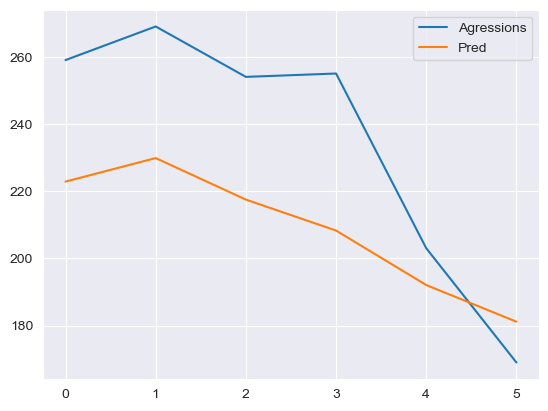

In [33]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [282]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

In [46]:
#RandomForestRegressor(n_estimators=1200, max_depth = 50, max_features = 'auto', bootstrap = True, min_samples_leaf=2, min_samples_split=2, random_state=0))
model = RandomForestRegressor(n_estimators=400, max_depth = 60, max_features = 'sqrt', bootstrap = False, min_samples_split=10, random_state=0)
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = rf_pred_test_y

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model    MAPE  MAPE mean     SMAPE  \
month_year                                                                    
2022-07-01         229  222.829491  207.333333  7.2721   15.14335  7.025273   
2022-08-01         234  229.839225  207.333333  7.2721   15.14335  7.025273   
2022-09-01         222  217.476483  207.333333  7.2721   15.14335  7.025273   
2022-10-01         230  208.266272  207.333333  7.2721   15.14335  7.025273   
2022-11-01         177  192.054158  207.333333  7.2721   15.14335  7.025273   
2022-12-01         152  181.134909  207.333333  7.2721   15.14335  7.025273   

            SMAPE mean        MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                      
2022-07-01   14.627577  13.462933  28.555556     33.333333          33.333333   
2022-08-01   14.627577  13.462933  28.555556     33.333333          33.333333   
2022-09-01   14.627577  13.462933  28.555556     33.333333          33.333333   
2022-10-01   14.627577  13.462933  28.555556     33.333333          33.333333   
2022-11-01   14.627577  13.462933  28.555556     33.333333          33.333333   
2022-12-01   14.627577  13.462933  28.555556     33.333333          33.333333   

                 RMSE  RMSE mean         MSE  
month_year                                    
2022-07-01  16.450304  31.335106  270.612491  
2022-08-01  16.450304  31.335106  270.612491  
2022-09-01  16.450304  31.335106  270.612491  
2022-10-01  16.450304  31.335106  270.612491  
2022-11-01  16.450304  31.335106  270.612491  
2022-12-01  16.450304  31.335106  270.612491

In [47]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

mesos_total['Random Forest'] = d['Pred']

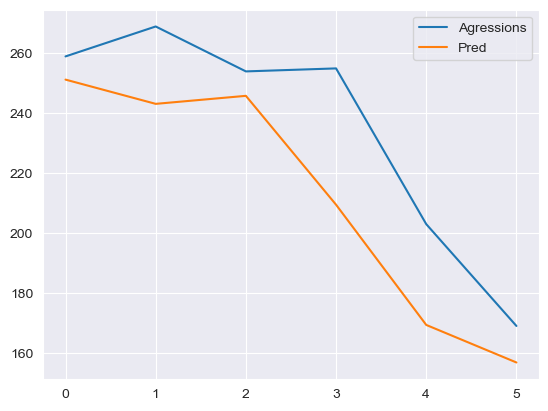

In [56]:
#split 2 gráfica + bonita
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

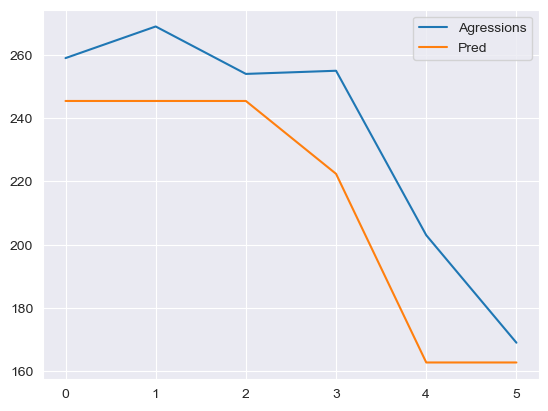

In [54]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [262]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
xg_pred_train = random_search.predict(X_train) 
xg_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = xg_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.7, enable_categorical=False, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)
{'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}


Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-07-01         229  221.054810  207.333333  3.776561   15.14335  3.822782   
2022-08-01         234  232.187332  207.333333  3.776561   15.14335  3.822782   
2022-09-01         222  208.328384  207.333333  3.776561   15.14335  3.822782   
2022-10-01         230  217.827332  207.333333  3.776561   15.14335  3.822782   
2022-11-01         177  181.615448  207.333333  3.776561   15.14335  3.822782   
2022-12-01         152  158.622269  207.333333  3.776561   15.14335  3.822782   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-07-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-08-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-09-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-10-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-11-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-12-01   15.092092  7.806643  28.555556     33.333333          33.333333   

                RMSE  RMSE mean        MSE  
month_year                                  
2022-07-01  8.819066  31.335106  77.775925  
2022-08-01  8.819066  31.335106  77.775925  
2022-09-01  8.819066  31.335106  77.775925  
2022-10-01  8.819066  31.335106  77.775925  
2022-11-01  8.819066  31.335106  77.775925  
2022-12-01  8.819066  31.335106  77.775925

In [43]:
nf = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
nf = nf.loc[nf.index.year >=2018]

In [44]:
X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 20, subsample = 0.8999999999999999, colsample_bytree = 0.7, colsample_bylevel = 0.8999999999999999, random_state=0) 
model.fit(X_train, y_train)
xg_pred_train = model.predict(X_train) 
xg_pred_test = model.predict(X_test)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = xg_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model      MAPE  MAPE mean    SMAPE  \
month_year                                                                     
2022-07-01         229  220.007278  207.333333  4.017641   15.14335  4.07101   
2022-08-01         234  231.302811  207.333333  4.017641   15.14335  4.07101   
2022-09-01         222  207.880341  207.333333  4.017641   15.14335  4.07101   
2022-10-01         230  217.223877  207.333333  4.017641   15.14335  4.07101   
2022-11-01         177  181.618652  207.333333  4.017641   15.14335  4.07101   
2022-12-01         152  158.842728  207.333333  4.017641   15.14335  4.07101   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-07-01   15.098684  8.341179  28.555556     33.333333          33.333333   
2022-08-01   15.098684  8.341179  28.555556     33.333333          33.333333   
2022-09-01   15.098684  8.341179  28.555556     33.333333          33.333333   
2022-10-01   15.098684  8.341179  28.555556     33.333333          33.333333   
2022-11-01   15.098684  8.341179  28.555556     33.333333          33.333333   
2022-12-01   15.098684  8.341179  28.555556     33.333333          33.333333   

                RMSE  RMSE mean        MSE  
month_year                                  
2022-07-01  9.299577  31.335106  86.482141  
2022-08-01  9.299577  31.335106  86.482141  
2022-09-01  9.299577  31.335106  86.482141  
2022-10-01  9.299577  31.335106  86.482141  
2022-11-01  9.299577  31.335106  86.482141  
2022-12-01  9.299577  31.335106  86.482141

In [266]:
X= nf.drop(columns = 'Agressions')
y = nf['Agressions']

X_train, X_test, y_train, y_test  = split_func(y, X, y, '2022-06', 6)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 20, subsample = 0.8999999999999999, colsample_bytree = 0.7, colsample_bylevel = 0.8999999999999999, random_state=0) 
model.fit(X_train, y_train)
xg_pred_train = model.predict(X_train) 
xg_pred_test = model.predict(X_test)

test = y_test.to_frame()
f = df_prova.groupby([df['month_year']]).size().to_frame()
f = f.iloc[:-2]
f = f.rename(columns = {0:'Agressions'})
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions']  = f.iloc[-6:]
test['Pred']  = xg_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions        Pred  Mean model      MAPE  MAPE mean     SMAPE  \
month_year                                                                      
2022-07-01         229  221.054810  207.333333  3.776561   15.14335  3.822782   
2022-08-01         234  232.187332  207.333333  3.776561   15.14335  3.822782   
2022-09-01         222  208.328384  207.333333  3.776561   15.14335  3.822782   
2022-10-01         230  217.827332  207.333333  3.776561   15.14335  3.822782   
2022-11-01         177  181.615448  207.333333  3.776561   15.14335  3.822782   
2022-12-01         152  158.622269  207.333333  3.776561   15.14335  3.822782   

            SMAPE mean       MAE   MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                     
2022-07-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-08-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-09-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-10-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-11-01   15.092092  7.806643  28.555556     33.333333          33.333333   
2022-12-01   15.092092  7.806643  28.555556     33.333333          33.333333   

                RMSE  RMSE mean        MSE  
month_year                                  
2022-07-01  8.819066  31.335106  77.775925  
2022-08-01  8.819066  31.335106  77.775925  
2022-09-01  8.819066  31.335106  77.775925  
2022-10-01  8.819066  31.335106  77.775925  
2022-11-01  8.819066  31.335106  77.775925  
2022-12-01  8.819066  31.335106  77.775925

In [45]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

mesos_total = pd.DataFrame()
mesos_total = d[['Agressions', 'Pred']]
mesos_total = mesos_total.rename(columns={'Pred':'XGBoost'})

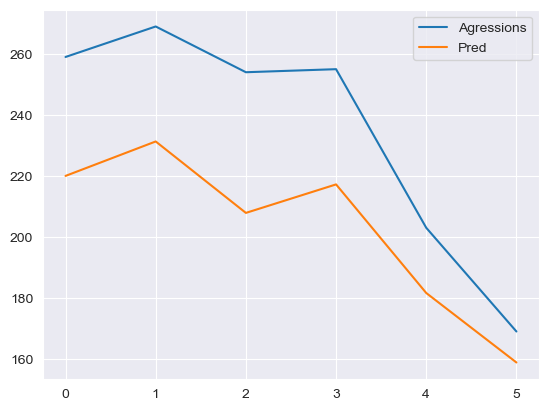

In [62]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

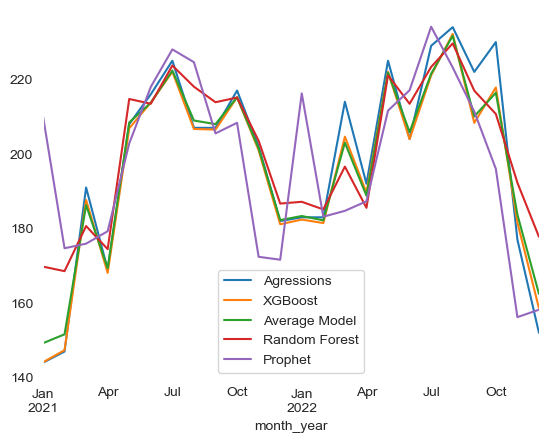

In [288]:
mesos_total.plot()
plt.show()

(-70.0, 70.0)

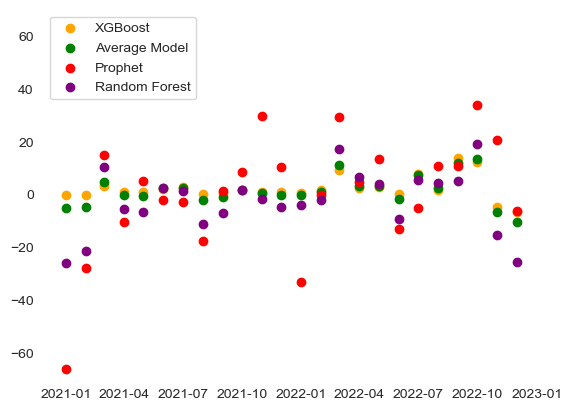

In [289]:
mesos_total['res_XGBoost'] = mesos_total['Agressions'] - mesos_total['XGBoost']
mesos_total['res_Avg_Model'] = mesos_total['Agressions'] - mesos_total['Average Model']
mesos_total['res_Prophet'] = mesos_total['Agressions'] - mesos_total['Prophet']
mesos_total['res_RF'] = mesos_total['Agressions'] - mesos_total['Random Forest']

fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
ax1.scatter(x=mesos_total.index, y= mesos_total['res_XGBoost'], label='XGBoost', color='orange')
ax1.scatter(x=mesos_total.index, y= mesos_total['res_Avg_Model'], label='Average Model', color='green')
ax1.scatter(x=mesos_total.index, y= mesos_total['res_Prophet'], label='Prophet', color='red')
ax1.scatter(x=mesos_total.index, y= mesos_total['res_RF'], label='Random Forest', color='purple')

plt.legend(loc='upper left')
plt.ylim(-70,70)

In [57]:
mesos_total.to_csv('mesos_total.csv')

## 6 mesos per comunitat

### Forecasting agressions

In [28]:
def split_func_com (data, X, y, end_date, test_size):
    
    # Splitting train and test
    idx_train, idx_test = train_test_split(data.index, test_size=test_size, shuffle=False)
    X_train, y_train = X.loc[idx_train.unique(), :], X.loc[idx_test.unique(), :]
    X_test, y_test = y.loc[idx_train.unique()], y.loc[idx_test.unique()]
    
    return X_train, y_train, X_test, y_test

In [29]:
warnings.filterwarnings("ignore")

In [30]:
Communities = [6,35, 63] #Communities = [6, 23,35, 63, 67]

In [31]:
plt.rcParams['axes.facecolor'] = 'white'

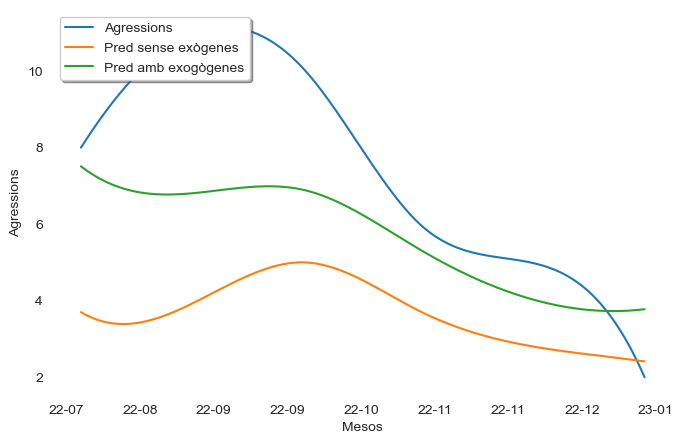

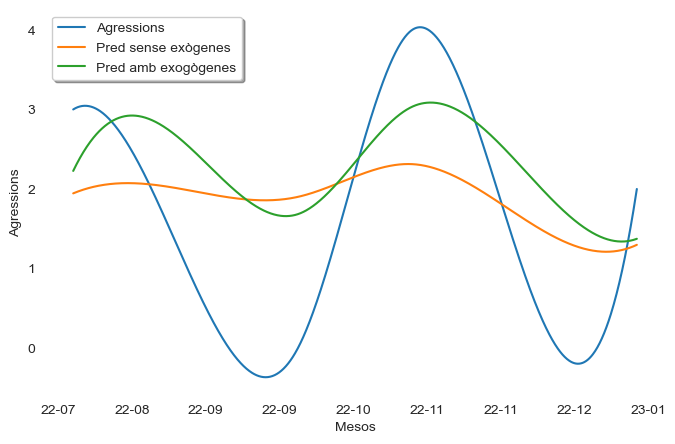

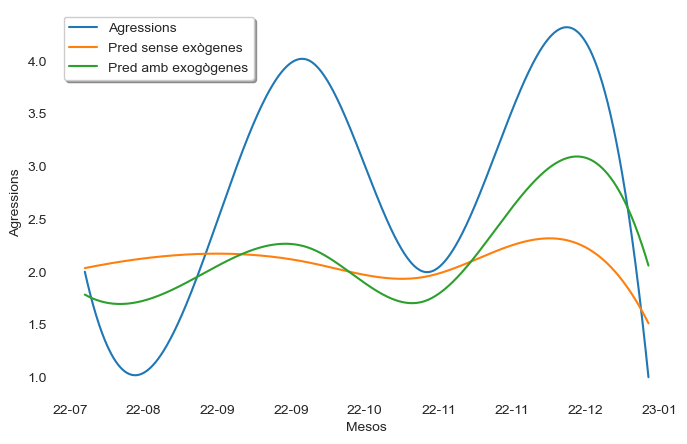

In [32]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4', 'trend','Poverty', 'Foreign born', 'HS Grads', 'BA Grads'])
nnnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

for i in Communities:

    X= nnnf.loc[nnnf['Community Area'] == i].drop(columns = 'Agressions')
    y = nnnf.loc[nnnf['Community Area'] == i].Agressions
    X2= nnnnf.loc[nnnnf['Community Area'] == i].drop(columns = 'Agressions')
    y2 = nnnnf.loc[nnnnf['Community Area'] == i].Agressions

    X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 6)
    X_train2, X_test2, y_train2, y_test2  = split_func_com(y2, X2, y2, '2022-07', 6)
    model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0) 
    model2 = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0)
    model.fit(X_train, y_train) 
    model2.fit(X_train2, y_train2) 
    rf_pred_train_y = model.predict(X_train) 
    rf_pred_test_y = model.predict(X_test)
    rf_pred_train_y2 = model2.predict(X_train2) 
    rf_pred_test_y2 = model2.predict(X_test2)

    f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
    f = f.iloc[:, :-24]
    f = f.rename(columns = {'ID':'Agressions'})
    f= f.reset_index().set_index('month_year')
    f = f[f['Community Area'] != 0]
    f = f.loc[f['Community Area']==i]
    f = f.iloc[:, 1:]
    f = f.loc[f.index.year != 2023]
    test = f.iloc[-6:]

    test['Pred'] = rf_pred_test_y
    test['Pred2'] = rf_pred_test_y2
    test['Mean model'] = test['Agressions'].mean()
    test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
    test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
    test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
    test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
    test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
    test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
    test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
    test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
    test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
    test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))

    min_date = mpl.dates.date2num(test.index.min())
    max_date = mpl.dates.date2num(test.index.max())
    x_new = np.linspace(min_date, max_date, 1000)

    a_BSpline = make_interp_spline(test.index.map(mpl.dates.date2num), test.Agressions)
    y_new = a_BSpline(x_new)

    a_BSpline2 = make_interp_spline(test.index.map(mpl.dates.date2num), test.Pred)
    y_new2 = a_BSpline2(x_new)
    
    a_BSpline3 = make_interp_spline(test.index.map(mpl.dates.date2num), test.Pred2)
    y_new3 = a_BSpline3(x_new)

    fig,ax = plt.subplots(figsize=(8,5))
#     ax.plot(test.index, test.Agressions)
    ax.plot(x_new, y_new)
    ax.plot(x_new, y_new2)
    ax.plot(x_new, y_new3)
    ax.set_xlabel('Mesos')
    ax.set_ylabel('Agressions')
    ax.legend(('Agressions', 'Pred sense exògenes', 'Pred amb exogògenes'), loc='upper left', shadow=True)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%y-%m'))

In [355]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4', 'trend']) #

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_split=4, random_state=0) 
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-07              2  4.660342    2.692641   inf        inf  84.369777   
2022-07              2  2.789632    2.692641   inf        inf  84.369777   
2022-07              6  4.601634    2.692641   inf        inf  84.369777   
2022-07              3  1.899751    2.692641   inf        inf  84.369777   
2022-07              1  0.840368    2.692641   inf        inf  84.369777   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  3.286430    2.692641   inf        inf  84.369777   
2022-12              0  0.238842    2.692641   inf        inf  84.369777   
2022-12              1  1.322234    2.692641   inf        inf  84.369777   
2022-12              3  0.843761    2.692641   inf        inf  84.369777   
2022-12              3  1.445722    2.692641   inf        inf  84.369777   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-07       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-07       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-07       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-07       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-07       91.00133  1.393787  2.162572     57.575758           60.17316   
...                ...       ...       ...           ...                ...   
2022-12       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-12       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-12       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-12       91.00133  1.393787  2.162572     57.575758           60.17316   
2022-12       91.00133  1.393787  2.162572     57.575758           60.17316   

               RMSE  RMSE mean  
month_year                      
2022-07     1.99811    3.03242  
2022-07     1.99811    3.03242  
2022-07     1.99811    3.03242  
2022-07     1.99811    3.03242  
2022-07     1.99811    3.03242  
...             ...        ...  
2022-12     1.99811    3.03242  
2022-12     1.99811    3.03242  
2022-12     1.99811    3.03242  
2022-12     1.99811    3.03242  
2022-12     1.99811    3.03242  

[462 rows x 13 columns]

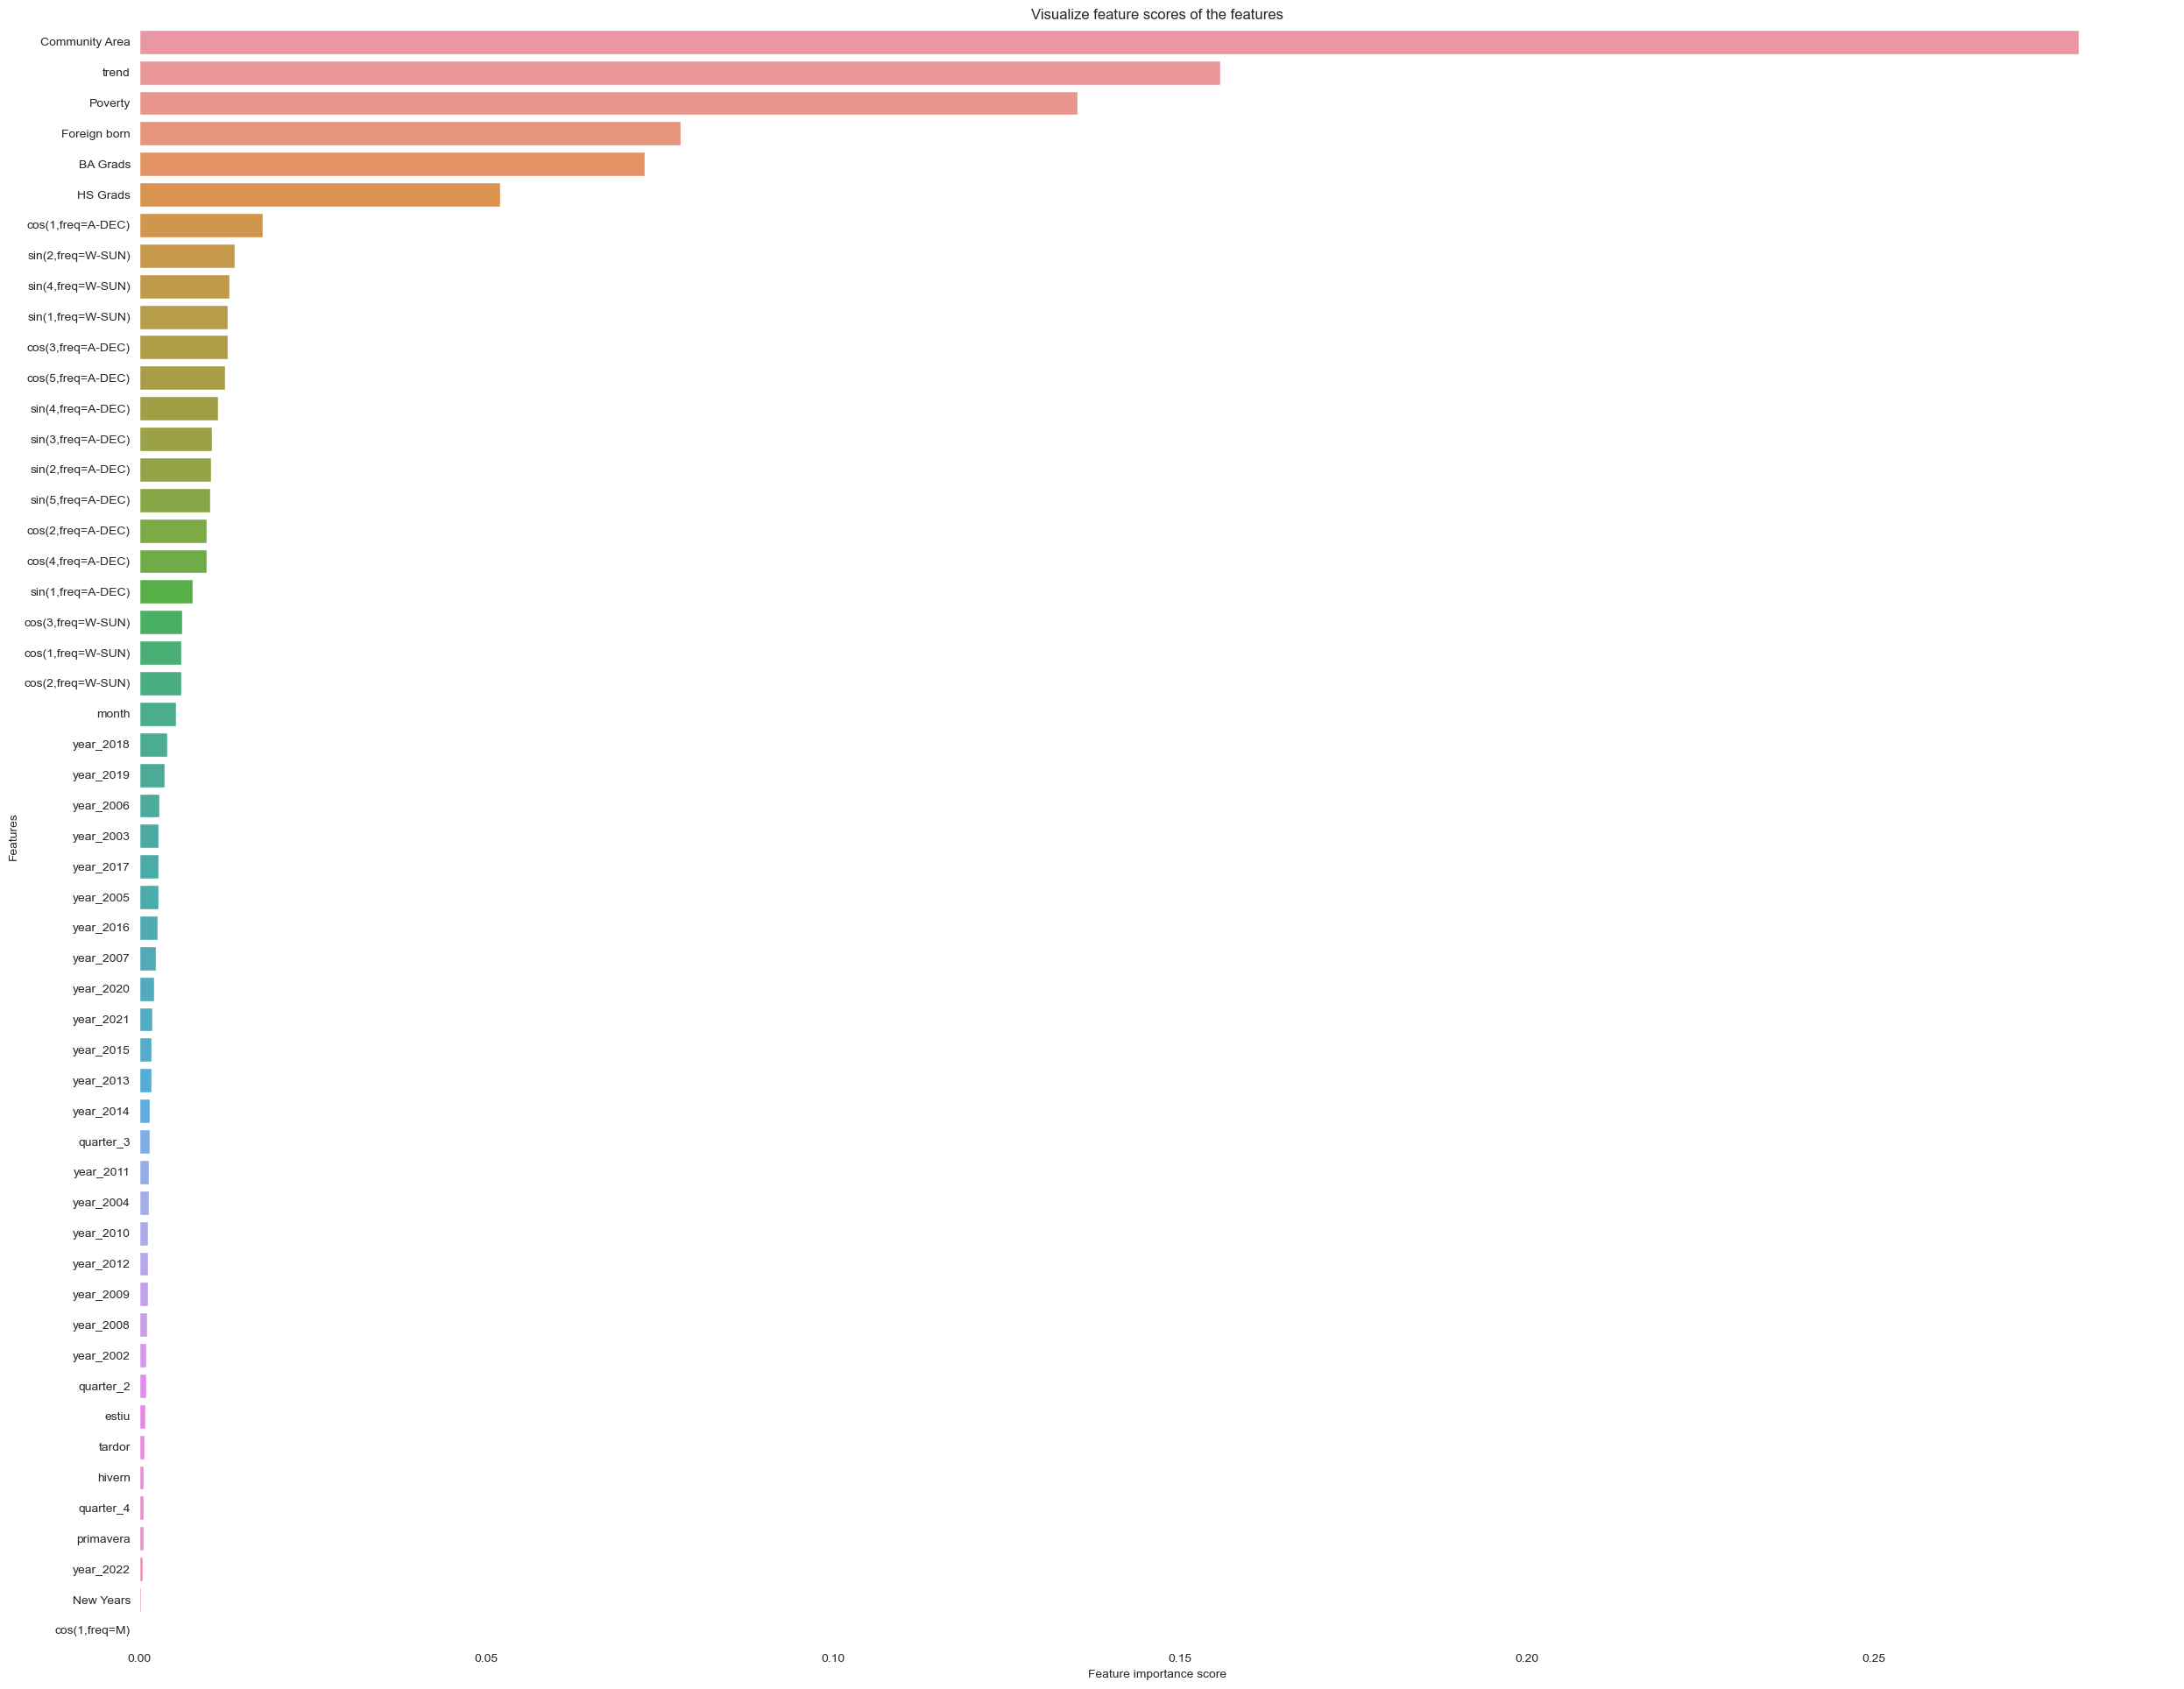

In [353]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

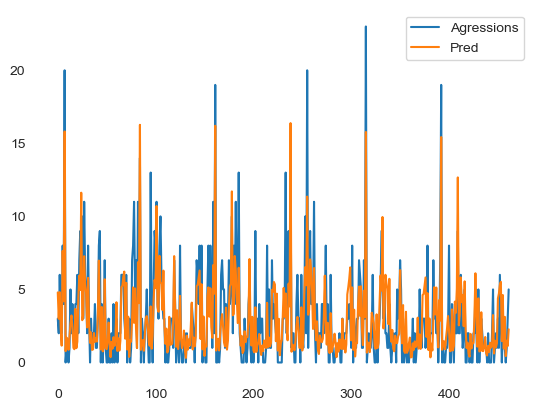

In [361]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [197]:
X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)
model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = xg_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

Agressions      Pred  Mean model  MAPE  MAPE mean     SMAPE  \
month_year                                                                
2022-07              3  3.249920    3.049784   inf        inf  82.00559   
2022-07              2  2.386956    3.049784   inf        inf  82.00559   
2022-07              6  3.175658    3.049784   inf        inf  82.00559   
2022-07              3  2.466685    3.049784   inf        inf  82.00559   
2022-07              2  2.155594    3.049784   inf        inf  82.00559   
...                ...       ...         ...   ...        ...       ...   
2022-12              1  2.833879    3.049784   inf        inf  82.00559   
2022-12              0  0.487751    3.049784   inf        inf  82.00559   
2022-12              1  1.074306    3.049784   inf        inf  82.00559   
2022-12              3  0.902941    3.049784   inf        inf  82.00559   
2022-12              5  1.206876    3.049784   inf        inf  82.00559   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-07      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-07      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-07      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-07      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-07      87.811488  1.758665   2.38888     50.649351          68.831169   
...                ...       ...       ...           ...                ...   
2022-12      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-12      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-12      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-12      87.811488  1.758665   2.38888     50.649351          68.831169   
2022-12      87.811488  1.758665   2.38888     50.649351          68.831169   

                RMSE  RMSE mean  
month_year                       
2022-07     2.571542   3.343228  
2022-07     2.571542   3.343228  
2022-07     2.571542   3.343228  
2022-07     2.571542   3.343228  
2022-07     2.571542   3.343228  
...              ...        ...  
2022-12     2.571542   3.343228  
2022-12     2.571542   3.343228  
2022-12     2.571542   3.343228  
2022-12     2.571542   3.343228  
2022-12     2.571542   3.343228  

[462 rows x 13 columns]

In [337]:
X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)

# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 50, min_samples_leaf=4, random_state=0) #, bootstrap = True, , min_samples_split=2
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(n_estimators=500, learning_rate = 0.1, max_depth= 3, subsample = 0.8999999999999999, colsample_bytree = 0.5, colsample_bylevel = 1, random_state=0) 
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.3 + rf_pred_train * 0.7
total_pred_test = xg_pred_test * 0.3 + rf_pred_test * 0.7


f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred']  = total_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-07              2  4.680895    2.692641   inf        inf  81.180079   
2022-07              2  3.196519    2.692641   inf        inf  81.180079   
2022-07              6  4.732970    2.692641   inf        inf  81.180079   
2022-07              3  2.360054    2.692641   inf        inf  81.180079   
2022-07              1  1.004194    2.692641   inf        inf  81.180079   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  2.555808    2.692641   inf        inf  81.180079   
2022-12              0  0.347681    2.692641   inf        inf  81.180079   
2022-12              1  1.338520    2.692641   inf        inf  81.180079   
2022-12              3  0.952432    2.692641   inf        inf  81.180079   
2022-12              3  2.389202    2.692641   inf        inf  81.180079   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-07       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-07       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-07       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-07       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-07       91.00133  1.367275  2.162572     61.255411           60.17316   
...                ...       ...       ...           ...                ...   
2022-12       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-12       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-12       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-12       91.00133  1.367275  2.162572     61.255411           60.17316   
2022-12       91.00133  1.367275  2.162572     61.255411           60.17316   

                RMSE  RMSE mean       MSE  
month_year                                 
2022-07     1.873898    3.03242  3.511492  
2022-07     1.873898    3.03242  3.511492  
2022-07     1.873898    3.03242  3.511492  
2022-07     1.873898    3.03242  3.511492  
2022-07     1.873898    3.03242  3.511492  
...              ...        ...       ...  
2022-12     1.873898    3.03242  3.511492  
2022-12     1.873898    3.03242  3.511492  
2022-12     1.873898    3.03242  3.511492  
2022-12     1.873898    3.03242  3.511492  
2022-12     1.873898    3.03242  3.511492  

[462 rows x 14 columns]

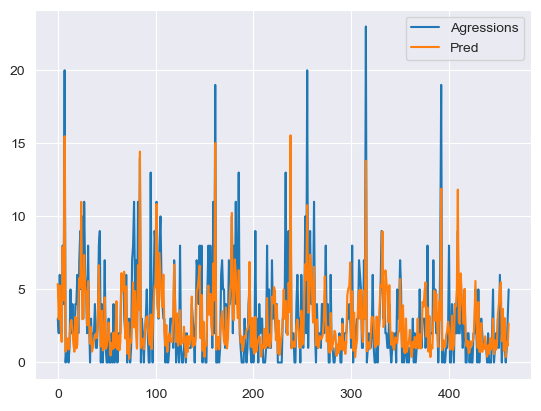

In [64]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [323]:
X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)

# RandomForestRegressor
model = RandomForestRegressor(n_estimators=1200, max_depth = 50, min_samples_leaf=4, random_state=0) #, bootstrap = True, , min_samples_split=2
model.fit(X_train, y_train) 
rf_pred_train = model.predict(X_train) 
rf_pred_test = model.predict(X_test)

# XGBRegressor
model2 = xg.XGBRegressor(n_estimators=500, learning_rate = 0.1, max_depth= 3, subsample = 0.8999999999999999, colsample_bytree = 0.5, colsample_bylevel = 1, random_state=0) 
model2.fit(X_train, y_train)
xg_pred_train = model2.predict(X_train) 
xg_pred_test = model2.predict(X_test)

# Average result
total_pred_train = xg_pred_train * 0.7 + rf_pred_train * 0.3
total_pred_test = xg_pred_test * 0.7 + rf_pred_test * 0.3


f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-924:]

test['Pred']  = total_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-01              4  4.815814    2.646104   inf        inf  77.747268   
2022-01              2  3.644282    2.646104   inf        inf  77.747268   
2022-01              6  5.056145    2.646104   inf        inf  77.747268   
2022-01              2  2.600716    2.646104   inf        inf  77.747268   
2022-01              1  1.133330    2.646104   inf        inf  77.747268   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  2.048530    2.646104   inf        inf  77.747268   
2022-12              0  0.403958    2.646104   inf        inf  77.747268   
2022-12              1  1.184000    2.646104   inf        inf  77.747268   
2022-12              3  0.996780    2.646104   inf        inf  77.747268   
2022-12              3  2.537340    2.646104   inf        inf  77.747268   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-01      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-01      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-01      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-01      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-01      89.371923  1.257843  2.097642     59.415584          60.822511   
...                ...       ...       ...           ...                ...   
2022-12      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-12      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-12      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-12      89.371923  1.257843  2.097642     59.415584          60.822511   
2022-12      89.371923  1.257843  2.097642     59.415584          60.822511   

                RMSE  RMSE mean      MSE  
month_year                                
2022-01     1.714949   2.909024  2.94105  
2022-01     1.714949   2.909024  2.94105  
2022-01     1.714949   2.909024  2.94105  
2022-01     1.714949   2.909024  2.94105  
2022-01     1.714949   2.909024  2.94105  
...              ...        ...      ...  
2022-12     1.714949   2.909024  2.94105  
2022-12     1.714949   2.909024  2.94105  
2022-12     1.714949   2.909024  2.94105  
2022-12     1.714949   2.909024  2.94105  
2022-12     1.714949   2.909024  2.94105  

[924 rows x 14 columns]

In [308]:
#Prophet
X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# train['ds'] = train['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')


test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# test['ds'] = test['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')




# Prophet
model = Prophet(holidays = hol,
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'additive',
                yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions'] = f.iloc[-462:]

test.loc[test['Pred'] < 0, 'Pred'] = 0


# test['Pred'] = p_pred_test_y['yhat']
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model  MAPE  MAPE mean      SMAPE  \
ds                                                                         
2022-07-01  3.011667           2    2.692641   inf        inf  90.396429   
2022-07-01  2.688551           2    2.692641   inf        inf  90.396429   
2022-07-01  2.694426           6    2.692641   inf        inf  90.396429   
2022-07-01  2.700301           3    2.692641   inf        inf  90.396429   
2022-07-01  2.706175           1    2.692641   inf        inf  90.396429   
...              ...         ...         ...   ...        ...        ...   
2022-12-01  2.022748           1    2.692641   inf        inf  90.396429   
2022-12-01  2.028623           0    2.692641   inf        inf  90.396429   
2022-12-01  2.034498           1    2.692641   inf        inf  90.396429   
2022-12-01  1.993374           3    2.692641   inf        inf  90.396429   
2022-12-01  1.705507           3    2.692641   inf        inf  90.396429   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                            
2022-07-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-07-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-07-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-07-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-07-01   99.052408  2.098514  2.162572     57.142857           60.17316   
...                ...       ...       ...           ...                ...   
2022-12-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-12-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-12-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-12-01   99.052408  2.098514  2.162572     57.142857           60.17316   
2022-12-01   99.052408  2.098514  2.162572     57.142857           60.17316   

                RMSE  RMSE mean       MSE  
ds                                         
2022-07-01  3.052837    3.03242  9.319815  
2022-07-01  3.052837    3.03242  9.319815  
2022-07-01  3.052837    3.03242  9.319815  
2022-07-01  3.052837    3.03242  9.319815  
2022-07-01  3.052837    3.03242  9.319815  
...              ...        ...       ...  
2022-12-01  3.052837    3.03242  9.319815  
2022-12-01  3.052837    3.03242  9.319815  
2022-12-01  3.052837    3.03242  9.319815  
2022-12-01  3.052837    3.03242  9.319815  
2022-12-01  3.052837    3.03242  9.319815  

[462 rows x 14 columns]

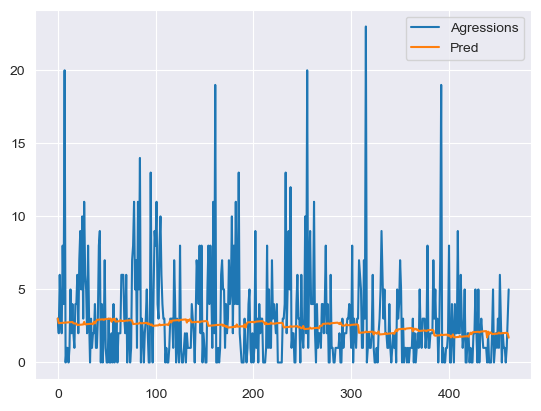

In [172]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [319]:
#Prophet
X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

cols = X.columns[~X.columns.str.match(r'year_|trend')]
X = X.loc[:,cols]

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)

train = pd.concat([X_train, y_train.to_frame()], axis=1)
train = train.reset_index()
train = train.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# train['ds'] = train['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')


test = pd.concat([X_test, y_test.to_frame()], axis=1)
test = test.reset_index()
test = test.rename(columns={'month_year': 'ds', 'Agressions': 'y'})
# test['ds'] = test['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m')




# Prophet
model = Prophet(holidays = hol,
                changepoint_prior_scale = 0.05,
                holidays_prior_scale = 0.01,
                seasonality_prior_scale = 0.01,
                seasonality_mode = 'additive',
                yearly_seasonality = False,
                  weekly_seasonality = True,
                  daily_seasonality = False)

for j in range(0, 20):
    model.add_regressor(X.columns.values[j])


model.fit(train)
p_pred_train_y = model.predict(train) 
p_pred_test_y = model.predict(test)

test = p_pred_test_y[['ds', 'yhat']].set_index('ds').rename(columns = {'yhat':'Pred'})

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
f.index = f.index.astype('string')
f.index = pd.to_datetime(f.index)
test['Agressions'] = f.iloc[-924:]

test.loc[test['Pred'] < 0, 'Pred'] = 0


# test['Pred'] = p_pred_test_y['yhat']
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Pred  Agressions  Mean model  MAPE  MAPE mean      SMAPE  \
ds                                                                         
2022-01-01  3.035134           4    2.646104   inf        inf  89.436422   
2022-01-01  2.736408           2    2.646104   inf        inf  89.436422   
2022-01-01  2.741839           6    2.646104   inf        inf  89.436422   
2022-01-01  2.747271           2    2.646104   inf        inf  89.436422   
2022-01-01  2.752702           1    2.646104   inf        inf  89.436422   
...              ...         ...         ...   ...        ...        ...   
2022-12-01  1.966259           1    2.646104   inf        inf  89.436422   
2022-12-01  1.971690           0    2.646104   inf        inf  89.436422   
2022-12-01  1.977122           1    2.646104   inf        inf  89.436422   
2022-12-01  1.939102           3    2.646104   inf        inf  89.436422   
2022-12-01  1.672964           3    2.646104   inf        inf  89.436422   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
ds                                                                            
2022-01-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-01-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-01-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-01-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-01-01   97.827635  2.050955  2.097642     57.251082          60.822511   
...                ...       ...       ...           ...                ...   
2022-12-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-12-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-12-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-12-01   97.827635  2.050955  2.097642     57.251082          60.822511   
2022-12-01   97.827635  2.050955  2.097642     57.251082          60.822511   

                RMSE  RMSE mean       MSE  
ds                                         
2022-01-01  2.948642   2.909024  8.694487  
2022-01-01  2.948642   2.909024  8.694487  
2022-01-01  2.948642   2.909024  8.694487  
2022-01-01  2.948642   2.909024  8.694487  
2022-01-01  2.948642   2.909024  8.694487  
...              ...        ...       ...  
2022-12-01  2.948642   2.909024  8.694487  
2022-12-01  2.948642   2.909024  8.694487  
2022-12-01  2.948642   2.909024  8.694487  
2022-12-01  2.948642   2.909024  8.694487  
2022-12-01  2.948642   2.909024  8.694487  

[924 rows x 14 columns]

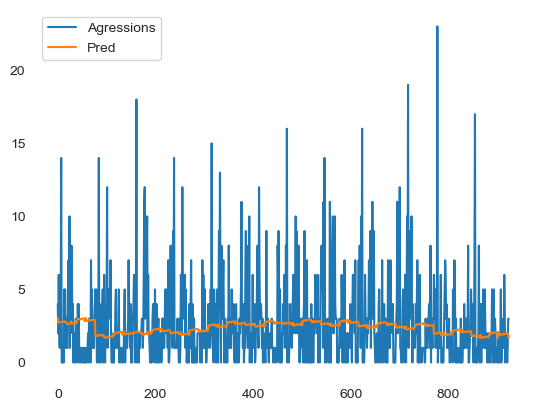

In [320]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

### HYPERPARAMETER TUNING

In [293]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)


model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = rf_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0)
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-07              2  4.416438    2.692641   inf        inf  82.792531   
2022-07              2  3.124190    2.692641   inf        inf  82.792531   
2022-07              6  4.694791    2.692641   inf        inf  82.792531   
2022-07              3  2.036056    2.692641   inf        inf  82.792531   
2022-07              1  0.720366    2.692641   inf        inf  82.792531   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  2.845024    2.692641   inf        inf  82.792531   
2022-12              0  0.428721    2.692641   inf        inf  82.792531   
2022-12              1  1.502647    2.692641   inf        inf  82.792531   
2022-12              3  1.026978    2.692641   inf        inf  82.792531   
2022-12              3  2.264652    2.692641   inf        inf  82.792531   

            SMAPE mean      MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                   
2022-07     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-07     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-07     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-07     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-07     216.331767  1.36254  2.162572     58.225108           60.17316   
...                ...      ...       ...           ...                ...   
2022-12     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-12     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-12     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-12     216.331767  1.36254  2.162572     58.225108           60.17316   
2022-12     216.331767  1.36254  2.162572     58.225108           60.17316   

                RMSE  RMSE mean  
month_year                       
2022-07     1.886271    3.03242  
2022-07     1.886271    3.03242  
2022-07     1.886271    3.03242  
2022-07     1.886271    3.03242  
2022-07     1.886271    3.03242  
...              ...        ...  
2022-12     1.886271    3.03242  
2022-12     1.886271    3.03242  
2022-12     1.886271    3.03242  
2022-12     1.886271    3.03242  
2022-12     1.886271    3.03242  

[462 rows x 13 columns]

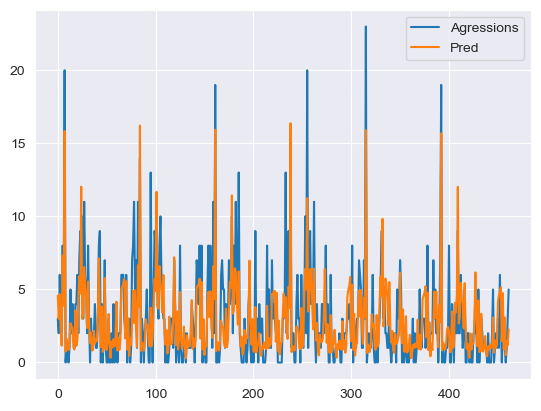

In [70]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [365]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0) #, bootstrap = True, , min_samples_split=2
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])


test

KeyboardInterrupt: 

In [ ]:
train = y_train.to_frame()
train['Pred']  = rf_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

mesos_comunitat['Random Forest'] = d['Pred']

In [ ]:
mesos_comunitat

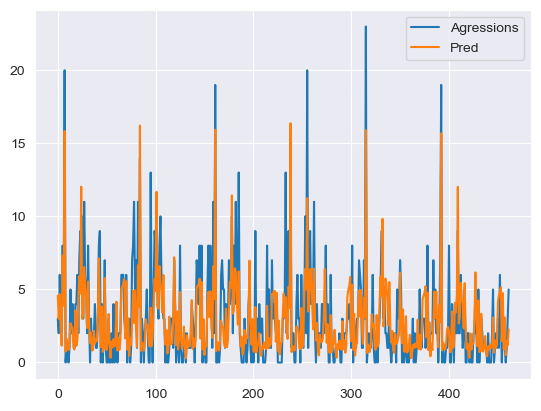

In [160]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [311]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)


model = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
rf_pred_train = random_search.predict(X_train) 
rf_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-924:]

test['Pred'] = rf_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

RandomForestRegressor(max_depth=100, min_samples_leaf=4, n_estimators=1200,
                      random_state=0)
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-01              4  4.773257    2.646104   inf        inf  80.103035   
2022-01              2  3.668591    2.646104   inf        inf  80.103035   
2022-01              6  5.350962    2.646104   inf        inf  80.103035   
2022-01              2  2.147564    2.646104   inf        inf  80.103035   
2022-01              1  1.007876    2.646104   inf        inf  80.103035   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  2.448949    2.646104   inf        inf  80.103035   
2022-12              0  0.532573    2.646104   inf        inf  80.103035   
2022-12              1  1.376861    2.646104   inf        inf  80.103035   
2022-12              3  0.901111    2.646104   inf        inf  80.103035   
2022-12              3  2.142084    2.646104   inf        inf  80.103035   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-01     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-01     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-01     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-01     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-01     237.136242  1.260167  2.097642      55.30303          60.822511   
...                ...       ...       ...           ...                ...   
2022-12     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-12     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-12     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-12     237.136242  1.260167  2.097642      55.30303          60.822511   
2022-12     237.136242  1.260167  2.097642      55.30303          60.822511   

                RMSE  RMSE mean  
month_year                       
2022-01     1.753754   2.909024  
2022-01     1.753754   2.909024  
2022-01     1.753754   2.909024  
2022-01     1.753754   2.909024  
2022-01     1.753754   2.909024  
...              ...        ...  
2022-12     1.753754   2.909024  
2022-12     1.753754   2.909024  
2022-12     1.753754   2.909024  
2022-12     1.753754   2.909024  
2022-12     1.753754   2.909024  

[924 rows x 13 columns]

In [310]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)
model = RandomForestRegressor(n_estimators=1200, max_depth = 100, min_samples_leaf=4, random_state=0) #, bootstrap = True, , min_samples_split=2
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-924:]

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])


test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-01              4  4.773257    2.646104   inf        inf  80.103035   
2022-01              2  3.668591    2.646104   inf        inf  80.103035   
2022-01              6  5.350962    2.646104   inf        inf  80.103035   
2022-01              2  2.147564    2.646104   inf        inf  80.103035   
2022-01              1  1.007876    2.646104   inf        inf  80.103035   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  2.448949    2.646104   inf        inf  80.103035   
2022-12              0  0.532573    2.646104   inf        inf  80.103035   
2022-12              1  1.376861    2.646104   inf        inf  80.103035   
2022-12              3  0.901111    2.646104   inf        inf  80.103035   
2022-12              3  2.142084    2.646104   inf        inf  80.103035   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-01      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-01      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-01      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-01      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-01      89.371923  1.260167  2.097642      55.30303          60.822511   
...                ...       ...       ...           ...                ...   
2022-12      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-12      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-12      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-12      89.371923  1.260167  2.097642      55.30303          60.822511   
2022-12      89.371923  1.260167  2.097642      55.30303          60.822511   

                RMSE  RMSE mean       MSE  
month_year                                 
2022-01     1.753754   2.909024  3.075654  
2022-01     1.753754   2.909024  3.075654  
2022-01     1.753754   2.909024  3.075654  
2022-01     1.753754   2.909024  3.075654  
2022-01     1.753754   2.909024  3.075654  
...              ...        ...       ...  
2022-12     1.753754   2.909024  3.075654  
2022-12     1.753754   2.909024  3.075654  
2022-12     1.753754   2.909024  3.075654  
2022-12     1.753754   2.909024  3.075654  
2022-12     1.753754   2.909024  3.075654  

[924 rows x 14 columns]

In [312]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)

random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
xg_pred_train = random_search.predict(X_train) 
xg_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-924:]

test['Pred'] = xg_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.5, enable_categorical=False, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)
{'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}


Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-01              4  4.451867    2.646104   inf        inf  78.532494   
2022-01              2  2.939314    2.646104   inf        inf  78.532494   
2022-01              6  4.240745    2.646104   inf        inf  78.532494   
2022-01              2  2.165318    2.646104   inf        inf  78.532494   
2022-01              1  0.854969    2.646104   inf        inf  78.532494   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  1.963237    2.646104   inf        inf  78.532494   
2022-12              0  0.456959    2.646104   inf        inf  78.532494   
2022-12              1  1.103624    2.646104   inf        inf  78.532494   
2022-12              3  0.680700    2.646104   inf        inf  78.532494   
2022-12              3  2.726870    2.646104   inf        inf  78.532494   

            SMAPE mean      MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                   
2022-01     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-01     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-01     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-01     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-01     254.762492  1.24735  2.097642     56.709957          60.822511   
...                ...      ...       ...           ...                ...   
2022-12     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-12     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-12     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-12     254.762492  1.24735  2.097642     56.709957          60.822511   
2022-12     254.762492  1.24735  2.097642     56.709957          60.822511   

                RMSE  RMSE mean  
month_year                       
2022-01     1.711753   2.909024  
2022-01     1.711753   2.909024  
2022-01     1.711753   2.909024  
2022-01     1.711753   2.909024  
2022-01     1.711753   2.909024  
...              ...        ...  
2022-12     1.711753   2.909024  
2022-12     1.711753   2.909024  
2022-12     1.711753   2.909024  
2022-12     1.711753   2.909024  
2022-12     1.711753   2.909024  

[924 rows x 13 columns]

In [364]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-01', 924)
model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.1, max_depth= 3, subsample = 0.8999999999999999, colsample_bytree = 0.5, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-924:]

test['Pred'] = xg_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])
test

Agressions      Pred  Mean model  MAPE  MAPE mean     SMAPE  \
month_year                                                                
2022-01              4  4.834053    2.646104   inf        inf  78.04269   
2022-01              2  3.633864    2.646104   inf        inf  78.04269   
2022-01              6  4.929795    2.646104   inf        inf  78.04269   
2022-01              2  2.794924    2.646104   inf        inf  78.04269   
2022-01              1  1.187095    2.646104   inf        inf  78.04269   
...                ...       ...         ...   ...        ...       ...   
2022-12              1  1.876921    2.646104   inf        inf  78.04269   
2022-12              0  0.348838    2.646104   inf        inf  78.04269   
2022-12              1  1.101344    2.646104   inf        inf  78.04269   
2022-12              3  1.037781    2.646104   inf        inf  78.04269   
2022-12              3  2.706735    2.646104   inf        inf  78.04269   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-01      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-01      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-01      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-01      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-01      89.371923  1.280835  2.097642     59.307359          60.822511   
...                ...       ...       ...           ...                ...   
2022-12      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-12      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-12      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-12      89.371923  1.280835  2.097642     59.307359          60.822511   
2022-12      89.371923  1.280835  2.097642     59.307359          60.822511   

                RMSE  RMSE mean       MSE  
month_year                                 
2022-01     1.728079   2.909024  2.986258  
2022-01     1.728079   2.909024  2.986258  
2022-01     1.728079   2.909024  2.986258  
2022-01     1.728079   2.909024  2.986258  
2022-01     1.728079   2.909024  2.986258  
...              ...        ...       ...  
2022-12     1.728079   2.909024  2.986258  
2022-12     1.728079   2.909024  2.986258  
2022-12     1.728079   2.909024  2.986258  
2022-12     1.728079   2.909024  2.986258  
2022-12     1.728079   2.909024  2.986258  

[924 rows x 14 columns]

In [297]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)

random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
xg_pred_train = random_search.predict(X_train) 
xg_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = xg_pred_test
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.5, enable_categorical=False, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)
{'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}


Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-07              2  4.825207    2.692641   inf        inf  80.781285   
2022-07              2  3.258165    2.692641   inf        inf  80.781285   
2022-07              6  4.642171    2.692641   inf        inf  80.781285   
2022-07              3  2.771934    2.692641   inf        inf  80.781285   
2022-07              1  1.452780    2.692641   inf        inf  80.781285   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  1.895528    2.692641   inf        inf  80.781285   
2022-12              0  0.189076    2.692641   inf        inf  80.781285   
2022-12              1  1.004496    2.692641   inf        inf  80.781285   
2022-12              3  0.777556    2.692641   inf        inf  80.781285   
2022-12              3  2.529277    2.692641   inf        inf  80.781285   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-07     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-07     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-07     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-07     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-07     220.555391  1.365922  2.162572     58.874459           60.17316   
...                ...       ...       ...           ...                ...   
2022-12     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-12     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-12     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-12     220.555391  1.365922  2.162572     58.874459           60.17316   
2022-12     220.555391  1.365922  2.162572     58.874459           60.17316   

               RMSE  RMSE mean  
month_year                      
2022-07     1.93204    3.03242  
2022-07     1.93204    3.03242  
2022-07     1.93204    3.03242  
2022-07     1.93204    3.03242  
2022-07     1.93204    3.03242  
...             ...        ...  
2022-12     1.93204    3.03242  
2022-12     1.93204    3.03242  
2022-12     1.93204    3.03242  
2022-12     1.93204    3.03242  
2022-12     1.93204    3.03242  

[462 rows x 13 columns]

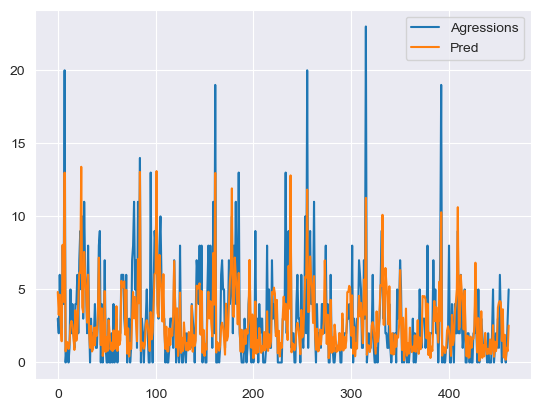

In [13]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()

In [360]:
nnnf = community_mesos.drop(columns=['agressions_community_2_month_avg', 'agressions_community_6_month_avg', 'agressions_lag_1',  'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4'])

X= nnnf.drop(columns = 'Agressions')
y = nnnf['Agressions']

X_train, X_test, y_train, y_test  = split_func_com(y, X, y, '2022-07', 462)
model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.1, max_depth= 3, subsample = 0.8999999999999999, colsample_bytree = 0.5, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)

f = df_prova.groupby([df['month_year'], df['Community Area']]).count().unstack(fill_value=0).stack()
f = f.iloc[:, :-24]
f = f.rename(columns = {'ID':'Agressions'})
f= f.reset_index().set_index('month_year')
f = f[f['Community Area'] != 0]
f = f.iloc[:, 1:]
f = f.loc[f.index.year != 2023]
test = f.iloc[-462:]

test['Pred'] = xg_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

Agressions      Pred  Mean model  MAPE  MAPE mean      SMAPE  \
month_year                                                                 
2022-07              2  5.297960    2.692641   inf        inf  80.878792   
2022-07              2  3.365286    2.692641   inf        inf  80.878792   
2022-07              6  4.822054    2.692641   inf        inf  80.878792   
2022-07              3  3.116050    2.692641   inf        inf  80.878792   
2022-07              1  1.666457    2.692641   inf        inf  80.878792   
...                ...       ...         ...   ...        ...        ...   
2022-12              1  1.880973    2.692641   inf        inf  80.878792   
2022-12              0  0.158586    2.692641   inf        inf  80.878792   
2022-12              1  0.955556    2.692641   inf        inf  80.878792   
2022-12              3  0.778491    2.692641   inf        inf  80.878792   
2022-12              3  2.679818    2.692641   inf        inf  80.878792   

            SMAPE mean       MAE  MAE mean  Metrica nomb  Metrica nomb mean  \
month_year                                                                    
2022-07       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-07       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-07       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-07       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-07       91.00133  1.434581  2.162572     66.233766           60.17316   
...                ...       ...       ...           ...                ...   
2022-12       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-12       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-12       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-12       91.00133  1.434581  2.162572     66.233766           60.17316   
2022-12       91.00133  1.434581  2.162572     66.233766           60.17316   

                RMSE  RMSE mean       MSE  
month_year                                 
2022-07     1.918376    3.03242  3.680166  
2022-07     1.918376    3.03242  3.680166  
2022-07     1.918376    3.03242  3.680166  
2022-07     1.918376    3.03242  3.680166  
2022-07     1.918376    3.03242  3.680166  
...              ...        ...       ...  
2022-12     1.918376    3.03242  3.680166  
2022-12     1.918376    3.03242  3.680166  
2022-12     1.918376    3.03242  3.680166  
2022-12     1.918376    3.03242  3.680166  
2022-12     1.918376    3.03242  3.680166  

[462 rows x 14 columns]

In [363]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train_y
d = pd.concat([train.reset_index().set_index(['month_year','Agressions', 'Pred']), test.reset_index().set_index(['month_year','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('month_year')
d = d[-24:]

mesos_comunitat = pd.DataFrame()
mesos_comunitat = d[['Agressions', 'Pred']]
mesos_comunitat = mesos_comunitat.rename(columns={'Pred':'XGBoost'})

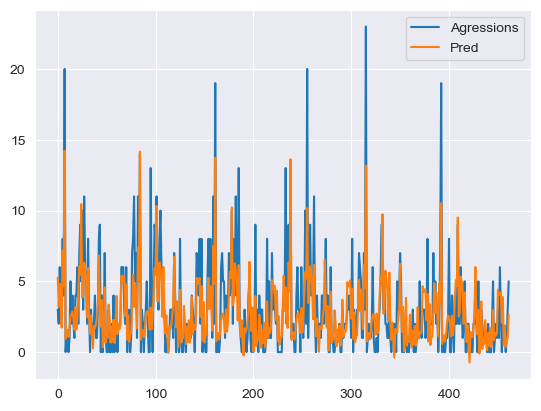

In [162]:
test = test.reset_index()
test.plot(y=["Agressions","Pred"])
plt.show()